# KITTI Odometry Dataset - Computer Vision
This notebook uses OpenCV to apply stereo depth estimation and multi-view geometry to attempt to track vehicle position through a sequence of the KITTI odometry dataset. A dataset handler class is provided to easily interact with the provided data and sensor calibration information. Useful functions are also provided to perform this basic example of visual odometry using the opencv-python package. This notebook pairs with a series of video tutorials on YouTube.

While exploring this dataset, this notebook will review fundamental computer vision principles required to perform the task of stereo depth estimation and visual odometry, and demonstrate the implementation of those principles using numpy and OpenCV in Python. 

These topics will include: 
 - The pinhole camera model 
 - Intrinsic and extrinsic camera parameters and matrices
 - Projection matrices
 - Rectified projection matrices
 - Projective geometry
 - 3D tranformations
 - Disparity and depth estimation from stereo
 - Image Feature detection/description/matching
 - Pose estimation from Perspective n Point (PnP) algorithm using RANSAC
 
In this way, the author hopes that it will serve as a useful source of knowledge and intuition for intermediate Python programmers who are beginning to explore computer vision and/or autonomous vehicle research.

The notebook assumes that this repository is placed in a folder alongside another folder which contains your download of the KITTI odometry dataset. If you have your data downloaded in a separate folder, adjust the file paths accordingly. The ground truth poses are based on the left grayscale camera, so we will be using the grayscale stereo pair, and there is no need to download the sizeable RGB portion of the dataset to follow this tutorial.

The only packages required to run the notebook are basic python packages and OpenCV. The dataset handler class uses progressbar2 for fashion, but if you don't have or want that module, simply pass progress_bar=False when instantiating the Dataset_Handler class to avoid error.

Because storing the sequences as lists attached to the Dataset_Handler class takes around 20GB of RAM, there is a boolean argument low_memory, which if passed as 'True' will create a class with generators rather than lists, so that the memory use is manageable. This is the default behavior. If you have a lot of RAM, pass 'False'.

In [1]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

First, let's get the ground truth trajectory for the first sequence and have a look.

In [2]:
# We can use pandas to read the text file and take a initial look at what we have
poses = pd.read_csv('../dataset/poses/00.txt', delimiter=' ', header=None)
print('Shape of position dataframe:', poses.shape)
poses.head()

Shape of position dataframe: (4541, 12)


0             1             2             3             4         5   \
0  1.000000  9.043680e-12  2.326809e-11  5.551115e-17  9.043683e-12  1.000000   
1  0.999998  5.272628e-04 -2.066935e-03 -4.690294e-02 -5.296506e-04  0.999999   
2  0.999991  1.048972e-03 -4.131348e-03 -9.374345e-02 -1.058514e-03  0.999997   
3  0.999980  1.566466e-03 -6.198571e-03 -1.406429e-01 -1.587952e-03  0.999993   
4  0.999964  2.078471e-03 -8.263498e-03 -1.874858e-01 -2.116664e-03  0.999987   

             6             7             8             9         10  \
0  2.392370e-10  3.330669e-16  2.326810e-11  2.392370e-10  1.000000   
1 -1.154865e-03 -2.839928e-02  2.066324e-03  1.155958e-03  0.999997   
2 -2.308104e-03 -5.676064e-02  4.128913e-03  2.312456e-03  0.999989   
3 -3.462706e-03 -8.515762e-02  6.193102e-03  3.472479e-03  0.999975   
4 -4.615826e-03 -1.135202e-01  8.253797e-03  4.633149e-03  0.999955   

             11  
0 -4.440892e-16  
1  8.586941e-01  
2  1.716275e+00  
3  2.574964e+00  
4  3.432648e+00

In [3]:
# We can see that we have 4541 rows and 12 columns. 4541 is the number of image frames in this
# sequence, and the number 12 comes from flattening a 3x4 transformation matrix of the left
# stereo camera with respect to the global coordinate frame. The global frame is established 
# the coordinate frame of the camera's first position. A 3x4 transfomration matrix contains
# a 3x3 rotation matrix horizontally stacked with a 3x1 translation vector in the form R|t
# To verify this, we can look at the first pose, and see that the
# rotational component is identity, with a translation vector equal to zero for all axes.
print('First position:')
first_pose = np.array(poses.iloc[0]).reshape((3,4)).round(2)
first_pose

First position:


array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1., -0.]])

The equation that this fits into is as follows:
![Camera2Global](images/cam2global.png)
These matrices represent a transformation between the current camera coordinate frame and the coordinate frame of the camera's initial position. It is helpful to get a visual understanding of a camera's coordinate system, where the Z axis points forward, the Y axis points downwards, and the X axis is horizontal:
![CameraCoordinateFrame](images/camera_frame.png)

Here we can see the camera coordinate frame marked Fc. We will be referring back to this image multiple times throughout this tutorial, but for now, just take note of the orientation of the axes of the camera's coordinate frame, and understand that the global coordinate frame that the vehicle's motion is tracked through is the coordinate frame of the camera's first position in the sequence.

In [4]:
# To establish this logic, we can do a quick sanity check on the math.
# First, let's store all of these ground truth (gt) position matrices into a numpy array with 
# the proper shape for convenient access:
gt = np.zeros((len(poses), 3, 4))
for i in range(len(poses)):
    gt[i] = np.array(poses.iloc[i]).reshape((3, 4))

In [5]:
# If we take the transformation matrix from the second frame and take the dot product with
# the camera's origin in its own coordinate frame for that frame (the origin of the camera
# in its own reference frame is always [0,0,0,1] for any frame), we can see where
# the camera is in relation to the global coordinate frame, which is the coordinate frame
# of the camera's first position. Notice that we are using homogeneous coordinates, in that
# we have added a 1 to the end of a vector in 3D space. This makes the application of the 
# rotational and translational components of the transformation convenient in one multiplication
# step. This trick will continue to come in handy later.
gt[1].dot(np.array([0,0,0,1]))

array([-0.04690294, -0.02839928,  0.8586941 ])

In [6]:
# We know that we've applied the math correctly, because we know that the car was moving forward
# at the beginning of the video, and the value of Z (the forward direction) in our resulting
# vector above is positive, which checks out. This means that in the second frame, the camera
# was .85 meters in front of where it was in the first frame. As we will see, the camera
# operates at ~10FPS, which puts this at 8.5m/s, or roughly 19 mph, which sounds right.

In [7]:
# Now that we have our array of ground truth poses, we can look at true trajectory of the car
# through the sequence. We don't need to be concerned with the rotations here, since their
# effects are implicit in the position of the camera origin over time, which is represented by
# the fourth column of each transformation matrix.
%matplotlib notebook

<IPython.core.display.Javascript object>


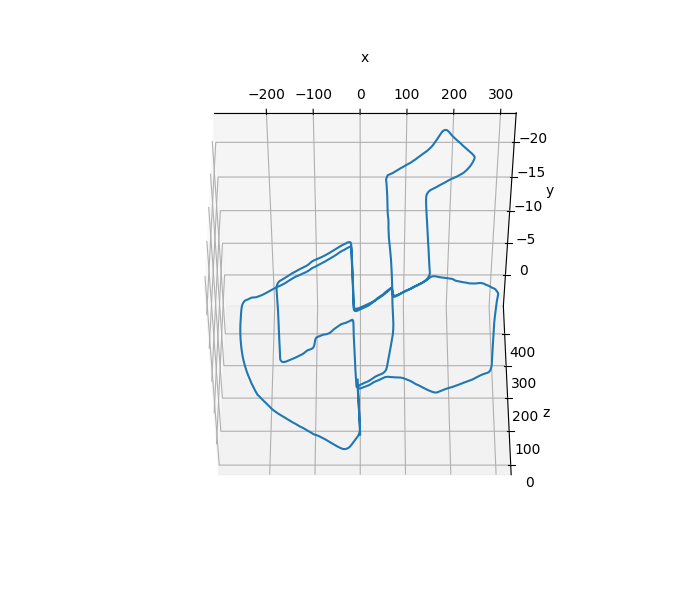

In [8]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(gt[:, :, 3][:, 0], gt[:, :, 3][:, 1], gt[:, :, 3][:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=-40, azim=270)

We can see that the trajectory starts and ends in the same spot, working around some corners, slanted on a bit of a hill.

Now let's take a quick look at our first image.

In [8]:
test_img = cv2.imread('../dataset/sequences/00/image_0/000000.png')

In [11]:
type(test_img)

numpy.ndarray

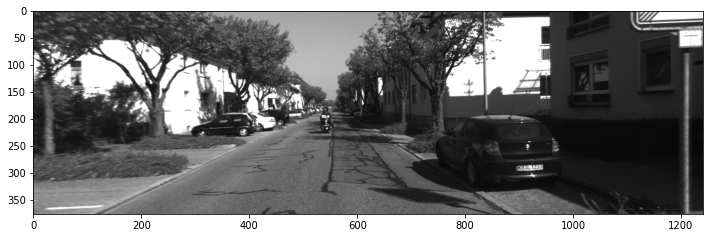

In [12]:
%matplotlib inline
plt.figure(figsize=(12,6))
plt.imshow(test_img)

## Data Exploration

In [13]:
# We can use the listdir() function to get a list of filenames in a folder
left_image_files = os.listdir('../dataset/sequences/00/image_0')
left_image_files[:5]

['000000.png', '000001.png', '000002.png', '000003.png', '000004.png']

In [14]:
# We can use this list to count the number of images in the sequence
len(left_image_files)

4541

In [15]:
# Now we can check if this matches the number of ground truth posesa
len(poses)

4541

In [16]:
# We can see they match perfectly. Our first ground truth pose is (0, 0, 0), so we
# are tracking the motion of the camera with respect to the first camera frame.

In [17]:
times = pd.read_csv('../dataset/sequences/00/times.txt', delimiter=' ', header=None)
times.head()

0
0  0.000000
1  0.103736
2  0.207338
3  0.311075
4  0.414692

In [18]:
# We can see that the timing of the camera is right around 10fps

### Projection Matrices - Sensor Calibration

In [19]:
# We can load in our sensor calibration data as follows
calib = pd.read_csv('../dataset/sequences/00/calib.txt', delimiter=' ', header=None, index_col=0)
calib

1         2           3           4         5           6   \
0                                                                         
P0:  718.856000  0.000000  607.192800    0.000000  0.000000  718.856000   
P1:  718.856000  0.000000  607.192800 -386.144800  0.000000  718.856000   
P2:  718.856000  0.000000  607.192800   45.382250  0.000000  718.856000   
P3:  718.856000  0.000000  607.192800 -337.287700  0.000000  718.856000   
Tr:    0.000428 -0.999967   -0.008084   -0.011985 -0.007211    0.008081   

             7         8         9         10        11        12  
0                                                                  
P0:  185.215700  0.000000  0.000000  0.000000  1.000000  0.000000  
P1:  185.215700  0.000000  0.000000  0.000000  1.000000  0.000000  
P2:  185.215700 -0.113089  0.000000  0.000000  1.000000  0.003780  
P3:  185.215700  2.369057  0.000000  0.000000  1.000000  0.004915  
Tr:   -0.999941 -0.054040  0.999974  0.000486 -0.007207 -0.292197

We can see that they have provided us 3x4 projection matrices for 4 cameras, as well as the transformation matrix for the LIDAR labeled Tr. It is important to note that in the readme file for the dataset, these are the camera rectification matrices AFTER RECTIFICATION, which means that they are not normal rectification matrices. I will go into this more in just a moment.

*IMPORTANT NOTE*: If you DO NOT see a 5th row in the dataframe above labeled 'Tr', then, like me, your download did not come with a proper calibration file. This can be resolved by downloading the calibration file from [this link](http://www.cvlibs.net/download.php?file=data_odometry_calib.zip) and replacing the files in your dataset (use WinRAR to extract to the directory of your dataset and it will automatically merge the files into their correct locations). We won't be using LIDAR in this tutorial, so you can ignore this and keep following along, but you should have the right files for your own sake, and future tutorials will involve the LIDAR data.

In [20]:
# P0 is the projection matrix left grayscale camera
P0 = np.array(calib.loc['P0:']).reshape((3,4))
P0

array([[718.856 ,   0.    , 607.1928,   0.    ],
       [  0.    , 718.856 , 185.2157,   0.    ],
       [  0.    ,   0.    ,   1.    ,   0.    ]])

On the subject of projection matrices, let's take a moment to discuss what information is contained in these 3x4 matrices, and how it is useful to us. These matrices contain intrinsic information about the camera's focal length and optical center, which we will discuss later. Further, they also contain tranformation information which relates each camera's coordinate frame to the global coordinate frame (in this case that of the left grayscale camera).

A projection matrix takes 3D coordinates in the global coordinate frame and projects them onto the image plane of the camera through the following formula. Note that throughout this notebook, 3D coordinates in the global reference frame will have no subscript, and 3D coordinates in a camera's frame will be marked with subscript c.

![Projection Matrix](images/projection_matrix.png)

Notice that the left side of the equation is being multiplied by λ to be equivalent to the right side of the equation. This is known as the scale, and this is the depth to the point along the Z axis from the camera, that is, the Z value AFTER the transformation R|t has been applied to the 3D point to bring it into the camera's coordinate frame. Since we really want the homogeneous pixel coordinates (u, v, 1) that project the 3D point (X, Y, Z, 1), this equation may be more clearly written as:

![Projection Matrix 2](images/projection_matrix2.png)

We will return to talking about lambda (λ) in a moment. Let us first break down the relationship between a camera's projective matrix and its intrinsic and extrinsic matrices.

A projection matrix (P) is the dot product of the intrinsic and extrinsic matrices of a camera. The intrinsic matrix (k) contains the focal length and optical center parameters, and the extrinsic matrix (R|t) contains the pose of the camera in the same form we saw earlier with the ground truth poses of the car: a 3x3 rotation matrix horizontally stacked with a 3x1 translation vector. We can see the formula for P below:

![Projection Matrix Equation](images/P_matrix_eq.png)

Breaking down the P matrix into intrinsic and extrinsic camera matrices in the above equation then provides us with the following, which is a more explicit description of the process of projecting a 3D point in any coordinate frame into the pixel coordinate frame of the camera:

![Broken into Intrinsic and Extrinsic](images/intrinsic_extrinsic.png)

Now, remember that the projection matrices from the caibration file are the camera projection matrices for each camera AFTER RECTIFICATION in terms of the stereo rig. Normally, a camera's projection matrix take a 3D point in a global coordinate frame and projects it onto pixel coordinates on THAT camera's image frame. Rectified projection matrices are the opposite, and are designed to map points each camera's coordinate frame onto one single image plane: that of the left camera. This means they are going in the opposite direction, as these matrices are taking 3D points from the coordinate frame of the camera they are associated with, and projecting them onto the image plane of the left camera. If phrased in terms of normal projection matrix logic, P0 through P1 are basically 4 different projection matrices for the same (left grayscale) camera, considering 4 different "global" coordinate frames for each one of the cameras.

We can make a concrete example of the difference by considering the schematic of the sensor configuration provided by the KITTI team:

![KITTI Schematic](images/kitti_schematic.png)

We can see from the schematic that there are two stereo pairs of cameras, one set of grayscale and one set of RGB, and that the baseline (distance between right and left) is 0.54 meters on the X axis of the left grayscale camera.

If the projection matrices provided were standard per-camera projection matrices, we would expect the extrinsic matrix to take a point from the global coordinate frame and tranform it into the frame of the camera. For example, if we were to take the origin of the global coordinate frame (the origin of the left grayscale camera) and translate it into the coordinate frame of the right grayscale camera, we would expect to see an X coordinate of -0.54, since the left camera's origin is 0.54 meters to the left of the right grayscale camera's origin. To test this, we can decompose the projection matrix given for the right camera into k, R, and t though a useful function in OpenCV:

In [21]:
# Decomposing a projection matrix with OpenCV
P1 = np.array(calib.loc['P1:']).reshape((3,4))
k1, r1, t1, _, _, _, _ = cv2.decomposeProjectionMatrix(P1)
t1 = t1 / t1[3]
print('Intrinsic Matrix:')
print(k1)
print('Rotation Matrix:')
print(r1)
print('Translation Vector:')
print(t1.round(4))

Intrinsic Matrix:
[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
Rotation Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Translation Vector:
[[ 0.5372]
 [ 0.    ]
 [-0.    ]
 [ 1.    ]]


In [22]:
# Above, we can see the intrinsic matrix k, the rotation matrix R, and the translation vector
# t we got by decomposing the projection matrix given for the right camera. Remember that
# the extrinsic matrix is actually a horizontal stack of R and t in the form (R|t), which
# we can use to transform a 3D homogenous coordinate in the global frame to a 3D coordinate
# in the camera frame, at least if this were a normal camera projection matrix.
# In this case, let's see what we get if we transform the origin of the global coordinate
# frame (the origin of the left grayscale camera) using the tranformation/extrinsic matrix
# we got from this projection matrix. According to the schematic, we should expect it to be
# 0.54m to the left (X = -0.54)
# Note that the OpenCV function has provided t as a homogeneous coordinate, so we need to
# drop the fourth value to horizontally stack it with the 3x3 rotation matrix.
Rt = np.hstack([r1, t1[:3]])
# Now to consider transform the origin of the global frame (0, 0, 0, 1)
origin = np.array([0, 0, 0, 1])
Rt.dot(origin).round(4).reshape(-1,1)

array([[ 0.5372],
       [ 0.    ],
       [-0.    ]])

In [23]:
# And here we can see the issue: the X value is POSITIVE 0.54, which points 0.54m to the right
# of the camera frame, which tells us that this projection matrix is NOT actually referring to
# the right camera, it is referring to the left camera, and treating the origin of the right
# camera as the global coordinate frame. This is because it is a rectified projection matrix
# for a stereo rig, which is intended to project points from the coordinate frames of multiple
# cameras onto the SAME image plane, rather than the coordinates from one coordinate frame onto
# the image planes of multiple cameras.

Each rectified projection matrix will take (X, Y, Z, 1) homogeneous coordinates of 3D points in the associated sensor's coordinate frame and translates them to pixel locations (u, v, 1) on the image plane of the left grayscale camera.

Notice that the result we got from translating the origin is identical to the translation vector itself, so it is not necessary to do the extra step of math to figure out where the origin of the "global" coordinate frame is in relation to a camera, one only has to look at t. In this case, we can see that the rectified projection matrix decomposes into an extrinsic matrix which tells us that the "global" coordinate frame origin of the right camera is 0.54m to the right of the left camera, which matches what we see in the schematic.

In [24]:
# As an exercise, let's turn this rectified projection matrix into a regular projection matrix
# for the right grayscale camera. We do this by decomposing the matrix, making the extrinsic
# matrix homogeneous, inverting it, then recombining the intrinsic and inverted extrinsic.
# Since we've already decomposed and stacked the Rt transformation matrix, let's now make
# it homogeneous and run our test to see if the origin of the left camera appears at X=-0.54
T_homogeneous = np.vstack([Rt, np.array([0, 0, 0, 1])])
T_hom_inv = np.linalg.inv(T_homogeneous)
print('Homogeneous transformation matrix:')
print(T_homogeneous.round(4))
print('Inverted homogeneous transformation matrix:')
print(T_hom_inv.round(4))

Homogeneous transformation matrix:
[[ 1.      0.      0.      0.5372]
 [ 0.      1.      0.      0.    ]
 [ 0.      0.      1.     -0.    ]
 [ 0.      0.      0.      1.    ]]
Inverted homogeneous transformation matrix:
[[ 1.      0.      0.     -0.5372]
 [ 0.      1.      0.     -0.    ]
 [ 0.      0.      1.      0.    ]
 [ 0.      0.      0.      1.    ]]


In [25]:
# We can see that our t vector has indeed moved to -0.54
# If we want to have normal P matrices for each camera, this is the process we would follow
# This would come in handy if we were going to do visual odometry in the left and right 
# cameras simultaneously to smooth out noise. For now, we're just going to stick to one.

Now that we know what these calibration matrices are actually telling us, and that they are in all in reference to the left grayscale camera's image plane, let's go back and look again at the equation which projects 3D points form a given coordinate frame onto the image plane of a camera, and talk more about the lambda (λ) value. λ will have a single value when considering a single point transformation, or be a vector containing a separate value for each point if using the equation for matrices of multiple 3D points. Its value is equal to the Z value obtained AFTER the tranformation (R|t) has been applied to the 3D point, so the Z value of the point in the coordinate frame of the camera. This is the depth of the point from the camera. Because we are projecting 3D points onto a 2D surface, by dividing each point by its depth, we are projecting all of them onto a plane which is 1 unit away from the origin of the camera down the Z axis, since all points will subsequently have a Z value of 1 after the division. 

Note that the division by lambda in the right side of the equation can happen AT ANY POINT in the order of operations, that is, you could directly divide (X, Y, Z, 1) by it, then do the dot products, or divide the dot product of R|t and (X, Y, Z, 1) by it, then do the dot product with k, or do all the dot products and divide the result by it, and the result will be the same. Of course, the first option just listed doesn't make much sense, since we obtain the value of λ taking the dot product of R|t and (X, Y, Z, 1) and extracting the resulting Z coordinate in the camera frame, but nonetheless, we will do each computation now in python to prove the point.

In [26]:
# Let's take some point measured with respect to the coordinate frame of the left camera when 
# it is in it's 14 pose of the sequence, and transform it onto the image plane of the camera
# in it's first position, which we can do by using accessing the 14th pose from the ground truth
# Here are the coordinates of the point measured in this frame
some_point = np.array([1, 2, 3, 1]).reshape(-1,1)
# Let's get the depth of this point from the left camera by tranforming it into the coordinate
# frame of the left camera, and taking the Z value. We can do the transformation using the
# Rt matrix we stacked a moment ago.
transformed_point = gt[14].dot(some_point)
depth_from_cam = transformed_point[2]

print('Original point:\n', some_point)
print('Transformed point:\n', transformed_point.round(4))
print('Depth from camera:\n', depth_from_cam.round(4))

Original point:
 [[1]
 [2]
 [3]
 [1]]
Transformed point:
 [[ 0.2706]
 [ 1.5461]
 [15.0755]]
Depth from camera:
 [15.0755]


In [27]:
# To project this 3D point onto the image plane, we could first apply the intrinsic matrix, 
# THEN divide by the depth, which would take us from meters, to pixel*meters, then to pixels,
# or we could just divide by the depth first, taking us into unitless measurements by dividing
# meters by meters,then multiply by the intrinsic matrix, which would then take us from 
# unitless to pixels

# Multiplying by intrinsic matrix k, then dividing by depth
pixel_coordinates1 = k1.dot(transformed_point) / depth_from_cam

# Dividing by depth then multiplying by intrinsic matrix k
pixel_coordinates2 = k1.dot(transformed_point / depth_from_cam)

print('Pixel Coordinates 1st way:', pixel_coordinates1.T)
print('Pixel Coordinates 2nd way:', pixel_coordinates2.T)

Pixel Coordinates 1st way: [[620.09802465 258.93763336   1.        ]]
Pixel Coordinates 2nd way: [[620.09802465 258.93763336   1.        ]]


In [28]:
# We can see that we get the same results either way.
# Another thing that is done regularly is "normalizing" the pixel coordinates by multiplying
# them by the inverse of the intrinsic matrix k, which brings us back into unitless values,
# as we take pixel measurements and multiply them by the inverse of pixel measurements.
normalized_coordinates = np.linalg.inv(k1).dot(pixel_coordinates1)
print('Normalized Coordinates:', normalized_coordinates.T)

Normalized Coordinates: [[0.01795245 0.10255452 1.        ]]


In [29]:
# This is often done when using a series of points to estimate camera matrices, which we will
# not be doing, but it is important to know the reason why. Since the homogeneous pixel
# coordinates have large values representing the pixel positions, and have a small third
# componenet of 1, they can produce ill-conditioned matrices when using them to solve complex
# mathematical operations, so the normalized coordinates are used in these scenarios instead.
# For our purposes, it is interesting to see that if we take the normalized coordinates and
# multiply them by their respective depths, we can reconstruct the original 3D position from
# the 2D projection of a point (as long as we know the depth)
restored_3D = normalized_coordinates.T * depth_from_cam
restored_3D.round(4)

array([[ 0.2706,  1.5461, 15.0755]])

In [30]:
# And we are back to 3D coordinates in our camera frame.
# To get back to the 3D position in our original coordinate frame, we can add a row of
# (0, 0, 0, 1) to the transformation matrix we used to make it homogeneous, then invert it, 
# and finally dot it with the restored 3D coordinates in the camera frame (note that we
# also need to add a 1 to the end of these coordinates to make them homogeneous as well)
T_homogeneous = np.vstack([gt[14], np.array([0, 0, 0, 1])])
T_hom_inv = np.linalg.inv(T_homogeneous)
restored_3D_hom = np.append(restored_3D, 1)
T_hom_inv.dot(restored_3D_hom)

array([1., 2., 3., 1.])

In [31]:
# And there we have it, we went from a 3D point on a coordinate frame, projected it to pixel
# coordinates of a camera in a separate coordinate frame, reconstructed the metrics using a 
# known depth, and then reverse transformed the 3D point back into the original frame by
# inverting a homogeneous version of the original transformation matrix used and dotting it with
# the homogeneous 3D coordinates of the point in the camera's coordinate frame. This type of 
# math will come in handy later when we want to figure out where the car is in reference to the
# global coordinate frame.

What if we want to find the pixel coordinates of a 3D point located in the same frame as the camera? Recall that the first ground truth pose was an extrinsic matrix which was composed of an identity rotation matrix and a translation vector (0,0,0). Since an extrinsic matrix relates the pose of the camera to the global coordinate frame where (X, Y, Z, 1) are measured, and the first camera position IS the global coordinate frame, there is no transformation (rotation and tranlation) between them. Considering this alongside the above equations, we can see that if (X, Y, Z, 1) is measured in the camera's own coordinate frame, then the equation above becomes:

![Coordinate-to-Pixel](images/coordinate2pixel.png)

Recall that λ is the value of Z after 3D coordinates have been transformed (Z_c):

![Lambda = Z_c](images/lambdaequalsZ_c.png)

We can then rewrite the equation as follows to get to pixel coordinates:

![XYZ to Pixels](images/xyz2pixels.png)

Or we may wish to be in normalized (x, y, 1) coordinates by either not multiplying by k, or by dotting the inverse of k with (u, v, 1):

![XYZ to normalized](images/to_normalized.png)

Where (x_tilde, y_tilde, 1) are the normalized coordinates we discussed earlier, which represent the 3D points projected onto a 2D plane which is 1 unit (unitless) away from the origin of the camera down the Z axis. Let's take another look at the image we saw earlier to get an intuition for what this looks like.

![Camera Frame](images/camera_frame.png)

We can see that this picture depicts the image plane (x, y) and the pixel coordinate frame (u, v) together. Astute readers my see a difference from our concept of normalized coordinates here, however: the image plane is defined here as Z = f, meaning that the image plane is f (in meters) away from the camera origin. This is actually what you expect, since this is exactly what the focal length tells us about a pinhole camera: how far away from the aperture do the light rays converge to create a clear image. We can look at this old drawing of the first concept of a camera, the camera obscura, to get a very simple intuition for this:

![Camera Obscura](images/camera_obscura.jpg)

In this picture, the focal length is the distance between the wall with the hole and the wall with the image appearing. In modern camera modeling, we just flip this upside down image back around the origin back onto the positive Z axis, but it would still be on the plane Z = f. So how did we get to talking about a plane at Z = 1? For one thing, when we were talking about our normalized (x, y, 1) coordinates, we were unitless, so you might see where this is going: we've divided by the focal length in meters along the way. But where? I honestly had to do a lot of digging to figure this part out, but I'll explain it now.

First, let's look at a slide from Rober Collins of Penn State, and see that the coordinates on our image plane are derived using similar triangles and the focal length of the camera:

![Collins Similar Triangles](images/similar_triangles.png)

We can see that this projects the 3D coordinates onto a 2D surface which is the distance f (focal distance) from the origin of the camera, just like we expect when looking at the picture of the old timer above, where the image on the wall is f meters from the hole in the opposite wall. More concisely, we can write this projection like this:

![2D Projection](images/2d_projection.png)

We can see here that since the focal length f is in meters, and Z is in meters, the vector (X, Y, Z) (which is in meters) is being multiplied by a unitless ratio between focal distance and depth to point, so it maintains the unit of meters in the vector (x, y, f). This makes sense, since if the old timer above were to measure (x, y) coordinates of the image on the wall, he would be doing so in meters, and those measurements would be f meters from the pinhole, so they would all be at (x, y, f).

The secret is that the formula to calculate the 2D projection in pixel coordinates from a 3D coordinate in the same coordinate frame as the camera is actually as follows:

![True Formula](images/true_formula.png)

Where we can see that we cancel out the focal length multiplication with the projection on the right side. How is it that we're getting away with multiplying only one side by 1/f? The answer is that the intrinsic matrix actually contains f, but measured in pixels. The contents of the intrinsic matrix are as follows:

![Intrinsic Matrix](images/intrinsic_matrix.png)

So we see then that we are still multiplying x and y by f, but not z. Why not? It seems there are two reasons: 1) Nobody cares how far a point in a 2D image is in pixels away from the origin of the camera, the information is not useful; and 2) By keeping the third value of (u, v, 1) a 1, we have a happy set of 2D homogeneous coordinates which make math easier. The short answer is, we simply threw away the information about the depth to the image plane because it tells us nothing about anything. Once we divided by λ, we lost all useful depth information about our 3D point(s), and this cannot be retrieved without finding it some other way. This is where the stereo rig steps in!

The remaining two values in the intrinsic matrix, c_x and c_y, represent the optical center of the image, that is, where rays of light coming directly down the Z axis of the camera coordinate frame will intersect the pixel plane. While one might want to assume that this would be at the center of the camera's sensor, it is often the case that the sensor is slightly off of center with the lens, so this adjustment in the intrinsic matrix ensures that we are mapping incoming light rays to the proper pixel coordinate they will be at when they hit the camera sensor.

In [32]:
# Let's compare the optical center to the size of the image (expect it to be halfway?)
test_img.shape

(376, 1241, 3)

In [33]:
cx = k1[0,2]
cy = k1[1,2]
print('Actual center of image (x, y):', (test_img.shape[1]/2, test_img.shape[0]/2))
print('Optical center of image (cx, cy)', (cx, cy))

Actual center of image (x, y): (620.5, 188.0)
Optical center of image (cx, cy) (607.1928, 185.2157)


In [34]:
# We can see that the optical center of the camera is very close, but not quite, the center of
# the image itself. This is why camera calibration information is important, because if we had
# assumed that light coming down the camera's Z axis hit the center of the image plane, we 
# would have been projecting points in the world to the wrong parts of the image.

It is useful to take a moment to look at how c_x and c_y affect the math. They are added to the result of multiplying x or y with their respective focal length in pixels to shift the origin of the pixel plane to the upper left corner, as pixels are counted from there. Below is an explicit description of how pixel coordinates are calculated from 3D coordinates which are in the camera's frame.

![Pixel Calculation](images/pixel_calculation.png)

To finish up our data exploration, let's look at the other two camera matrices included in our calibration file, which refer to the RGB cameras in the rig.

In [35]:
# The next two matrices are referring to the RGB cameras. In that case we won't
# need them, but let's see if this makes sense
P2 = np.array(calib.loc['P2:']).reshape((3,4))
k2, r2, t2, _, _, _, _ = cv2.decomposeProjectionMatrix(P2)
t2 = t2 / t2[3]
print(k2)
print(r2)
print(t2)

[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[-0.05993858]
 [ 0.00113119]
 [-0.00377976]
 [ 1.        ]]


In [36]:
# We can see that this camera is just slightly to the left of the main camera.
# Let's now repeat this process for the fourth P matrix and see what we see
P3 = np.array(calib.loc['P3:']).reshape((3,4))
k3, r3, t3, _, _, _, _ = cv2.decomposeProjectionMatrix(P3)
t3 = t3 / t3[3]
print(k3)
print(r3)
print(t3)

[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 0.47335236]
 [-0.00202917]
 [-0.00491521]
 [ 1.        ]]


Hopefully I have not lost you with all of this theoretical review, but it really helps to have a full intuitive understanding of these concepts as we move forward with out stereo depth estimation and visual odometry project here.

### Dataset Handling
Let's make a dataset handling object to make our data more accessible as we complete our task.

*NOTE:* It is extremely important to exlicitly tell numpy to decode the velodyne binaries as float32, because it defaults to float64 and will therefore decode the information incorrectly.

In [6]:
class Dataset_Handler():
    def __init__(self, sequence, lidar=True, progress_bar=True, low_memory=True):
        import pandas as pd
        import os
        import cv2
        
        # This will tell our odometry function if handler contains lidar info
        self.lidar = lidar
        # This will tell odometry functin how to access data from this object
        self.low_memory = low_memory
        
        # Set file paths and get ground truth poses
        self.seq_dir = '../dataset/sequences/{}/'.format(sequence)
        self.poses_dir = '../dataset/poses/{}.txt'.format(sequence)
        poses = pd.read_csv(self.poses_dir, delimiter=' ', header=None)
        
        # Get names of files to iterate through
        self.left_image_files = os.listdir(self.seq_dir + 'image_0')
        self.right_image_files = os.listdir(self.seq_dir + 'image_1')
        self.velodyne_files = os.listdir(self.seq_dir + 'velodyne')
        self.num_frames = len(self.left_image_files)
        self.lidar_path = self.seq_dir + 'velodyne/'
        
        # Get calibration details for scene
        # P0 and P1 are Grayscale cams, P2 and P3 are RGB cams
        calib = pd.read_csv(self.seq_dir + 'calib.txt', delimiter=' ', header=None, index_col=0)
        self.P0 = np.array(calib.loc['P0:']).reshape((3,4))
        self.P1 = np.array(calib.loc['P1:']).reshape((3,4))
        self.P2 = np.array(calib.loc['P2:']).reshape((3,4))
        self.P3 = np.array(calib.loc['P3:']).reshape((3,4))
        # This is the transformation matrix for LIDAR
        self.Tr = np.array(calib.loc['Tr:']).reshape((3,4))
        
        # Get times and ground truth poses
        self.times = np.array(pd.read_csv(self.seq_dir + 'times.txt', 
                                          delimiter=' ', 
                                          header=None))
        self.gt = np.zeros((len(poses), 3, 4))
        for i in range(len(poses)):
            self.gt[i] = np.array(poses.iloc[i]).reshape((3, 4))
        
        # Get images and lidar loaded
        if self.low_memory:
            # Will use generators to provide data sequentially to save RAM
            # Use class method to set up generators
            self.reset_frames()
            # Store original frame to memory for testing functions
            self.first_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                               + self.left_image_files[0], 0)
            self.first_image_right = cv2.imread(self.seq_dir + 'image_1/' 
                                               + self.right_image_files[0], 0)
            self.second_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                               + self.left_image_files[1], 0)
            if self.lidar:
                self.first_pointcloud = np.fromfile(self.lidar_path + self.velodyne_files[0],
                                                    dtype=np.float32, 
                                                    count=-1).reshape((-1, 4))
            self.imheight = self.first_image_left.shape[0]
            self.imwidth = self.first_image_left.shape[1]
            
        else:
            # If RAM is not a concern (>32GB), pass low_memory=False
            if progress_bar:
                import progressbar
                bar = progressbar.ProgressBar(max_value=self.num_frames)
            self.images_left = []
            self.images_right = []
            self.pointclouds = []
            for i, name_left in enumerate(self.left_image_files):
                name_right = self.right_image_files[i]
                self.images_left.append(cv2.imread(self.seq_dir + 'image_0/' + name_left))
                self.images_right.append(cv2.imread(self.seq_dir + 'image_1/' + name_right))
                if self.lidar:
                    pointcloud = np.fromfile(self.lidar_path + self.velodyne_files[i], 
                                             dtype=np.float32, 
                                             count=-1).reshape([-1,4])
                    self.pointclouds.append(pointcloud)
                if progress_bar:
                    bar.update(i+1)
                
            self.imheight = self.images_left[0].shape[0]
            self.imwidth = self.images_left[0].shape[1]
            # Keep consistent instance variable names as when using low_memory
            self.first_image_left = self.images_left[0]
            self.first_image_right = self.images_right[0]
            self.second_image_left = self.images_left[1]
            if self.lidar:
                self.first_pointcloud = self.pointclouds[0]
            
    def reset_frames(self):
        # Resets all generators to the first frame of the sequence
        self.images_left = (cv2.imread(self.seq_dir + 'image_0/' + name_left, 0)
                            for name_left in self.left_image_files)
        self.images_right = (cv2.imread(self.seq_dir + 'image_1/' + name_right, 0)
                            for name_right in self.right_image_files)
        if self.lidar:
            self.pointclouds = (np.fromfile(self.lidar_path + velodyne_file, 
                                            dtype=np.float32, 
                                            count=-1).reshape((-1, 4))
                                for velodyne_file in self.velodyne_files)
        pass

In [113]:
# Create a handler for machines using plenty of RAM (>32GB). Do not run this cell if you have
# less than 32GB of RAM
#handler2 = Dataset_Handler('00', low_memory=False)

100% (4541 of 4541) |####################| Elapsed Time: 0:01:49 ETA:  00:00:00

In [7]:
# Creating a handler object for low_memory (<32GB) setups:
handler = Dataset_Handler('00')

# Stereo Depth + Visual Odometry (No LIDAR)
In this section, I will attempt to track the pose of the vehicle using depth maps derived from stereopsis, then using visual odometry of the left camera to track motion at scale.

In [8]:
def compute_left_disparity_map(img_left, img_right, matcher='bm', rgb=False, verbose=False):
    '''
    Takes a left and right stereo pair of images and computes the disparity map for the left
    image. Pass rgb=True if the images are RGB.
    
    Arguments:
    img_left -- image from left camera
    img_right -- image from right camera
    
    Optional Arguments:
    matcher -- (str) can be 'bm' for StereoBM or 'sgbm' for StereoSGBM matching
    rgb -- (bool) set to True if passing RGB images as input
    verbose -- (bool) set to True to report matching type and time to compute
    
    Returns:
    disp_left -- disparity map for the left camera image
    
    '''
    # Feel free to read OpenCV documentation and tweak these values. These work well
    sad_window = 6
    num_disparities = sad_window*16
    block_size = 11
    matcher_name = matcher
    
    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                      blockSize=block_size
                                     )
        
        #img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
        #img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
        #rgb = False
        
    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * 3 * sad_window ** 2,
                                        P2 = 32 * 3 * sad_window ** 2,
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                       )
    if rgb:
        img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
        img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    start = datetime.datetime.now()
    disp_left = matcher.compute(img_left, img_right).astype(np.float32)/16
    end = datetime.datetime.now()
    if verbose:
        print(f'Time to compute disparity map using Stereo{matcher_name.upper()}:', end-start)
    
    return disp_left

In [13]:
%matplotlib inline

Time to compute disparity map using StereoSGBM: 0:00:00.069032


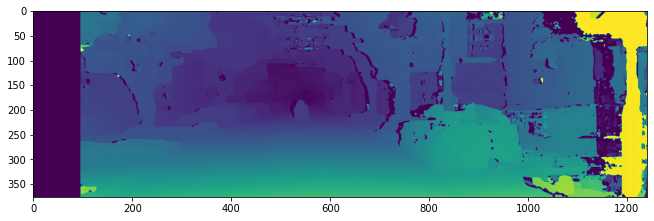

In [14]:
disp = compute_left_disparity_map(handler.first_image_left, 
                                  handler.first_image_right, 
                                  matcher='sgbm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp);

We can see that there is a gap of the left side of the image where the right camera did not have matching information. This means that we should apply a mask when looking for features to match from one frame to the next so that we can use features which fall in the area of the picture for which we have depth information.

In [15]:
# A look at what value the function above produces in places where it gets improper/missing data
disp[0,0]

-1.0

In [16]:
def decompose_projection_matrix(p):
    '''
    Shortcut to use cv2.decomposeProjectionMatrix(), which only returns k, r, t, and divides
    t by the scale, then returns it as a vector with shape (3,) (non-homogeneous)
    
    Arguments:
    p -- projection matrix to be decomposed
    
    Returns:
    k, r, t -- intrinsic matrix, rotation matrix, and 3D translation vector
    
    '''
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3]
    
    return k, r, t

def calc_depth_map(disp_left, k_left, t_left, t_right, rectified=True):
    '''
    Calculate depth map using a disparity map, intrinsic camera matrix, and translation vectors
    from camera extrinsic matrices (to calculate baseline). Note that default behavior is for
    rectified projection matrix for right camera. If using a regular projection matrix, pass
    rectified=False to avoid issues.
    
    Arguments:
    disp_left -- disparity map of left camera
    k_left -- intrinsic matrix for left camera
    t_left -- translation vector for left camera
    t_right -- translation vector for right camera
    
    Optional Arguments:
    rectified -- (bool) set to False if t_right is not from rectified projection matrix
    
    Returns:
    depth_map -- calculated depth map for left camera
    
    '''
    # Get focal length of x axis for left camera
    f = k_left[0][0]
    
    # Calculate baseline of stereo pair
    if rectified:
        b = t_right[0] - t_left[0] 
    else:
        b = t_left[0] - t_right[0]
        
    # Avoid instability and division by zero
    disp_left[disp_left == 0] = 0.1
    disp_left[disp_left == -1] = 0.1
    
    # Make empty depth map then fill with depth
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    return depth_map

In [17]:
k_left, r_left, t_left = decompose_projection_matrix(handler.P0)
k_right, r_right, t_right = decompose_projection_matrix(handler.P1)

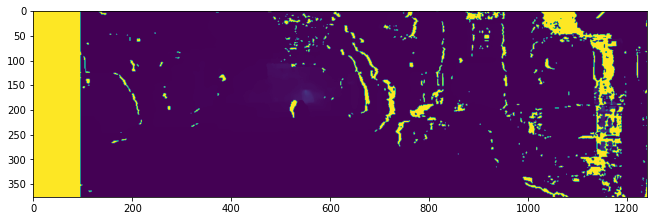

In [18]:
depth = calc_depth_map(disp, k_left, t_left, t_right)
plt.figure(figsize=(11,7))
plt.imshow(depth);

In [19]:
# Let's see what the depth is in the yellow band to the left
depth[0,1]

3861.447942459941

In [20]:
# Let's see if this is the same as the maximum estimated depth
depth.max()

3861.447942459941

In [21]:
# It is. We can use this to index inward and find the width of the yellow band, in order to
# create a mask to prevent the feature detector from searching in a useless area for features
# on every frame.
for i, pixel in enumerate(depth[4]):
    if pixel < depth.max():
        print('First non-max value at index', i)
        break

First non-max value at index 96


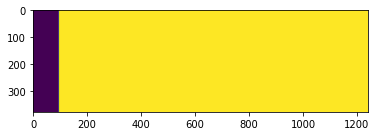

In [22]:
# We can constuct a mask using this information like so
mask = np.zeros(handler.first_image_left.shape[:2], dtype=np.uint8)
ymax = handler.first_image_left.shape[0]
xmax = handler.first_image_left.shape[1]
cv2.rectangle(mask, (96,0), (xmax,ymax), (255), thickness = -1)
plt.imshow(mask);

In [23]:
# Let's make an all-inclusive function to get the depth from an incoming set of stereo images
def stereo_2_depth(img_left, img_right, P0, P1, matcher='bm', rgb=False, verbose=False, 
                   rectified=True):
    '''
    Takes stereo pair of images and returns a depth map for the left camera. If your projection
    matrices are not rectified, set rectified=False.
    
    Arguments:
    img_left -- image of left camera
    img_right -- image of right camera
    P0 -- Projection matrix for the left camera
    P1 -- Projection matrix for the right camera
    
    Optional Arguments:
    matcher -- (str) can be 'bm' for StereoBM or 'sgbm' for StereoSGBM
    rgb -- (bool) set to True if images passed are RGB. Default is False
    verbose -- (bool) set to True to report computation time and method
    rectified -- (bool) set to False if P1 not rectified to P0. Default is True
    
    Returns:
    depth -- depth map for left camera
    
    '''
    # Compute disparity map
    disp = compute_left_disparity_map(img_left, 
                                      img_right, 
                                      matcher=matcher, 
                                      rgb=rgb, 
                                      verbose=verbose)
    # Decompose projection matrices
    k_left, r_left, t_left = decompose_projection_matrix(P0)
    k_right, r_right, t_right = decompose_projection_matrix(P1)
    # Calculate depth map for left camera
    depth = calc_depth_map(disp, k_left, t_left, t_right)
    
    return depth

In [24]:
def extract_features(image, detector='sift', mask=None):
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create()
    elif detector == 'surf':
        det = cv2.xfeatures2d.SURF_create()
        
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

In [25]:
def match_features(des1, des2, matching='BF', detector='sift', sort=True, k=2):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image
    matching -- (str) can be 'BF' for Brute Force or 'FLANN'
    detector -- (str) can be 'sift or 'orb'. Default is 'sift'
    sort -- (bool) whether to sort matches by distance. Default is True
    k -- (int) number of neighbors to match to each feature.

    Returns:
    matches -- list of matched features from two images. Each match[i] is k or less matches for 
               the same query descriptor
    """
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=k)
    
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

In [26]:
def filter_matches_distance(matches, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

In [27]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

Time to compute disparity map using StereoSGBM: 0:00:00.073032
Number of matches before filtering: 3206
Number of matches after filtering: 446


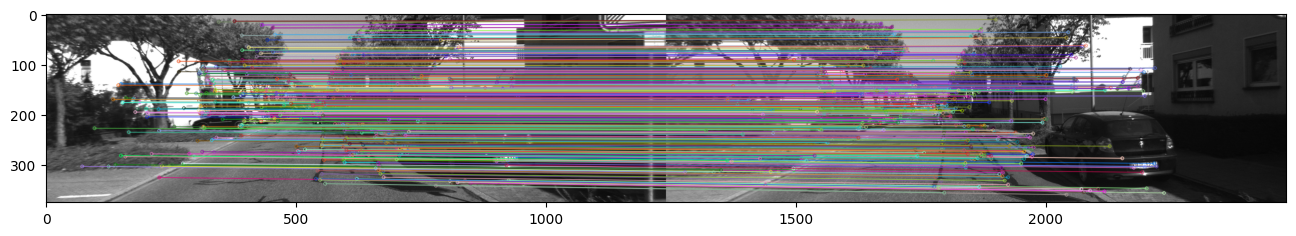

In [28]:
# Look at matched points using sgbm matcher
image_left = handler.first_image_left
image_right = handler.first_image_right
image_plus1 = handler.second_image_left
depth = stereo_2_depth(image_left, 
                       image_right, 
                       handler.P0, 
                       handler.P1,
                       matcher='sgbm',
                       verbose=True)
kp0, des0 = extract_features(image_left, 'sift')
kp1, des1 = extract_features(image_plus1, 'sift')
matches = match_features(des0, des1, matching='BF', detector='sift', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.3)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

Time to compute disparity map using StereoBM: 0:00:00.028998
Number of matches before filtering: 3206
Number of matches after filtering: 446


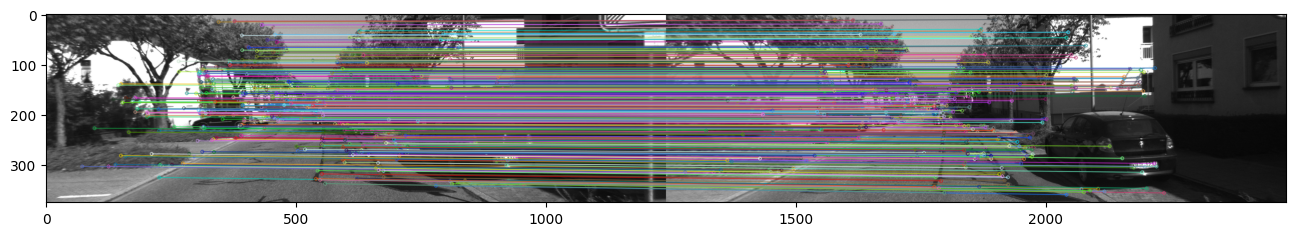

In [29]:
# Now to see the difference with 'bm' matcher
image_left = handler.first_image_left
image_right = handler.first_image_right
image_plus1 = handler.second_image_left
depth = stereo_2_depth(image_left, 
                       image_right, 
                       handler.P0, 
                       handler.P1,
                       matcher='bm',
                       verbose=True)
kp0, des0 = extract_features(image_left, 'sift')
kp1, des1 = extract_features(image_plus1, 'sift')
matches = match_features(des0, des1, matching='BF', detector='sift', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.3)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

In [30]:
# We can see that the 'bm' matcher is around 5x faster than the 'sgbm' matcher, and produced the
# same number of matches. Since speed is essential, we will use the 'bm' matcher

Time to compute disparity map using StereoBM: 0:00:00.027970
Number of matches before filtering: 500
Number of matches after filtering: 260


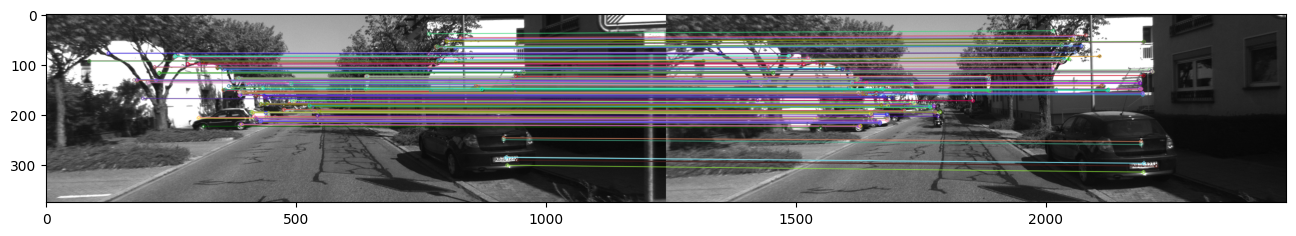

In [31]:
# Now to see the difference with ORB descriptor
image_left = handler.first_image_left
image_right = handler.first_image_right
image_plus1 = handler.second_image_left
depth = stereo_2_depth(image_left, 
                       image_right, 
                       handler.P0, 
                       handler.P1,
                       matcher='bm',
                       verbose=True)
kp0, des0 = extract_features(image_left, 'orb')
kp1, des1 = extract_features(image_plus1, 'orb')
matches = match_features(des0, des1, matching='BF', detector='orb', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.8)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

In [32]:
def pointcloud2image(pointcloud, imheight, imwidth, Tr, P0):
    '''
    Takes a pointcloud of shape Nx4 and projects it onto an image plane, first transforming
    the X, Y, Z coordinates of points to the camera frame with tranformation matrix Tr, then
    projecting them using camera projection matrix P0.
    
    Arguments:
    pointcloud -- array of shape Nx4 containing (X, Y, Z, reflectivity)
    imheight -- height (in pixels) of image plane
    imwidth -- width (in pixels) of image plane
    Tr -- 3x4 transformation matrix between lidar (X, Y, Z, 1) homogeneous and camera (X, Y, Z)
    P0 -- projection matrix of camera (should have identity transformation if Tr used)
    
    Returns:
    render -- a (imheight x imwidth) array containing depth (Z) information from lidar scan
    
    '''
    # We know the lidar X axis points forward, we need nothing behind the lidar, so we
    # ignore anything with a X value less than or equal to zero
    pointcloud = pointcloud[pointcloud[:, 0] > 0]
    
    # We do not need reflectance info, so drop last column and replace with ones to make
    # coordinates homogeneous for tranformation into the camera coordinate frame
    pointcloud = np.hstack([pointcloud[:, :3], np.ones(pointcloud.shape[0]).reshape((-1,1))])
    
    # Transform pointcloud into camera coordinate frame
    cam_xyz = Tr.dot(pointcloud.T)
    
    # Ignore any points behind the camera (probably redundant but just in case)
    cam_xyz = cam_xyz[:, cam_xyz[2] > 0]
    
    # Extract the Z row which is the depth from camera
    depth = cam_xyz[2].copy()
    
    # Project coordinates in camera frame to flat plane at Z=1 by dividing by Z
    cam_xyz /= cam_xyz[2]
    
    # Add row of ones to make our 3D coordinates on plane homogeneous for dotting with P0
    cam_xyz = np.vstack([cam_xyz, np.ones(cam_xyz.shape[1])])
    
    # Get pixel coordinates of X, Y, Z points in camera coordinate frame
    projection = P0.dot(cam_xyz)
    #projection = (projection / projection[2])
    
    # Turn pixels into integers for indexing
    pixel_coordinates = np.round(projection.T, 0)[:, :2].astype('int')
    #pixel_coordinates = np.array(pixel_coordinates)
    
    # Limit pixel coordinates considered to those that fit on the image plane
    indices = np.where((pixel_coordinates[:, 0] < imwidth)
                       & (pixel_coordinates[:, 0] >= 0)
                       & (pixel_coordinates[:, 1] < imheight)
                       & (pixel_coordinates[:, 1] >= 0)
                      )
    pixel_coordinates = pixel_coordinates[indices]
    depth = depth[indices]
    
    # Establish empty render image, then fill with the depths of each point
    render = np.zeros((imheight, imwidth))
    for j, (u, v) in enumerate(pixel_coordinates):
        if u >= imwidth or u < 0:
            continue
        if v >= imheight or v < 0:
            continue
        render[v, u] = depth[j]
    # Fill zero values with large distance so they will be ignored. (Using same max value)
    render[render == 0.0] = 3861.45
    
    return render

Time to compute disparity map using StereoSGBM: 0:00:00.070962


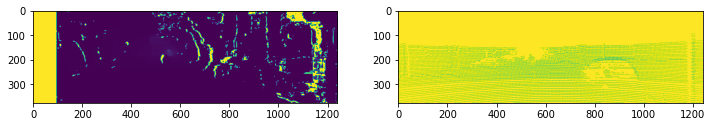

In [33]:
# Now a side-by-side comparison of the stereo depth vs lidar depth maps
depth_stereo = stereo_2_depth(image_left, 
                             image_right, 
                             handler.P0, 
                             handler.P1,
                             matcher='sgbm',
                             verbose=True)
depth_lidar = pointcloud2image(handler.first_pointcloud, handler.imheight, handler.imwidth,
                               handler.Tr, handler.P0
                              )
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
ax1.imshow(depth_stereo)
ax2.imshow(depth_lidar)

In [34]:
# Let's look at the maximum real depth returned from the lidar scan
depth_lidar[depth_lidar < 3861.45].max()

77.6779338302063

In [ ]:
%matplotlib notebook

<IPython.core.display.Javascript object>


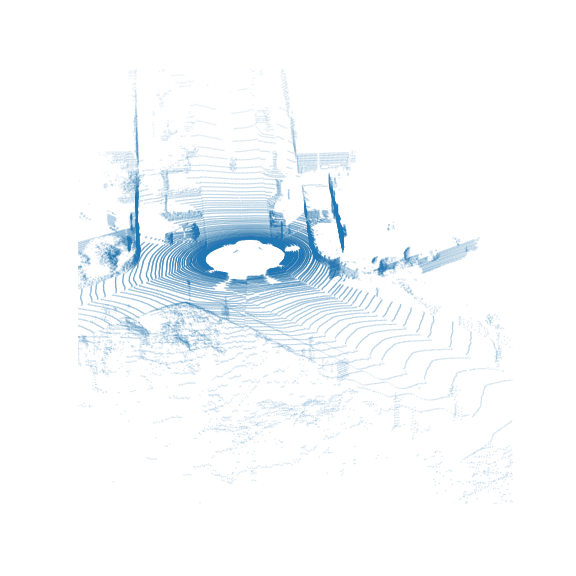

In [138]:
# Visualizing a lidar pointcloud with matplotlib.
pointcloud = handler.first_pointcloud
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

xs = pointcloud[:, 0]#[::20]   # Uncomment if 3d plot runs too slow, takes every 20th point
ys = pointcloud[:, 1]#[::20]
zs = pointcloud[:, 2]#[::20]

ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
ax.scatter(xs, ys, zs, s=0.01)
ax.grid(False)
ax.axis('off')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=40, azim=180)

In [143]:
# Let's determine the amount of image area that the lidar has given us depth information for
lidar_coverage = depth_lidar[depth_lidar < depth_lidar.max()].size / depth_lidar.size
print('Lidar Coverage: {}%'.format(np.round(lidar_coverage, 2)*100))

Lidar Coverage: 4.0%


In [144]:
# We can see that our lidar information is quite sparse, with only 4% coverage of image area

In [145]:
# A side by side comparison of the depths from stereo estimation and our lidar cloud
idx_height, idx_width = np.where(depth_lidar < 3000)
depth_indx = np.array(list(zip(idx_height, idx_width)))

comparison = np.hstack([depth_stereo[depth_indx[:, 0], depth_indx[:, 1]].reshape(-1,1), 
                        depth_lidar[depth_indx[:, 0], depth_indx[:, 1]].reshape(-1,1)
                       ])
for i, row in enumerate(comparison):
    print('location:', depth_indx[i], 'stereo/lidar depth:', row)
    if i > 100:
        break

location: [  95 1200] stereo/lidar depth: [4.06468211 4.08292768]
location: [  96 1194] stereo/lidar depth: [11.76822248  4.12029459]
location: [  96 1198] stereo/lidar depth: [11.74584943  4.11068733]
location: [  96 1204] stereo/lidar depth: [4.06468211 4.09931567]
location: [  96 1208] stereo/lidar depth: [4.06468211 4.11571653]
location: [ 102 1195] stereo/lidar depth: [11.70135758  4.12460406]
location: [ 102 1199] stereo/lidar depth: [11.70135758  4.09901906]
location: [ 102 1203] stereo/lidar depth: [4.06468211 4.09242387]
location: [ 102 1206] stereo/lidar depth: [4.06468211 4.09882914]
location: [ 106 1203] stereo/lidar depth: [4.06468211 4.09062529]
location: [ 106 1206] stereo/lidar depth: [4.06468211 4.10502159]
location: [ 107 1195] stereo/lidar depth: [11.59158874  4.1237906 ]
location: [ 107 1199] stereo/lidar depth: [4.06468211 4.11021289]
location: [ 113 1204] stereo/lidar depth: [4.06468211 4.06811246]
location: [ 113 1206] stereo/lidar depth: [4.06468211 4.07430241]


In [146]:
# We can see that there are some discrepancies between the lidar depth and the stereo depth,
# but that by and large they are pretty close, which means we've done things right.

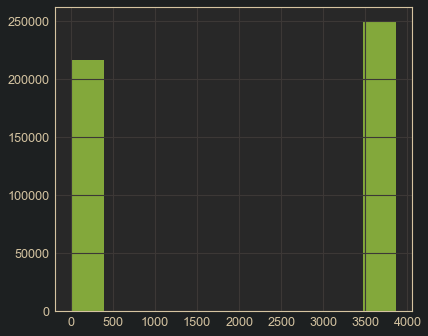

In [128]:
# Let's see the distribution of depths from our depth map, so we can decide a threshold to cut
# off points of consideration so they don't mess with our geometry
plt.hist(depth.flatten());

In [147]:
# We can see that there is a big gap between our real depth values and the erroneous max depth
# where the stereo depth computation failed. This means that we can pick a depth of 3000 to
# filter out any points that we consider in our feature matching, to make sure that we are
# matching features that are within a reasonable distance from us

In [36]:
def estimate_motion(match, kp1, kp2, k, depth1=None):
    """
    Estimate camera motion from a pair of subsequent image frames

    Arguments:
    match -- list of matched features from the pair of images
    kp1 -- list of the keypoints in the first image
    kp2 -- list of the keypoints in the second image
    k -- camera intrinsic calibration matrix 
    
    Optional arguments:
    depth1 -- Depth map of the first frame. Set to None to use Essential Matrix decomposition

    Returns:
    rmat -- estimated 3x3 rotation matrix
    tvec -- estimated 3x1 translation vector
    image1_points -- matched feature pixel coordinates in the first image. 
                     image1_points[i] = [u, v] -> pixel coordinates of i-th match
    image2_points -- matched feature pixel coordinates in the second image. 
                     image2_points[i] = [u, v] -> pixel coordinates of i-th match
               
    """
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    
    image1_points = np.float32([kp1[m.queryIdx].pt for m in match])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in match])

    if depth1 is not None:
        cx = k[0, 2]
        cy = k[1, 2]
        fx = k[0, 0]
        fy = k[1, 1]
        object_points = np.zeros((0, 3))
        delete = []

        # Extract depth information of query image at match points and build 3D positions
        for i, (u, v) in enumerate(image1_points):
            z = depth1[int(v), int(u)]
            # If the depth at the position of our matched feature is above 3000, then we
            # ignore this feature because we don't actually know the depth and it will throw
            # our calculations off. We add its index to a list of coordinates to delete from our
            # keypoint lists, and continue the loop. After the loop, we remove these indices
            if z > 3000:
                delete.append(i)
                continue
                
            # Use arithmetic to extract x and y (faster than using inverse of k)
            x = z*(u-cx)/fx
            y = z*(v-cy)/fy
            object_points = np.vstack([object_points, np.array([x, y, z])])
            # Equivalent math with dot product w/ inverse of k matrix, but SLOWER (see Appendix A)
            #object_points = np.vstack([object_points, np.linalg.inv(k).dot(z*np.array([u, v, 1]))])

        image1_points = np.delete(image1_points, delete, 0)
        image2_points = np.delete(image2_points, delete, 0)
        
        # Use PnP algorithm with RANSAC for robustness to outliers
        _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
        #print('Number of inliers: {}/{} matched features'.format(len(inliers), len(match)))
        
        # Above function returns axis angle rotation representation rvec, use Rodrigues formula
        # to convert this to our desired format of a 3x3 rotation matrix
        rmat = cv2.Rodrigues(rvec)[0]
    
    else:
        # With no depth provided, use essential matrix decomposition instead. This is not really
        # very useful, since you will get a 3D motion tracking but the scale will be ambiguous
        image1_points_hom = np.hstack([image1_points, np.ones(len(image1_points)).reshape(-1,1)])
        image2_points_hom = np.hstack([image2_points, np.ones(len(image2_points)).reshape(-1,1)])
        E = cv2.findEssentialMat(image1_points, image2_points, k)[0]
        _, rmat, tvec, mask = cv2.recoverPose(E, image1_points, image2_points, k)
    
    return rmat, tvec, image1_points, image2_points

In [ ]:
def visual_odometry(handler, detector='sift', matching='BF', filter_match_distance=None, 
                    stereo_matcher='bm', mask=None, depth_type='stereo', subset=None,
                    plot=False):
    '''
    Function to perform visual odometry on a sequence from the KITTI visual odometry dataset.
    Takes as input a Data_Handler object and optional parameters.
    
    Arguments:
    handler -- Data_Handler object instance
    
    Optional Arguments:
    detector -- (str) can be 'sift' or 'orb'. Default is 'sift'.
    matching -- (str) can be 'BF' for Brute Force or 'FLANN'. Default is 'BF'.
    filter_match_distance -- (float) value for ratio test on matched features. Default is None.
    stereo_matcher -- (str) can be 'bm' (faster) or 'sgbm' (more accurate). Default is 'bm'.
    mask -- (array) mask to reduce feature search area to where depth information available.
    depth_type -- (str) can be 'stereo' or set to None to use Essential matrix decomposition.
                        Note that scale will be incorrect with no depth used.
    subset -- (int) number of frames to compute. Defaults to None to compute all frames.
    plot -- (bool) whether to plot the estimated vs ground truth trajectory. Only works if
                   matplotlib is set to tk mode. Default is False.
    
    Returns:
    trajectory -- Array of shape Nx3x4 of estimated poses of vehicle for each computed frame.
    
    '''
    # Determine if handler has lidar data
    lidar = handler.lidar
    
    # Report methods being used to user
    print('Generating disparities with Stereo{}'.format(str.upper(stereo_matcher)))
    print('Detecting features with {} and matching with {}'.format(str.upper(detector), 
                                                                   matching))
    if filter_match_distance is not None:
        print('Filtering feature matches at threshold of {}*distance'.format(filter_match_distance))
    if lidar:
        print('Improving stereo depth estimation with lidar data')
    if subset is not None:
        #subset = subset + 1
        num_frames = subset
    else:
        # Set num_frames to one less than the number of frames so we have sequential images
        # in the last frame run.
        num_frames = handler.num_frames
        
    if plot:
        fig = plt.figure(figsize=(14, 14))
        ax = fig.add_subplot(projection='3d')
        ax.view_init(elev=-20, azim=270)
        xs = handler.gt[:, 0, 3]
        ys = handler.gt[:, 1, 3]
        zs = handler.gt[:, 2, 3]
        ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
        ax.plot(xs, ys, zs, c='k')
        
    # Establish homogeneous transformation matrix. First pose is identity    
    T_tot = np.eye(4)
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = T_tot[:3, :]
    imheight = handler.imheight
    imwidth = handler.imwidth
    
    # Decompose left camera projection matrix to get intrinsic k matrix
    k_left, r_left, t_left = decompose_projection_matrix(handler.P0)
    
    if handler.low_memory:
        handler.reset_frames()
        image_plus1 = next(handler.images_left)
    
    # Iterate through all frames of the sequence
    for i in range(num_frames - 1):
        # Stop if we've reached the second to last frame, since we need two sequential frames
        #if i == num_frames - 1:
        #    break
        # Start timer for frame
        start = datetime.datetime.now()
        # Get our stereo images for depth estimation
        if handler.low_memory:
            image_left = image_plus1
            image_right = next(handler.images_right)
            # Get next frame in the left camera for visual odometry
            image_plus1 = next(handler.images_left)
        else:
            image_left = handler.images_left[i]
            image_right = handler.images_right[i]
            # Get next frame in the left camera for visual odometry
            image_plus1 = handler.images_left[i+1]
        
        # Estimate depth if using stereo depth estimation (recommended)
        if depth_type == 'stereo':
            depth = stereo_2_depth(image_left, 
                                   image_right, 
                                   P0=handler.P0, 
                                   P1=handler.P1,
                                   matcher=stereo_matcher)
        # Otherwise use Essential Matrix decomposition (ambiguous scale)
        else:
            depth = None
            
        # Supercede stereo depth estimations where lidar points are available
        if lidar:
            if handler.low_memory:
                pointcloud = next(handler.pointclouds)
            else:
                pointcloud = handler.pointclouds[i]
            lidar_depth = pointcloud2image(pointcloud, 
                                           imheight=imheight, 
                                           imwidth=imwidth, 
                                           Tr=handler.Tr, 
                                           P0=handler.P0)
            indices = np.where(lidar_depth < 3000)
            depth[indices] = lidar_depth[indices]
            
        # Get keypoints and descriptors for left camera image of two sequential frames
        kp0, des0 = extract_features(image_left, detector, mask)
        kp1, des1 = extract_features(image_plus1, detector, mask)
        
        # Get matches between features detected in the two images
        matches_unfilt = match_features(des0, 
                                        des1, 
                                        matching=matching, 
                                        detector=detector, 
                                        sort=True)
        
        # Filter matches if a distance threshold is provided by user
        if filter_match_distance is not None:
            matches = filter_matches_distance(matches_unfilt, filter_match_distance)
        else:
            matches = matches_unfilt
            
        # Estimate motion between sequential images of the left camera
        rmat, tvec, img1_points, img2_points = estimate_motion(matches, kp0, kp1, k_left, depth)
        
        # The following code is commented out because it is only necessary if you intend to
        # use very low distance ratios for match filtering. Feel free to uncomment and try
        # out using very low distance ratios, but if you do, comment out the above line.
        # Try to get motion with filter distance, if not increase threshold until success
        #try:
        #    rmat, tvec, img1_points, img2_points = estimate_motion(matches, 
        #                                                           kp0, 
        #                                                           kp1, 
        #                                                           k_left, 
        #                                                           depth)
        #except:
        #    filt_inc = 0.1
        #    while True:
        #        print('Not enough features after filter with threshold {},'.format(filter_match_distance),
        #              'raising threshold to {} until next frame.'.format(filter_match_distance + filt_inc)) 
        #        try:
        #            matches = filter_matches_distance(matches_unfilt, filter_match_distance+filt_inc)
        #            rmat, tvec, img1_points, img2_points = estimate_motion(matches, 
        #                                                                   kp0, 
        #                                                                   kp1, 
        #                                                                   k_left, 
        #                                                                   depth)
        #            break
        #        except:
        #            filt_inc += 0.1
        #            continue
                  
        # Create blank homogeneous transformation matrix
        Tmat = np.eye(4)
        # Place resulting rotation matrix  and translation vector in their proper locations
        # in homogeneous T matrix
        Tmat[:3, :3] = rmat
        Tmat[:3, 3] = tvec.T
        
        # The SolvePnPRansac() function computes a pose that relates points in the global
        # coordinate frame to the camera's pose. We used the camera's pose in the first image
        # as the global coordinate frame, reconstruct 3D positions of the features in the
        # image using stereo depth estimation, then find a pose which relates the camera in
        # the next frame to those 3D points. When tracking the vehicle pose over time, what we
        # actually want is to relate the points in the camera's coordinate frame to the global
        # frame, so we want the opposite (inverse) of the transformation matrix provided to us
        # by the SolvePnPRansac function. Recall from the earlier discussion that we can find
        # the inverse of a transformation matrix by making it homogeneous by adding a row of
        # (0, 0, 0, 1) to it, then taking its inverse. Further, we are tracking the vehicle
        # motion from the very first camera pose, so we need the cumulative product of the
        # inverses of each estimated camera pose given to us by SolvePnPRansac. Thus, below
        # we iteratively multiply the T_tot homogeneous transformation matrix that we 
        # instantiated before the for loop by the inverse of each successive pose we estimate,
        # and save its current values into our estimated poses at an index corresponding to our
        # current frame. This way, the transformation matrix at each index will be one that
        # relates 3D homogeneous coordinates in the camera's frame to the global coordinate
        # frame, which is the coordinate frame of the camera's first position. The translation
        # vector component of this transformation matrix will describe where the camera's curent
        # origin is in this global referece frame.
        T_tot = T_tot.dot(np.linalg.inv(Tmat))
            
        # Place pose estimate in i+1 to correspond to the second image, which we estimated for
        trajectory[i+1, :, :] = T_tot[:3, :]
        # End the timer for the frame and report frame rate to user
        end = datetime.datetime.now()
        print('Time to compute frame {}:'.format(i+1), end-start)
        
        if plot:
            xs = trajectory[:i+2, 0, 3]
            ys = trajectory[:i+2, 1, 3]
            zs = trajectory[:i+2, 2, 3]
            plt.plot(xs, ys, zs, c='chartreuse')
            plt.pause(1e-32)
            
    if plot:        
    plt.close()
        
    return trajectory

In [51]:
# We need a function to tell us how much error we have compared to the ground truth
# We will use Euclidean distance of each camera pose from the ground truth to give us
# Mean Squared Error (mse), Root Mean Squared Error (rmse), or Mean Absolute Error (mae)
def calculate_error(ground_truth, estimated, error_type='mse'):
    '''
    Takes arrays of ground truth and estimated poses of shape Nx3x4, and computes error using
    Euclidean distance between true and estimated 3D coordinate at each position.
    
    Arguments:
    ground_truth -- Nx3x4 array of ground truth poses
    estimated -- Nx3x4 array of estimated poses
    
    Optional Arguments:
    error_type -- (str) can be 'mae', 'mse', 'rmse', or 'all' to return dictionary of all 3
    
    Returns:
    error -- either a float or dictionary of error types and float values
    
    '''
    # Find the number of frames in the estimated trajectory to compare with
    nframes_est = estimated.shape[0]
    
    def get_mse(ground_truth, estimated):
        se = np.sqrt((ground_truth[nframes_est, 0, 3] - estimated[:, 0, 3])**2 
                    + (ground_truth[nframes_est, 1, 3] - estimated[:, 1, 3])**2 
                    + (ground_truth[nframes_est, 2, 3] - estimated[:, 2, 3])**2)**2
        mse = se.mean()
        return mse
    
    def get_mae(ground_truth, estimated):
        ae = np.sqrt((ground_truth[nframes_est, 0, 3] - estimated[:, 0, 3])**2 
                    + (ground_truth[nframes_est, 1, 3] - estimated[:, 1, 3])**2 
                    + (ground_truth[nframes_est, 2, 3] - estimated[:, 2, 3])**2)
        mae = ae.mean()
        return mae
    
    if error_type == 'mae':
        return get_mae(ground_truth, estimated)
    elif error_type == 'mse':
        return get_mse(ground_truth, estimated)
    elif error_type == 'rmse':
        return np.sqrt(get_mse(ground_truth, estimated))
    elif error_type == 'all':
        mae = get_mae(ground_truth, estimated)
        mse = get_mse(ground_truth, estimated)
        rmse = np.sqrt(mse)
        return {'mae': mae,
                'rmse': rmse,
                'mse': mse}

#### No LIDAR correction, StereoBM disparity matching

In [236]:
# See what kind of results we get without using LIDAR correction on depth
# We will use StereoBM to do depth estimate, since it is faster than StereoSGBM, then compare
handler.lidar = False
start = datetime.datetime.now()
trajectory_nolidar_bm = visual_odometry(handler,
                                        filter_match_distance=0.5, 
                                        detector='sift',
                                        #matching='FLANN',
                                        stereo_matcher='bm',
                                        mask=mask,     
                                        subset=None)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)

Generating disparities with StereoBM
Detecting features with SIFT and matching with BF
Filtering feature matches at threshold of 0.5*distance
Time to compute frame 1: 0:00:00.516995
Time to compute frame 2: 0:00:00.495000
Time to compute frame 3: 0:00:00.502003
Time to compute frame 4: 0:00:00.551000
Time to compute frame 5: 0:00:00.526000
Time to compute frame 6: 0:00:00.518998
Time to compute frame 7: 0:00:00.532003
Time to compute frame 8: 0:00:00.543998
Time to compute frame 9: 0:00:00.502003
Time to compute frame 10: 0:00:00.526999
Time to compute frame 11: 0:00:00.496000
Time to compute frame 12: 0:00:00.484000
Time to compute frame 13: 0:00:00.456996
Time to compute frame 14: 0:00:00.461999
Time to compute frame 15: 0:00:00.446997
Time to compute frame 16: 0:00:00.431999
Time to compute frame 17: 0:00:00.505001
Time to compute frame 18: 0:00:00.472002
Time to compute frame 19: 0:00:00.483997
Time to compute frame 20: 0:00:00.461995
Time to compute frame 21: 0:00:00.490001
Time t

Time to compute frame 196: 0:00:00.440996
Time to compute frame 197: 0:00:00.449013
Time to compute frame 198: 0:00:00.408999
Time to compute frame 199: 0:00:00.409997
Time to compute frame 200: 0:00:00.425998
Time to compute frame 201: 0:00:00.432000
Time to compute frame 202: 0:00:00.456002
Time to compute frame 203: 0:00:00.441998
Time to compute frame 204: 0:00:00.444005
Time to compute frame 205: 0:00:00.413997
Time to compute frame 206: 0:00:00.420005
Time to compute frame 207: 0:00:00.418996
Time to compute frame 208: 0:00:00.402998
Time to compute frame 209: 0:00:00.418004
Time to compute frame 210: 0:00:00.412998
Time to compute frame 211: 0:00:00.410996
Time to compute frame 212: 0:00:00.404003
Time to compute frame 213: 0:00:00.377995
Time to compute frame 214: 0:00:00.390999
Time to compute frame 215: 0:00:00.381996
Time to compute frame 216: 0:00:00.392003
Time to compute frame 217: 0:00:00.399038
Time to compute frame 218: 0:00:00.382996
Time to compute frame 219: 0:00:00

Time to compute frame 392: 0:00:00.363994
Time to compute frame 393: 0:00:00.361998
Time to compute frame 394: 0:00:00.374005
Time to compute frame 395: 0:00:00.353987
Time to compute frame 396: 0:00:00.348999
Time to compute frame 397: 0:00:00.333000
Time to compute frame 398: 0:00:00.343002
Time to compute frame 399: 0:00:00.354998
Time to compute frame 400: 0:00:00.347001
Time to compute frame 401: 0:00:00.351002
Time to compute frame 402: 0:00:00.330993
Time to compute frame 403: 0:00:00.334999
Time to compute frame 404: 0:00:00.337996
Time to compute frame 405: 0:00:00.348998
Time to compute frame 406: 0:00:00.353005
Time to compute frame 407: 0:00:00.362999
Time to compute frame 408: 0:00:00.365000
Time to compute frame 409: 0:00:00.373997
Time to compute frame 410: 0:00:00.356001
Time to compute frame 411: 0:00:00.355997
Time to compute frame 412: 0:00:00.366998
Time to compute frame 413: 0:00:00.348999
Time to compute frame 414: 0:00:00.335996
Time to compute frame 415: 0:00:00

Time to compute frame 588: 0:00:00.444000
Time to compute frame 589: 0:00:00.513003
Time to compute frame 590: 0:00:00.477001
Time to compute frame 591: 0:00:00.484997
Time to compute frame 592: 0:00:00.549999
Time to compute frame 593: 0:00:00.541001
Time to compute frame 594: 0:00:00.499001
Time to compute frame 595: 0:00:00.528002
Time to compute frame 596: 0:00:00.460003
Time to compute frame 597: 0:00:00.500997
Time to compute frame 598: 0:00:00.502999
Time to compute frame 599: 0:00:00.488000
Time to compute frame 600: 0:00:00.466998
Time to compute frame 601: 0:00:00.436996
Time to compute frame 602: 0:00:00.428007
Time to compute frame 603: 0:00:00.420997
Time to compute frame 604: 0:00:00.418999
Time to compute frame 605: 0:00:00.399996
Time to compute frame 606: 0:00:00.422998
Time to compute frame 607: 0:00:00.389999
Time to compute frame 608: 0:00:00.410001
Time to compute frame 609: 0:00:00.404994
Time to compute frame 610: 0:00:00.397998
Time to compute frame 611: 0:00:00

Time to compute frame 784: 0:00:00.473996
Time to compute frame 785: 0:00:00.465997
Time to compute frame 786: 0:00:00.443001
Time to compute frame 787: 0:00:00.445998
Time to compute frame 788: 0:00:00.434999
Time to compute frame 789: 0:00:00.440996
Time to compute frame 790: 0:00:00.428998
Time to compute frame 791: 0:00:00.445994
Time to compute frame 792: 0:00:00.435002
Time to compute frame 793: 0:00:00.449997
Time to compute frame 794: 0:00:00.454998
Time to compute frame 795: 0:00:00.441001
Time to compute frame 796: 0:00:00.453999
Time to compute frame 797: 0:00:00.467091
Time to compute frame 798: 0:00:00.520151
Time to compute frame 799: 0:00:00.473999
Time to compute frame 800: 0:00:00.470000
Time to compute frame 801: 0:00:00.476996
Time to compute frame 802: 0:00:00.478000
Time to compute frame 803: 0:00:00.459999
Time to compute frame 804: 0:00:00.636046
Time to compute frame 805: 0:00:00.450969
Time to compute frame 806: 0:00:00.470025
Time to compute frame 807: 0:00:00

Time to compute frame 980: 0:00:00.426994
Time to compute frame 981: 0:00:00.442000
Time to compute frame 982: 0:00:00.434002
Time to compute frame 983: 0:00:00.435998
Time to compute frame 984: 0:00:00.430998
Time to compute frame 985: 0:00:00.407000
Time to compute frame 986: 0:00:00.447997
Time to compute frame 987: 0:00:00.406996
Time to compute frame 988: 0:00:00.413998
Time to compute frame 989: 0:00:00.404998
Time to compute frame 990: 0:00:00.395001
Time to compute frame 991: 0:00:00.396998
Time to compute frame 992: 0:00:00.398998
Time to compute frame 993: 0:00:00.401998
Time to compute frame 994: 0:00:00.403999
Time to compute frame 995: 0:00:00.415999
Time to compute frame 996: 0:00:00.426004
Time to compute frame 997: 0:00:00.427995
Time to compute frame 998: 0:00:00.434996
Time to compute frame 999: 0:00:00.434996
Time to compute frame 1000: 0:00:00.451996
Time to compute frame 1001: 0:00:00.444997
Time to compute frame 1002: 0:00:00.432999
Time to compute frame 1003: 0:0

Time to compute frame 1171: 0:00:00.476000
Time to compute frame 1172: 0:00:00.446998
Time to compute frame 1173: 0:00:00.428998
Time to compute frame 1174: 0:00:00.428996
Time to compute frame 1175: 0:00:00.442998
Time to compute frame 1176: 0:00:00.453997
Time to compute frame 1177: 0:00:00.444003
Time to compute frame 1178: 0:00:00.437000
Time to compute frame 1179: 0:00:00.450999
Time to compute frame 1180: 0:00:00.466998
Time to compute frame 1181: 0:00:00.484996
Time to compute frame 1182: 0:00:00.489002
Time to compute frame 1183: 0:00:00.487996
Time to compute frame 1184: 0:00:00.496996
Time to compute frame 1185: 0:00:00.496034
Time to compute frame 1186: 0:00:00.513052
Time to compute frame 1187: 0:00:00.511002
Time to compute frame 1188: 0:00:00.722003
Time to compute frame 1189: 0:00:00.555999
Time to compute frame 1190: 0:00:00.550999
Time to compute frame 1191: 0:00:00.534997
Time to compute frame 1192: 0:00:00.516001
Time to compute frame 1193: 0:00:00.474997
Time to com

Time to compute frame 1362: 0:00:00.392995
Time to compute frame 1363: 0:00:00.387000
Time to compute frame 1364: 0:00:00.369000
Time to compute frame 1365: 0:00:00.373994
Time to compute frame 1366: 0:00:00.361002
Time to compute frame 1367: 0:00:00.373001
Time to compute frame 1368: 0:00:00.357997
Time to compute frame 1369: 0:00:00.368999
Time to compute frame 1370: 0:00:00.366000
Time to compute frame 1371: 0:00:00.348998
Time to compute frame 1372: 0:00:00.341030
Time to compute frame 1373: 0:00:00.346972
Time to compute frame 1374: 0:00:00.346997
Time to compute frame 1375: 0:00:00.345998
Time to compute frame 1376: 0:00:00.354995
Time to compute frame 1377: 0:00:00.349034
Time to compute frame 1378: 0:00:00.338969
Time to compute frame 1379: 0:00:00.347996
Time to compute frame 1380: 0:00:00.353994
Time to compute frame 1381: 0:00:00.353039
Time to compute frame 1382: 0:00:00.358481
Time to compute frame 1383: 0:00:00.357998
Time to compute frame 1384: 0:00:00.354998
Time to com

Time to compute frame 1553: 0:00:00.365998
Time to compute frame 1554: 0:00:00.359995
Time to compute frame 1555: 0:00:00.364000
Time to compute frame 1556: 0:00:00.357998
Time to compute frame 1557: 0:00:00.355002
Time to compute frame 1558: 0:00:00.365001
Time to compute frame 1559: 0:00:00.350000
Time to compute frame 1560: 0:00:00.355999
Time to compute frame 1561: 0:00:00.378998
Time to compute frame 1562: 0:00:00.356994
Time to compute frame 1563: 0:00:00.384034
Time to compute frame 1564: 0:00:00.396967
Time to compute frame 1565: 0:00:00.400996
Time to compute frame 1566: 0:00:00.412001
Time to compute frame 1567: 0:00:00.427998
Time to compute frame 1568: 0:00:00.430987
Time to compute frame 1569: 0:00:00.436998
Time to compute frame 1570: 0:00:00.463002
Time to compute frame 1571: 0:00:00.460995
Time to compute frame 1572: 0:00:00.445000
Time to compute frame 1573: 0:00:00.446681
Time to compute frame 1574: 0:00:00.454044
Time to compute frame 1575: 0:00:00.454998
Time to com

Time to compute frame 1744: 0:00:00.403997
Time to compute frame 1745: 0:00:00.412998
Time to compute frame 1746: 0:00:00.401001
Time to compute frame 1747: 0:00:00.415999
Time to compute frame 1748: 0:00:00.425997
Time to compute frame 1749: 0:00:00.444000
Time to compute frame 1750: 0:00:00.473997
Time to compute frame 1751: 0:00:00.471997
Time to compute frame 1752: 0:00:00.472001
Time to compute frame 1753: 0:00:00.474994
Time to compute frame 1754: 0:00:00.463518
Time to compute frame 1755: 0:00:00.456995
Time to compute frame 1756: 0:00:00.463998
Time to compute frame 1757: 0:00:00.453997
Time to compute frame 1758: 0:00:00.462000
Time to compute frame 1759: 0:00:00.454998
Time to compute frame 1760: 0:00:00.440001
Time to compute frame 1761: 0:00:00.435998
Time to compute frame 1762: 0:00:00.432999
Time to compute frame 1763: 0:00:00.434002
Time to compute frame 1764: 0:00:00.412995
Time to compute frame 1765: 0:00:00.423002
Time to compute frame 1766: 0:00:00.406999
Time to com

Time to compute frame 1935: 0:00:00.409999
Time to compute frame 1936: 0:00:00.404001
Time to compute frame 1937: 0:00:00.418997
Time to compute frame 1938: 0:00:00.405002
Time to compute frame 1939: 0:00:00.395999
Time to compute frame 1940: 0:00:00.409995
Time to compute frame 1941: 0:00:00.403997
Time to compute frame 1942: 0:00:00.419001
Time to compute frame 1943: 0:00:00.412148
Time to compute frame 1944: 0:00:00.408996
Time to compute frame 1945: 0:00:00.427998
Time to compute frame 1946: 0:00:00.434998
Time to compute frame 1947: 0:00:00.425997
Time to compute frame 1948: 0:00:00.428999
Time to compute frame 1949: 0:00:00.434000
Time to compute frame 1950: 0:00:00.427000
Time to compute frame 1951: 0:00:00.431995
Time to compute frame 1952: 0:00:00.445999
Time to compute frame 1953: 0:00:00.438997
Time to compute frame 1954: 0:00:00.428996
Time to compute frame 1955: 0:00:00.411997
Time to compute frame 1956: 0:00:00.414995
Time to compute frame 1957: 0:00:00.426002
Time to com

Time to compute frame 2126: 0:00:00.517997
Time to compute frame 2127: 0:00:00.467997
Time to compute frame 2128: 0:00:00.472004
Time to compute frame 2129: 0:00:00.481998
Time to compute frame 2130: 0:00:00.533001
Time to compute frame 2131: 0:00:00.529002
Time to compute frame 2132: 0:00:00.430999
Time to compute frame 2133: 0:00:00.448001
Time to compute frame 2134: 0:00:00.431998
Time to compute frame 2135: 0:00:00.478999
Time to compute frame 2136: 0:00:00.476001
Time to compute frame 2137: 0:00:00.493000
Time to compute frame 2138: 0:00:00.541998
Time to compute frame 2139: 0:00:00.537002
Time to compute frame 2140: 0:00:00.488997
Time to compute frame 2141: 0:00:00.476002
Time to compute frame 2142: 0:00:00.446998
Time to compute frame 2143: 0:00:00.482998
Time to compute frame 2144: 0:00:00.516997
Time to compute frame 2145: 0:00:00.478998
Time to compute frame 2146: 0:00:00.429000
Time to compute frame 2147: 0:00:00.427998
Time to compute frame 2148: 0:00:00.450997
Time to com

Time to compute frame 2317: 0:00:00.645993
Time to compute frame 2318: 0:00:00.675002
Time to compute frame 2319: 0:00:00.691999
Time to compute frame 2320: 0:00:00.669518
Time to compute frame 2321: 0:00:00.650016
Time to compute frame 2322: 0:00:00.659521
Time to compute frame 2323: 0:00:00.717014
Time to compute frame 2324: 0:00:00.683002
Time to compute frame 2325: 0:00:00.641997
Time to compute frame 2326: 0:00:00.692086
Time to compute frame 2327: 0:00:00.910001
Time to compute frame 2328: 0:00:00.751000
Time to compute frame 2329: 0:00:00.839001
Time to compute frame 2330: 0:00:00.894998
Time to compute frame 2331: 0:00:00.819996
Time to compute frame 2332: 0:00:00.869001
Time to compute frame 2333: 0:00:00.749997
Time to compute frame 2334: 0:00:00.743000
Time to compute frame 2335: 0:00:00.648997
Time to compute frame 2336: 0:00:00.600001
Time to compute frame 2337: 0:00:00.567078
Time to compute frame 2338: 0:00:00.527384
Time to compute frame 2339: 0:00:00.524000
Time to com

Time to compute frame 2508: 0:00:00.367999
Time to compute frame 2509: 0:00:00.392003
Time to compute frame 2510: 0:00:00.374998
Time to compute frame 2511: 0:00:00.384997
Time to compute frame 2512: 0:00:00.409998
Time to compute frame 2513: 0:00:00.385003
Time to compute frame 2514: 0:00:00.370001
Time to compute frame 2515: 0:00:00.384998
Time to compute frame 2516: 0:00:00.352999
Time to compute frame 2517: 0:00:00.348998
Time to compute frame 2518: 0:00:00.355999
Time to compute frame 2519: 0:00:00.372999
Time to compute frame 2520: 0:00:00.370000
Time to compute frame 2521: 0:00:00.393998
Time to compute frame 2522: 0:00:00.385999
Time to compute frame 2523: 0:00:00.387001
Time to compute frame 2524: 0:00:00.399999
Time to compute frame 2525: 0:00:00.407999
Time to compute frame 2526: 0:00:00.386002
Time to compute frame 2527: 0:00:00.384996
Time to compute frame 2528: 0:00:00.386999
Time to compute frame 2529: 0:00:00.381998
Time to compute frame 2530: 0:00:00.378004
Time to com

Time to compute frame 2699: 0:00:00.434000
Time to compute frame 2700: 0:00:00.424997
Time to compute frame 2701: 0:00:00.411002
Time to compute frame 2702: 0:00:00.394994
Time to compute frame 2703: 0:00:00.389997
Time to compute frame 2704: 0:00:00.375997
Time to compute frame 2705: 0:00:00.380998
Time to compute frame 2706: 0:00:00.385996
Time to compute frame 2707: 0:00:00.365045
Time to compute frame 2708: 0:00:00.390002
Time to compute frame 2709: 0:00:00.379995
Time to compute frame 2710: 0:00:00.386911
Time to compute frame 2711: 0:00:00.377999
Time to compute frame 2712: 0:00:00.369997
Time to compute frame 2713: 0:00:00.371998
Time to compute frame 2714: 0:00:00.376999
Time to compute frame 2715: 0:00:00.435999
Time to compute frame 2716: 0:00:00.453999
Time to compute frame 2717: 0:00:00.475998
Time to compute frame 2718: 0:00:00.464000
Time to compute frame 2719: 0:00:00.412996
Time to compute frame 2720: 0:00:00.389998
Time to compute frame 2721: 0:00:00.389999
Time to com

Time to compute frame 2890: 0:00:00.386998
Time to compute frame 2891: 0:00:00.372865
Time to compute frame 2892: 0:00:00.369999
Time to compute frame 2893: 0:00:00.383001
Time to compute frame 2894: 0:00:00.371019
Time to compute frame 2895: 0:00:00.372047
Time to compute frame 2896: 0:00:00.361051
Time to compute frame 2897: 0:00:00.363330
Time to compute frame 2898: 0:00:00.361003
Time to compute frame 2899: 0:00:00.366995
Time to compute frame 2900: 0:00:00.346999
Time to compute frame 2901: 0:00:00.363034
Time to compute frame 2902: 0:00:00.350995
Time to compute frame 2903: 0:00:00.352998
Time to compute frame 2904: 0:00:00.352999
Time to compute frame 2905: 0:00:00.351998
Time to compute frame 2906: 0:00:00.348000
Time to compute frame 2907: 0:00:00.354002
Time to compute frame 2908: 0:00:00.341999
Time to compute frame 2909: 0:00:00.349995
Time to compute frame 2910: 0:00:00.358001
Time to compute frame 2911: 0:00:00.335003
Time to compute frame 2912: 0:00:00.343997
Time to com

Time to compute frame 3081: 0:00:00.392002
Time to compute frame 3082: 0:00:00.393998
Time to compute frame 3083: 0:00:00.388999
Time to compute frame 3084: 0:00:00.382995
Time to compute frame 3085: 0:00:00.384000
Time to compute frame 3086: 0:00:00.408000
Time to compute frame 3087: 0:00:00.390998
Time to compute frame 3088: 0:00:00.386000
Time to compute frame 3089: 0:00:00.402998
Time to compute frame 3090: 0:00:00.403001
Time to compute frame 3091: 0:00:00.394001
Time to compute frame 3092: 0:00:00.396997
Time to compute frame 3093: 0:00:00.400000
Time to compute frame 3094: 0:00:00.412001
Time to compute frame 3095: 0:00:00.408997
Time to compute frame 3096: 0:00:00.402002
Time to compute frame 3097: 0:00:00.406998
Time to compute frame 3098: 0:00:00.416002
Time to compute frame 3099: 0:00:00.409998
Time to compute frame 3100: 0:00:00.422999
Time to compute frame 3101: 0:00:00.426998
Time to compute frame 3102: 0:00:00.418996
Time to compute frame 3103: 0:00:00.411001
Time to com

Time to compute frame 3272: 0:00:00.328996
Time to compute frame 3273: 0:00:00.335003
Time to compute frame 3274: 0:00:00.338999
Time to compute frame 3275: 0:00:00.335032
Time to compute frame 3276: 0:00:00.334967
Time to compute frame 3277: 0:00:00.322996
Time to compute frame 3278: 0:00:00.329000
Time to compute frame 3279: 0:00:00.343006
Time to compute frame 3280: 0:00:00.347997
Time to compute frame 3281: 0:00:00.346188
Time to compute frame 3282: 0:00:00.363996
Time to compute frame 3283: 0:00:00.371000
Time to compute frame 3284: 0:00:00.387998
Time to compute frame 3285: 0:00:00.394001
Time to compute frame 3286: 0:00:00.417997
Time to compute frame 3287: 0:00:00.440999
Time to compute frame 3288: 0:00:00.435997
Time to compute frame 3289: 0:00:00.460001
Time to compute frame 3290: 0:00:00.449998
Time to compute frame 3291: 0:00:00.481998
Time to compute frame 3292: 0:00:00.468997
Time to compute frame 3293: 0:00:00.502000
Time to compute frame 3294: 0:00:00.473996
Time to com

Time to compute frame 3463: 0:00:00.352030
Time to compute frame 3464: 0:00:00.345998
Time to compute frame 3465: 0:00:00.346996
Time to compute frame 3466: 0:00:00.350997
Time to compute frame 3467: 0:00:00.369000
Time to compute frame 3468: 0:00:00.360001
Time to compute frame 3469: 0:00:00.355034
Time to compute frame 3470: 0:00:00.353964
Time to compute frame 3471: 0:00:00.358998
Time to compute frame 3472: 0:00:00.383000
Time to compute frame 3473: 0:00:00.374000
Time to compute frame 3474: 0:00:00.385998
Time to compute frame 3475: 0:00:00.405997
Time to compute frame 3476: 0:00:00.420997
Time to compute frame 3477: 0:00:00.420998
Time to compute frame 3478: 0:00:00.425998
Time to compute frame 3479: 0:00:00.468996
Time to compute frame 3480: 0:00:00.445999
Time to compute frame 3481: 0:00:00.444994
Time to compute frame 3482: 0:00:00.411996
Time to compute frame 3483: 0:00:00.391998
Time to compute frame 3484: 0:00:00.398997
Time to compute frame 3485: 0:00:00.418997
Time to com

Time to compute frame 3654: 0:00:00.394028
Time to compute frame 3655: 0:00:00.387968
Time to compute frame 3656: 0:00:00.392000
Time to compute frame 3657: 0:00:00.400997
Time to compute frame 3658: 0:00:00.399997
Time to compute frame 3659: 0:00:00.408000
Time to compute frame 3660: 0:00:00.404997
Time to compute frame 3661: 0:00:00.397998
Time to compute frame 3662: 0:00:00.402996
Time to compute frame 3663: 0:00:00.409001
Time to compute frame 3664: 0:00:00.400998
Time to compute frame 3665: 0:00:00.402999
Time to compute frame 3666: 0:00:00.403001
Time to compute frame 3667: 0:00:00.414999
Time to compute frame 3668: 0:00:00.399042
Time to compute frame 3669: 0:00:00.395996
Time to compute frame 3670: 0:00:00.396001
Time to compute frame 3671: 0:00:00.390997
Time to compute frame 3672: 0:00:00.400000
Time to compute frame 3673: 0:00:00.392999
Time to compute frame 3674: 0:00:00.385997
Time to compute frame 3675: 0:00:00.382995
Time to compute frame 3676: 0:00:00.389997
Time to com

Time to compute frame 3845: 0:00:00.443994
Time to compute frame 3846: 0:00:00.407000
Time to compute frame 3847: 0:00:00.405996
Time to compute frame 3848: 0:00:00.377997
Time to compute frame 3849: 0:00:00.403554
Time to compute frame 3850: 0:00:00.402000
Time to compute frame 3851: 0:00:00.415995
Time to compute frame 3852: 0:00:00.382998
Time to compute frame 3853: 0:00:00.375998
Time to compute frame 3854: 0:00:00.370029
Time to compute frame 3855: 0:00:00.379995
Time to compute frame 3856: 0:00:00.368001
Time to compute frame 3857: 0:00:00.375993
Time to compute frame 3858: 0:00:00.389588
Time to compute frame 3859: 0:00:00.389998
Time to compute frame 3860: 0:00:00.375000
Time to compute frame 3861: 0:00:00.386998
Time to compute frame 3862: 0:00:00.387998
Time to compute frame 3863: 0:00:00.372996
Time to compute frame 3864: 0:00:00.373995
Time to compute frame 3865: 0:00:00.379000
Time to compute frame 3866: 0:00:00.366003
Time to compute frame 3867: 0:00:00.377999
Time to com

Time to compute frame 4036: 0:00:00.427003
Time to compute frame 4037: 0:00:00.423003
Time to compute frame 4038: 0:00:00.423999
Time to compute frame 4039: 0:00:00.421999
Time to compute frame 4040: 0:00:00.429996
Time to compute frame 4041: 0:00:00.429002
Time to compute frame 4042: 0:00:00.420999
Time to compute frame 4043: 0:00:00.414001
Time to compute frame 4044: 0:00:00.418995
Time to compute frame 4045: 0:00:00.424998
Time to compute frame 4046: 0:00:00.452000
Time to compute frame 4047: 0:00:00.469999
Time to compute frame 4048: 0:00:00.451998
Time to compute frame 4049: 0:00:00.458997
Time to compute frame 4050: 0:00:00.452995
Time to compute frame 4051: 0:00:00.436000
Time to compute frame 4052: 0:00:00.407995
Time to compute frame 4053: 0:00:00.396000
Time to compute frame 4054: 0:00:00.413000
Time to compute frame 4055: 0:00:00.435997
Time to compute frame 4056: 0:00:00.426000
Time to compute frame 4057: 0:00:00.407994
Time to compute frame 4058: 0:00:00.427002
Time to com

Time to compute frame 4227: 0:00:00.411997
Time to compute frame 4228: 0:00:00.411000
Time to compute frame 4229: 0:00:00.396014
Time to compute frame 4230: 0:00:00.403997
Time to compute frame 4231: 0:00:00.393034
Time to compute frame 4232: 0:00:00.382963
Time to compute frame 4233: 0:00:00.399999
Time to compute frame 4234: 0:00:00.407998
Time to compute frame 4235: 0:00:00.414999
Time to compute frame 4236: 0:00:00.403999
Time to compute frame 4237: 0:00:00.400002
Time to compute frame 4238: 0:00:00.392997
Time to compute frame 4239: 0:00:00.416000
Time to compute frame 4240: 0:00:00.423998
Time to compute frame 4241: 0:00:00.381000
Time to compute frame 4242: 0:00:00.379998
Time to compute frame 4243: 0:00:00.387002
Time to compute frame 4244: 0:00:00.380999
Time to compute frame 4245: 0:00:00.378998
Time to compute frame 4246: 0:00:00.379997
Time to compute frame 4247: 0:00:00.377595
Time to compute frame 4248: 0:00:00.376000
Time to compute frame 4249: 0:00:00.378996
Time to com

Time to compute frame 4418: 0:00:00.392997
Time to compute frame 4419: 0:00:00.382997
Time to compute frame 4420: 0:00:00.376001
Time to compute frame 4421: 0:00:00.382996
Time to compute frame 4422: 0:00:00.386000
Time to compute frame 4423: 0:00:00.380002
Time to compute frame 4424: 0:00:00.376995
Time to compute frame 4425: 0:00:00.366037
Time to compute frame 4426: 0:00:00.371962
Time to compute frame 4427: 0:00:00.369002
Time to compute frame 4428: 0:00:00.374030
Time to compute frame 4429: 0:00:00.378998
Time to compute frame 4430: 0:00:00.369996
Time to compute frame 4431: 0:00:00.379998
Time to compute frame 4432: 0:00:00.371001
Time to compute frame 4433: 0:00:00.372997
Time to compute frame 4434: 0:00:00.373998
Time to compute frame 4435: 0:00:00.368998
Time to compute frame 4436: 0:00:00.369006
Time to compute frame 4437: 0:00:00.375997
Time to compute frame 4438: 0:00:00.376998
Time to compute frame 4439: 0:00:00.380997
Time to compute frame 4440: 0:00:00.372999
Time to com

We can now compare the results of non-LIDAR visual odometry against the ground truth provided.

In [83]:
%matplotlib notebook

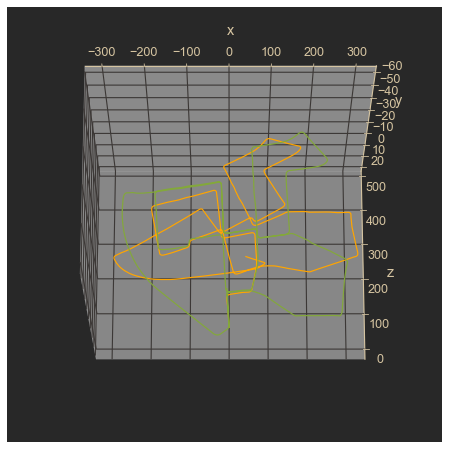

In [237]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(trajectory_nolidar_bm[:, :, 3][:, 0], 
        trajectory_nolidar_bm[:, :, 3][:, 1], 
        trajectory_nolidar_bm[:, :, 3][:, 2], label='estimated', color='orange')

ax.plot(handler.gt[:, :, 3][:, 0], 
        handler.gt[:, :, 3][:, 1], 
        handler.gt[:, :, 3][:, 2], label='ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=-20, azim=270)

In [239]:
calculate_error(handler.gt, trajectory_nolidar_bm, 'all')

{'mae': 45.73923911677966, 'rmse': 57.75198487016189, 'mse': 3335.291756443408}

We can see that our pose estimate drifts away from the ground truth, but that a lot of the shape is there. Let's compare these results to what we can get if we use lidar with StereoBM.

#### LIDAR depth correction with StereoBM disparity matching

In [187]:
# See what kind of results we get without using LIDAR correction on depth
handler.lidar = True
start = datetime.datetime.now()
trajectory_lidar_bm = visual_odometry(handler,
                                      filter_match_distance=0.5, 
                                      detector='sift',
                                      #matching='FLANN',
                                      stereo_matcher='bm',
                                      mask=mask,     
                                      subset=None)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)

Generating disparities with StereoBM
Detecting features with SIFT and matching with BF
Filtering feature matches at threshold of 0.5*distance
Improving stereo depth estimation with lidar data
Time to compute frame 1: 0:00:00.620517
Time to compute frame 2: 0:00:00.641613
Time to compute frame 3: 0:00:00.653045
Time to compute frame 4: 0:00:00.630107
Time to compute frame 5: 0:00:00.649253
Time to compute frame 6: 0:00:00.666213
Time to compute frame 7: 0:00:00.625055
Time to compute frame 8: 0:00:00.650035
Time to compute frame 9: 0:00:00.639999
Time to compute frame 10: 0:00:00.623217
Time to compute frame 11: 0:00:00.643522
Time to compute frame 12: 0:00:00.626000
Time to compute frame 13: 0:00:00.575999
Time to compute frame 14: 0:00:00.576997
Time to compute frame 15: 0:00:00.592515
Time to compute frame 16: 0:00:00.598001
Time to compute frame 17: 0:00:00.571582
Time to compute frame 18: 0:00:00.609521
Time to compute frame 19: 0:00:00.605028
Time to compute frame 20: 0:00:00.6106

Time to compute frame 195: 0:00:00.583687
Time to compute frame 196: 0:00:00.560998
Time to compute frame 197: 0:00:00.575584
Time to compute frame 198: 0:00:00.549000
Time to compute frame 199: 0:00:00.565000
Time to compute frame 200: 0:00:00.546128
Time to compute frame 201: 0:00:00.567704
Time to compute frame 202: 0:00:00.592865
Time to compute frame 203: 0:00:00.588010
Time to compute frame 204: 0:00:00.612617
Time to compute frame 205: 0:00:00.619510
Time to compute frame 206: 0:00:00.571193
Time to compute frame 207: 0:00:00.586041
Time to compute frame 208: 0:00:00.530788
Time to compute frame 209: 0:00:00.576056
Time to compute frame 210: 0:00:00.571043
Time to compute frame 211: 0:00:00.570521
Time to compute frame 212: 0:00:00.616088
Time to compute frame 213: 0:00:00.631518
Time to compute frame 214: 0:00:00.560513
Time to compute frame 215: 0:00:00.508003
Time to compute frame 216: 0:00:00.516553
Time to compute frame 217: 0:00:00.496999
Time to compute frame 218: 0:00:00

Time to compute frame 391: 0:00:00.484065
Time to compute frame 392: 0:00:00.510167
Time to compute frame 393: 0:00:00.490998
Time to compute frame 394: 0:00:00.460972
Time to compute frame 395: 0:00:00.455031
Time to compute frame 396: 0:00:00.459511
Time to compute frame 397: 0:00:00.480567
Time to compute frame 398: 0:00:00.465518
Time to compute frame 399: 0:00:00.466000
Time to compute frame 400: 0:00:00.457000
Time to compute frame 401: 0:00:00.474552
Time to compute frame 402: 0:00:00.455518
Time to compute frame 403: 0:00:00.473987
Time to compute frame 404: 0:00:00.438557
Time to compute frame 405: 0:00:00.482512
Time to compute frame 406: 0:00:00.499001
Time to compute frame 407: 0:00:00.492083
Time to compute frame 408: 0:00:00.460044
Time to compute frame 409: 0:00:00.475049
Time to compute frame 410: 0:00:00.494514
Time to compute frame 411: 0:00:00.473998
Time to compute frame 412: 0:00:00.454889
Time to compute frame 413: 0:00:00.466398
Time to compute frame 414: 0:00:00

Time to compute frame 587: 0:00:00.573077
Time to compute frame 588: 0:00:00.551067
Time to compute frame 589: 0:00:00.573612
Time to compute frame 590: 0:00:00.544038
Time to compute frame 591: 0:00:00.559996
Time to compute frame 592: 0:00:00.551049
Time to compute frame 593: 0:00:00.541431
Time to compute frame 594: 0:00:00.558639
Time to compute frame 595: 0:00:00.591253
Time to compute frame 596: 0:00:00.579998
Time to compute frame 597: 0:00:00.564073
Time to compute frame 598: 0:00:00.572513
Time to compute frame 599: 0:00:00.607041
Time to compute frame 600: 0:00:00.580559
Time to compute frame 601: 0:00:00.564997
Time to compute frame 602: 0:00:00.611034
Time to compute frame 603: 0:00:00.583041
Time to compute frame 604: 0:00:00.546519
Time to compute frame 605: 0:00:00.549000
Time to compute frame 606: 0:00:00.568049
Time to compute frame 607: 0:00:00.550998
Time to compute frame 608: 0:00:00.510554
Time to compute frame 609: 0:00:00.540103
Time to compute frame 610: 0:00:00

Time to compute frame 783: 0:00:00.622033
Time to compute frame 784: 0:00:00.615047
Time to compute frame 785: 0:00:00.648239
Time to compute frame 786: 0:00:00.591597
Time to compute frame 787: 0:00:00.584732
Time to compute frame 788: 0:00:00.592059
Time to compute frame 789: 0:00:00.570998
Time to compute frame 790: 0:00:00.572617
Time to compute frame 791: 0:00:00.575995
Time to compute frame 792: 0:00:00.582677
Time to compute frame 793: 0:00:00.593017
Time to compute frame 794: 0:00:00.594568
Time to compute frame 795: 0:00:00.585002
Time to compute frame 796: 0:00:00.603170
Time to compute frame 797: 0:00:00.580040
Time to compute frame 798: 0:00:00.614999
Time to compute frame 799: 0:00:00.624998
Time to compute frame 800: 0:00:00.604997
Time to compute frame 801: 0:00:00.621125
Time to compute frame 802: 0:00:00.620000
Time to compute frame 803: 0:00:00.600555
Time to compute frame 804: 0:00:00.580068
Time to compute frame 805: 0:00:00.601567
Time to compute frame 806: 0:00:00

Time to compute frame 979: 0:00:00.602010
Time to compute frame 980: 0:00:00.589019
Time to compute frame 981: 0:00:00.622161
Time to compute frame 982: 0:00:00.590529
Time to compute frame 983: 0:00:00.577540
Time to compute frame 984: 0:00:00.571070
Time to compute frame 985: 0:00:00.581514
Time to compute frame 986: 0:00:00.587050
Time to compute frame 987: 0:00:00.547042
Time to compute frame 988: 0:00:00.571159
Time to compute frame 989: 0:00:00.555998
Time to compute frame 990: 0:00:00.563118
Time to compute frame 991: 0:00:00.576997
Time to compute frame 992: 0:00:00.549137
Time to compute frame 993: 0:00:00.608996
Time to compute frame 994: 0:00:00.590115
Time to compute frame 995: 0:00:00.570554
Time to compute frame 996: 0:00:00.566033
Time to compute frame 997: 0:00:00.573025
Time to compute frame 998: 0:00:00.611154
Time to compute frame 999: 0:00:00.634156
Time to compute frame 1000: 0:00:00.607448
Time to compute frame 1001: 0:00:00.623071
Time to compute frame 1002: 0:00

Time to compute frame 1171: 0:00:00.670037
Time to compute frame 1172: 0:00:00.667586
Time to compute frame 1173: 0:00:00.593044
Time to compute frame 1174: 0:00:00.624629
Time to compute frame 1175: 0:00:00.613104
Time to compute frame 1176: 0:00:00.663133
Time to compute frame 1177: 0:00:00.710044
Time to compute frame 1178: 0:00:00.629998
Time to compute frame 1179: 0:00:00.658304
Time to compute frame 1180: 0:00:00.671999
Time to compute frame 1181: 0:00:00.721000
Time to compute frame 1182: 0:00:00.660149
Time to compute frame 1183: 0:00:00.691163
Time to compute frame 1184: 0:00:00.710565
Time to compute frame 1185: 0:00:00.681543
Time to compute frame 1186: 0:00:00.726029
Time to compute frame 1187: 0:00:00.732605
Time to compute frame 1188: 0:00:00.740640
Time to compute frame 1189: 0:00:00.778037
Time to compute frame 1190: 0:00:00.727043
Time to compute frame 1191: 0:00:00.956638
Time to compute frame 1192: 0:00:00.692070
Time to compute frame 1193: 0:00:00.616037
Time to com

Time to compute frame 1362: 0:00:01.651646
Time to compute frame 1363: 0:00:01.634854
Time to compute frame 1364: 0:00:01.640443
Time to compute frame 1365: 0:00:01.558183
Time to compute frame 1366: 0:00:01.521099
Time to compute frame 1367: 0:00:01.707266
Time to compute frame 1368: 0:00:01.623190
Time to compute frame 1369: 0:00:01.493400
Time to compute frame 1370: 0:00:01.499953
Time to compute frame 1371: 0:00:01.538780
Time to compute frame 1372: 0:00:01.519649
Time to compute frame 1373: 0:00:01.510288
Time to compute frame 1374: 0:00:01.483293
Time to compute frame 1375: 0:00:01.788528
Time to compute frame 1376: 0:00:01.753752
Time to compute frame 1377: 0:00:01.677664
Time to compute frame 1378: 0:00:01.553102
Time to compute frame 1379: 0:00:01.737343
Time to compute frame 1380: 0:00:01.667782
Time to compute frame 1381: 0:00:01.750543
Time to compute frame 1382: 0:00:02.079050
Time to compute frame 1383: 0:00:01.940338
Time to compute frame 1384: 0:00:01.954343
Time to com

Time to compute frame 1553: 0:00:00.519001
Time to compute frame 1554: 0:00:00.495001
Time to compute frame 1555: 0:00:00.527999
Time to compute frame 1556: 0:00:00.486997
Time to compute frame 1557: 0:00:00.497000
Time to compute frame 1558: 0:00:00.559000
Time to compute frame 1559: 0:00:00.521002
Time to compute frame 1560: 0:00:00.488998
Time to compute frame 1561: 0:00:00.500000
Time to compute frame 1562: 0:00:00.510996
Time to compute frame 1563: 0:00:00.506995
Time to compute frame 1564: 0:00:00.546997
Time to compute frame 1565: 0:00:00.530999
Time to compute frame 1566: 0:00:00.556997
Time to compute frame 1567: 0:00:00.537997
Time to compute frame 1568: 0:00:00.560998
Time to compute frame 1569: 0:00:00.590000
Time to compute frame 1570: 0:00:00.585998
Time to compute frame 1571: 0:00:00.575999
Time to compute frame 1572: 0:00:00.587999
Time to compute frame 1573: 0:00:00.586001
Time to compute frame 1574: 0:00:00.564998
Time to compute frame 1575: 0:00:00.569997
Time to com

Time to compute frame 1744: 0:00:00.523000
Time to compute frame 1745: 0:00:00.526996
Time to compute frame 1746: 0:00:00.508001
Time to compute frame 1747: 0:00:00.513996
Time to compute frame 1748: 0:00:00.573002
Time to compute frame 1749: 0:00:00.556996
Time to compute frame 1750: 0:00:00.596001
Time to compute frame 1751: 0:00:00.656000
Time to compute frame 1752: 0:00:00.630002
Time to compute frame 1753: 0:00:00.661996
Time to compute frame 1754: 0:00:00.690998
Time to compute frame 1755: 0:00:00.619999
Time to compute frame 1756: 0:00:00.636998
Time to compute frame 1757: 0:00:00.619000
Time to compute frame 1758: 0:00:00.667998
Time to compute frame 1759: 0:00:00.586998
Time to compute frame 1760: 0:00:00.553002
Time to compute frame 1761: 0:00:00.550000
Time to compute frame 1762: 0:00:00.545997
Time to compute frame 1763: 0:00:00.548998
Time to compute frame 1764: 0:00:00.591999
Time to compute frame 1765: 0:00:00.545996
Time to compute frame 1766: 0:00:00.603003
Time to com

Time to compute frame 1935: 0:00:00.510999
Time to compute frame 1936: 0:00:00.535995
Time to compute frame 1937: 0:00:00.520998
Time to compute frame 1938: 0:00:00.524001
Time to compute frame 1939: 0:00:00.508012
Time to compute frame 1940: 0:00:00.521000
Time to compute frame 1941: 0:00:00.509000
Time to compute frame 1942: 0:00:00.512997
Time to compute frame 1943: 0:00:00.516003
Time to compute frame 1944: 0:00:00.516042
Time to compute frame 1945: 0:00:00.521997
Time to compute frame 1946: 0:00:00.537001
Time to compute frame 1947: 0:00:00.539999
Time to compute frame 1948: 0:00:00.743998
Time to compute frame 1949: 0:00:00.541003
Time to compute frame 1950: 0:00:00.548994
Time to compute frame 1951: 0:00:00.658998
Time to compute frame 1952: 0:00:00.685041
Time to compute frame 1953: 0:00:00.689999
Time to compute frame 1954: 0:00:00.617003
Time to compute frame 1955: 0:00:00.614997
Time to compute frame 1956: 0:00:00.591998
Time to compute frame 1957: 0:00:00.566995
Time to com

Time to compute frame 2126: 0:00:00.585998
Time to compute frame 2127: 0:00:00.566999
Time to compute frame 2128: 0:00:00.555998
Time to compute frame 2129: 0:00:00.543997
Time to compute frame 2130: 0:00:00.544998
Time to compute frame 2131: 0:00:00.533997
Time to compute frame 2132: 0:00:00.569996
Time to compute frame 2133: 0:00:00.561997
Time to compute frame 2134: 0:00:00.523998
Time to compute frame 2135: 0:00:00.532001
Time to compute frame 2136: 0:00:00.526997
Time to compute frame 2137: 0:00:00.501998
Time to compute frame 2138: 0:00:00.513001
Time to compute frame 2139: 0:00:00.491995
Time to compute frame 2140: 0:00:00.516999
Time to compute frame 2141: 0:00:00.487000
Time to compute frame 2142: 0:00:00.503999
Time to compute frame 2143: 0:00:00.505999
Time to compute frame 2144: 0:00:00.509003
Time to compute frame 2145: 0:00:00.511990
Time to compute frame 2146: 0:00:00.507998
Time to compute frame 2147: 0:00:00.514004
Time to compute frame 2148: 0:00:00.501999
Time to com

Time to compute frame 2317: 0:00:00.843004
Time to compute frame 2318: 0:00:00.813997
Time to compute frame 2319: 0:00:00.821001
Time to compute frame 2320: 0:00:00.776995
Time to compute frame 2321: 0:00:00.792994
Time to compute frame 2322: 0:00:00.802001
Time to compute frame 2323: 0:00:00.816001
Time to compute frame 2324: 0:00:00.837998
Time to compute frame 2325: 0:00:01.007001
Time to compute frame 2326: 0:00:00.789996
Time to compute frame 2327: 0:00:00.754996
Time to compute frame 2328: 0:00:00.781995
Time to compute frame 2329: 0:00:00.748002
Time to compute frame 2330: 0:00:00.753996
Time to compute frame 2331: 0:00:00.776996
Time to compute frame 2332: 0:00:00.758998
Time to compute frame 2333: 0:00:00.812033
Time to compute frame 2334: 0:00:00.772993
Time to compute frame 2335: 0:00:00.734998
Time to compute frame 2336: 0:00:00.718997
Time to compute frame 2337: 0:00:00.700999
Time to compute frame 2338: 0:00:00.647995
Time to compute frame 2339: 0:00:00.665999
Time to com

Time to compute frame 2508: 0:00:00.485000
Time to compute frame 2509: 0:00:00.458002
Time to compute frame 2510: 0:00:00.476995
Time to compute frame 2511: 0:00:00.473998
Time to compute frame 2512: 0:00:00.479999
Time to compute frame 2513: 0:00:00.491997
Time to compute frame 2514: 0:00:00.490996
Time to compute frame 2515: 0:00:00.513997
Time to compute frame 2516: 0:00:00.541995
Time to compute frame 2517: 0:00:00.543004
Time to compute frame 2518: 0:00:00.487001
Time to compute frame 2519: 0:00:00.461995
Time to compute frame 2520: 0:00:00.480000
Time to compute frame 2521: 0:00:00.474000
Time to compute frame 2522: 0:00:00.496997
Time to compute frame 2523: 0:00:00.499996
Time to compute frame 2524: 0:00:00.487000
Time to compute frame 2525: 0:00:00.518003
Time to compute frame 2526: 0:00:00.489997
Time to compute frame 2527: 0:00:00.478998
Time to compute frame 2528: 0:00:00.482995
Time to compute frame 2529: 0:00:00.486004
Time to compute frame 2530: 0:00:00.480997
Time to com

Time to compute frame 2699: 0:00:00.555997
Time to compute frame 2700: 0:00:00.582002
Time to compute frame 2701: 0:00:00.558995
Time to compute frame 2702: 0:00:00.575996
Time to compute frame 2703: 0:00:00.541003
Time to compute frame 2704: 0:00:00.542998
Time to compute frame 2705: 0:00:00.509992
Time to compute frame 2706: 0:00:00.538001
Time to compute frame 2707: 0:00:00.501998
Time to compute frame 2708: 0:00:00.522007
Time to compute frame 2709: 0:00:00.513000
Time to compute frame 2710: 0:00:00.515998
Time to compute frame 2711: 0:00:00.524001
Time to compute frame 2712: 0:00:00.532999
Time to compute frame 2713: 0:00:00.503998
Time to compute frame 2714: 0:00:00.526993
Time to compute frame 2715: 0:00:00.530998
Time to compute frame 2716: 0:00:00.531001
Time to compute frame 2717: 0:00:00.544998
Time to compute frame 2718: 0:00:00.531920
Time to compute frame 2719: 0:00:00.553000
Time to compute frame 2720: 0:00:00.529002
Time to compute frame 2721: 0:00:00.516998
Time to com

Time to compute frame 2890: 0:00:00.526995
Time to compute frame 2891: 0:00:00.526004
Time to compute frame 2892: 0:00:00.507997
Time to compute frame 2893: 0:00:00.527997
Time to compute frame 2894: 0:00:00.504997
Time to compute frame 2895: 0:00:00.501994
Time to compute frame 2896: 0:00:00.499999
Time to compute frame 2897: 0:00:00.497003
Time to compute frame 2898: 0:00:00.505992
Time to compute frame 2899: 0:00:00.495001
Time to compute frame 2900: 0:00:00.497996
Time to compute frame 2901: 0:00:00.477997
Time to compute frame 2902: 0:00:00.475001
Time to compute frame 2903: 0:00:00.487999
Time to compute frame 2904: 0:00:00.465997
Time to compute frame 2905: 0:00:00.480001
Time to compute frame 2906: 0:00:00.476999
Time to compute frame 2907: 0:00:00.512999
Time to compute frame 2908: 0:00:00.494001
Time to compute frame 2909: 0:00:00.498001
Time to compute frame 2910: 0:00:00.495000
Time to compute frame 2911: 0:00:00.472999
Time to compute frame 2912: 0:00:00.475001
Time to com

Time to compute frame 3081: 0:00:00.504001
Time to compute frame 3082: 0:00:00.501001
Time to compute frame 3083: 0:00:00.508001
Time to compute frame 3084: 0:00:00.530998
Time to compute frame 3085: 0:00:00.520996
Time to compute frame 3086: 0:00:00.543995
Time to compute frame 3087: 0:00:00.514000
Time to compute frame 3088: 0:00:00.548993
Time to compute frame 3089: 0:00:00.543996
Time to compute frame 3090: 0:00:00.534996
Time to compute frame 3091: 0:00:00.526998
Time to compute frame 3092: 0:00:00.520997
Time to compute frame 3093: 0:00:00.535999
Time to compute frame 3094: 0:00:00.539996
Time to compute frame 3095: 0:00:00.571998
Time to compute frame 3096: 0:00:00.557997
Time to compute frame 3097: 0:00:00.554995
Time to compute frame 3098: 0:00:00.575004
Time to compute frame 3099: 0:00:00.556993
Time to compute frame 3100: 0:00:00.581999
Time to compute frame 3101: 0:00:00.568997
Time to compute frame 3102: 0:00:00.532000
Time to compute frame 3103: 0:00:00.574998
Time to com

Time to compute frame 3272: 0:00:00.457997
Time to compute frame 3273: 0:00:00.468002
Time to compute frame 3274: 0:00:00.465001
Time to compute frame 3275: 0:00:00.459000
Time to compute frame 3276: 0:00:00.502004
Time to compute frame 3277: 0:00:00.498999
Time to compute frame 3278: 0:00:00.503003
Time to compute frame 3279: 0:00:00.458993
Time to compute frame 3280: 0:00:00.507995
Time to compute frame 3281: 0:00:00.481997
Time to compute frame 3282: 0:00:00.507000
Time to compute frame 3283: 0:00:00.501992
Time to compute frame 3284: 0:00:00.510995
Time to compute frame 3285: 0:00:00.532001
Time to compute frame 3286: 0:00:00.545998
Time to compute frame 3287: 0:00:00.544998
Time to compute frame 3288: 0:00:00.608998
Time to compute frame 3289: 0:00:00.638995
Time to compute frame 3290: 0:00:00.584001
Time to compute frame 3291: 0:00:00.593999
Time to compute frame 3292: 0:00:00.579998
Time to compute frame 3293: 0:00:00.806511
Time to compute frame 3294: 0:00:00.653000
Time to com

Time to compute frame 3463: 0:00:00.500998
Time to compute frame 3464: 0:00:00.485003
Time to compute frame 3465: 0:00:00.486996
Time to compute frame 3466: 0:00:00.476524
Time to compute frame 3467: 0:00:00.511000
Time to compute frame 3468: 0:00:00.483997
Time to compute frame 3469: 0:00:00.492002
Time to compute frame 3470: 0:00:00.509096
Time to compute frame 3471: 0:00:00.492001
Time to compute frame 3472: 0:00:00.490994
Time to compute frame 3473: 0:00:00.535998
Time to compute frame 3474: 0:00:00.525998
Time to compute frame 3475: 0:00:00.551997
Time to compute frame 3476: 0:00:00.553516
Time to compute frame 3477: 0:00:00.532998
Time to compute frame 3478: 0:00:00.545517
Time to compute frame 3479: 0:00:00.563996
Time to compute frame 3480: 0:00:00.583288
Time to compute frame 3481: 0:00:00.586047
Time to compute frame 3482: 0:00:00.554895
Time to compute frame 3483: 0:00:00.513996
Time to compute frame 3484: 0:00:00.548000
Time to compute frame 3485: 0:00:00.547998
Time to com

Time to compute frame 3654: 0:00:00.548997
Time to compute frame 3655: 0:00:00.553002
Time to compute frame 3656: 0:00:00.824997
Time to compute frame 3657: 0:00:00.642997
Time to compute frame 3658: 0:00:00.530999
Time to compute frame 3659: 0:00:00.572999
Time to compute frame 3660: 0:00:00.542998
Time to compute frame 3661: 0:00:00.535000
Time to compute frame 3662: 0:00:00.531001
Time to compute frame 3663: 0:00:00.529999
Time to compute frame 3664: 0:00:00.535996
Time to compute frame 3665: 0:00:00.549004
Time to compute frame 3666: 0:00:00.564002
Time to compute frame 3667: 0:00:00.527996
Time to compute frame 3668: 0:00:00.602999
Time to compute frame 3669: 0:00:00.560999
Time to compute frame 3670: 0:00:00.544994
Time to compute frame 3671: 0:00:00.657996
Time to compute frame 3672: 0:00:00.571997
Time to compute frame 3673: 0:00:00.677003
Time to compute frame 3674: 0:00:00.562994
Time to compute frame 3675: 0:00:00.553002
Time to compute frame 3676: 0:00:00.638004
Time to com

Time to compute frame 3845: 0:00:00.564002
Time to compute frame 3846: 0:00:00.537997
Time to compute frame 3847: 0:00:00.524997
Time to compute frame 3848: 0:00:00.497997
Time to compute frame 3849: 0:00:00.509997
Time to compute frame 3850: 0:00:00.521002
Time to compute frame 3851: 0:00:00.526998
Time to compute frame 3852: 0:00:00.507000
Time to compute frame 3853: 0:00:00.495001
Time to compute frame 3854: 0:00:00.484998
Time to compute frame 3855: 0:00:00.500998
Time to compute frame 3856: 0:00:00.498997
Time to compute frame 3857: 0:00:00.500995
Time to compute frame 3858: 0:00:00.519212
Time to compute frame 3859: 0:00:00.517000
Time to compute frame 3860: 0:00:00.502000
Time to compute frame 3861: 0:00:00.517997
Time to compute frame 3862: 0:00:00.522998
Time to compute frame 3863: 0:00:00.515994
Time to compute frame 3864: 0:00:00.501999
Time to compute frame 3865: 0:00:00.519998
Time to compute frame 3866: 0:00:00.550996
Time to compute frame 3867: 0:00:00.525995
Time to com

Time to compute frame 4036: 0:00:00.578999
Time to compute frame 4037: 0:00:00.590997
Time to compute frame 4038: 0:00:00.607000
Time to compute frame 4039: 0:00:00.582004
Time to compute frame 4040: 0:00:00.574001
Time to compute frame 4041: 0:00:00.556516
Time to compute frame 4042: 0:00:00.556000
Time to compute frame 4043: 0:00:00.622000
Time to compute frame 4044: 0:00:00.612999
Time to compute frame 4045: 0:00:00.643000
Time to compute frame 4046: 0:00:00.620004
Time to compute frame 4047: 0:00:00.695048
Time to compute frame 4048: 0:00:00.792999
Time to compute frame 4049: 0:00:00.727999
Time to compute frame 4050: 0:00:00.730997
Time to compute frame 4051: 0:00:00.708002
Time to compute frame 4052: 0:00:00.757999
Time to compute frame 4053: 0:00:00.761523
Time to compute frame 4054: 0:00:00.635996
Time to compute frame 4055: 0:00:00.664999
Time to compute frame 4056: 0:00:00.767004
Time to compute frame 4057: 0:00:00.779000
Time to compute frame 4058: 0:00:00.736002
Time to com

Time to compute frame 4227: 0:00:00.586995
Time to compute frame 4228: 0:00:00.582000
Time to compute frame 4229: 0:00:00.547000
Time to compute frame 4230: 0:00:00.557999
Time to compute frame 4231: 0:00:00.594999
Time to compute frame 4232: 0:00:00.588999
Time to compute frame 4233: 0:00:00.592998
Time to compute frame 4234: 0:00:00.566996
Time to compute frame 4235: 0:00:00.570999
Time to compute frame 4236: 0:00:00.560001
Time to compute frame 4237: 0:00:00.599000
Time to compute frame 4238: 0:00:00.534999
Time to compute frame 4239: 0:00:00.541996
Time to compute frame 4240: 0:00:00.552009
Time to compute frame 4241: 0:00:00.513999
Time to compute frame 4242: 0:00:00.516998
Time to compute frame 4243: 0:00:00.503999
Time to compute frame 4244: 0:00:00.538034
Time to compute frame 4245: 0:00:00.512965
Time to compute frame 4246: 0:00:00.537000
Time to compute frame 4247: 0:00:00.513999
Time to compute frame 4248: 0:00:00.507999
Time to compute frame 4249: 0:00:00.531003
Time to com

Time to compute frame 4418: 0:00:00.514999
Time to compute frame 4419: 0:00:00.513000
Time to compute frame 4420: 0:00:00.530998
Time to compute frame 4421: 0:00:00.513001
Time to compute frame 4422: 0:00:00.533000
Time to compute frame 4423: 0:00:00.523995
Time to compute frame 4424: 0:00:00.501996
Time to compute frame 4425: 0:00:00.539998
Time to compute frame 4426: 0:00:00.519998
Time to compute frame 4427: 0:00:00.518000
Time to compute frame 4428: 0:00:00.486996
Time to compute frame 4429: 0:00:00.521002
Time to compute frame 4430: 0:00:00.498001
Time to compute frame 4431: 0:00:00.519997
Time to compute frame 4432: 0:00:00.511999
Time to compute frame 4433: 0:00:00.528998
Time to compute frame 4434: 0:00:00.507000
Time to compute frame 4435: 0:00:00.514002
Time to compute frame 4436: 0:00:00.525996
Time to compute frame 4437: 0:00:00.558004
Time to compute frame 4438: 0:00:00.534999
Time to compute frame 4439: 0:00:00.545996
Time to compute frame 4440: 0:00:00.550002
Time to com

In [83]:
%matplotlib notebook

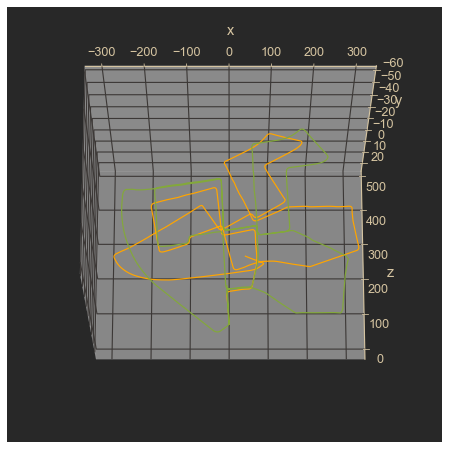

In [240]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(trajectory_lidar_bm[:, :, 3][:, 0], 
        trajectory_lidar_bm[:, :, 3][:, 1], 
        trajectory_lidar_bm[:, :, 3][:, 2], label='estimated', color='orange')

ax.plot(handler.gt[:, :, 3][:, 0], 
        handler.gt[:, :, 3][:, 1], 
        handler.gt[:, :, 3][:, 2], label='ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=-20, azim=270)

In [235]:
calculate_error(handler.gt, trajectory_lidar_bm, 'all')

{'mae': 45.0281267701467,
 'rmse': 56.544225204741444,
 'mse': 3197.2494040045176}

In [ ]:
# Adding the LIDAR correction to the depth has only improved our results slightly, but an
# improvement is there. We are underutilizing the LIDAR data by only projecting it onto the
# image plane, we could do much more by creating a localization map with it, but that will
# need to be saved for another day.

#### No LIDAR depth correction. StereoSGBM disparity matching.

In [241]:
# Let's see how we do with no lidar, using the SGBM stereo matcher
handler.lidar = False
start = datetime.datetime.now()
trajectory_nolidar_sgbm = visual_odometry(handler,
                                          filter_match_distance=0.5, 
                                          detector='sift',
                                          #matching='FLANN',
                                          stereo_matcher='sgbm',
                                          mask=mask,     
                                          subset=None)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)

Generating disparities with StereoSGBM
Detecting features with SIFT and matching with BF
Filtering feature matches at threshold of 0.5*distance
Time to compute frame 1: 0:00:00.572996
Time to compute frame 2: 0:00:00.574000
Time to compute frame 3: 0:00:00.587999
Time to compute frame 4: 0:00:00.592000
Time to compute frame 5: 0:00:00.620007
Time to compute frame 6: 0:00:00.608996
Time to compute frame 7: 0:00:00.586999
Time to compute frame 8: 0:00:00.584999
Time to compute frame 9: 0:00:00.595999
Time to compute frame 10: 0:00:00.577002
Time to compute frame 11: 0:00:00.555998
Time to compute frame 12: 0:00:00.552998
Time to compute frame 13: 0:00:00.562001
Time to compute frame 14: 0:00:00.521002
Time to compute frame 15: 0:00:00.537037
Time to compute frame 16: 0:00:00.524999
Time to compute frame 17: 0:00:00.511001
Time to compute frame 18: 0:00:00.626000
Time to compute frame 19: 0:00:00.583001
Time to compute frame 20: 0:00:00.615995
Time to compute frame 21: 0:00:00.605004
Time

Time to compute frame 196: 0:00:00.486520
Time to compute frame 197: 0:00:00.507004
Time to compute frame 198: 0:00:00.494997
Time to compute frame 199: 0:00:00.509001
Time to compute frame 200: 0:00:00.490000
Time to compute frame 201: 0:00:00.503073
Time to compute frame 202: 0:00:00.503998
Time to compute frame 203: 0:00:00.517000
Time to compute frame 204: 0:00:00.505999
Time to compute frame 205: 0:00:00.495998
Time to compute frame 206: 0:00:00.482000
Time to compute frame 207: 0:00:00.486004
Time to compute frame 208: 0:00:00.467000
Time to compute frame 209: 0:00:00.476000
Time to compute frame 210: 0:00:00.470998
Time to compute frame 211: 0:00:00.474997
Time to compute frame 212: 0:00:00.457999
Time to compute frame 213: 0:00:00.463002
Time to compute frame 214: 0:00:00.451001
Time to compute frame 215: 0:00:00.474998
Time to compute frame 216: 0:00:00.468999
Time to compute frame 217: 0:00:00.446000
Time to compute frame 218: 0:00:00.457003
Time to compute frame 219: 0:00:00

Time to compute frame 392: 0:00:00.432997
Time to compute frame 393: 0:00:00.439005
Time to compute frame 394: 0:00:00.423000
Time to compute frame 395: 0:00:00.418000
Time to compute frame 396: 0:00:00.429998
Time to compute frame 397: 0:00:00.402998
Time to compute frame 398: 0:00:00.446004
Time to compute frame 399: 0:00:00.419000
Time to compute frame 400: 0:00:00.422998
Time to compute frame 401: 0:00:00.432998
Time to compute frame 402: 0:00:00.416000
Time to compute frame 403: 0:00:00.415004
Time to compute frame 404: 0:00:00.622059
Time to compute frame 405: 0:00:00.421162
Time to compute frame 406: 0:00:00.417143
Time to compute frame 407: 0:00:00.440024
Time to compute frame 408: 0:00:00.414000
Time to compute frame 409: 0:00:00.441999
Time to compute frame 410: 0:00:00.413998
Time to compute frame 411: 0:00:00.408001
Time to compute frame 412: 0:00:00.431998
Time to compute frame 413: 0:00:00.420001
Time to compute frame 414: 0:00:00.421048
Time to compute frame 415: 0:00:00

Time to compute frame 588: 0:00:00.534999
Time to compute frame 589: 0:00:00.595002
Time to compute frame 590: 0:00:00.507994
Time to compute frame 591: 0:00:00.533999
Time to compute frame 592: 0:00:00.519000
Time to compute frame 593: 0:00:00.511998
Time to compute frame 594: 0:00:00.576999
Time to compute frame 595: 0:00:00.565999
Time to compute frame 596: 0:00:00.564999
Time to compute frame 597: 0:00:00.581000
Time to compute frame 598: 0:00:00.541001
Time to compute frame 599: 0:00:00.555003
Time to compute frame 600: 0:00:00.532003
Time to compute frame 601: 0:00:00.497995
Time to compute frame 602: 0:00:00.518999
Time to compute frame 603: 0:00:00.477996
Time to compute frame 604: 0:00:00.488999
Time to compute frame 605: 0:00:00.469999
Time to compute frame 606: 0:00:00.488002
Time to compute frame 607: 0:00:00.477999
Time to compute frame 608: 0:00:00.482998
Time to compute frame 609: 0:00:00.460997
Time to compute frame 610: 0:00:00.468000
Time to compute frame 611: 0:00:00

Time to compute frame 784: 0:00:00.577998
Time to compute frame 785: 0:00:00.558002
Time to compute frame 786: 0:00:00.544509
Time to compute frame 787: 0:00:00.557000
Time to compute frame 788: 0:00:00.519997
Time to compute frame 789: 0:00:00.517000
Time to compute frame 790: 0:00:00.544003
Time to compute frame 791: 0:00:00.540998
Time to compute frame 792: 0:00:00.524998
Time to compute frame 793: 0:00:00.544002
Time to compute frame 794: 0:00:00.548999
Time to compute frame 795: 0:00:00.550000
Time to compute frame 796: 0:00:00.532001
Time to compute frame 797: 0:00:00.551998
Time to compute frame 798: 0:00:00.579003
Time to compute frame 799: 0:00:00.554999
Time to compute frame 800: 0:00:00.543996
Time to compute frame 801: 0:00:00.553001
Time to compute frame 802: 0:00:00.570998
Time to compute frame 803: 0:00:00.530998
Time to compute frame 804: 0:00:00.536005
Time to compute frame 805: 0:00:00.532000
Time to compute frame 806: 0:00:00.552000
Time to compute frame 807: 0:00:00

Time to compute frame 980: 0:00:00.536000
Time to compute frame 981: 0:00:00.569000
Time to compute frame 982: 0:00:00.578028
Time to compute frame 983: 0:00:00.565335
Time to compute frame 984: 0:00:00.511020
Time to compute frame 985: 0:00:00.521960
Time to compute frame 986: 0:00:00.515105
Time to compute frame 987: 0:00:00.513675
Time to compute frame 988: 0:00:00.517001
Time to compute frame 989: 0:00:00.508310
Time to compute frame 990: 0:00:00.533938
Time to compute frame 991: 0:00:00.502997
Time to compute frame 992: 0:00:00.549002
Time to compute frame 993: 0:00:00.533028
Time to compute frame 994: 0:00:00.554999
Time to compute frame 995: 0:00:00.492441
Time to compute frame 996: 0:00:00.527001
Time to compute frame 997: 0:00:00.552994
Time to compute frame 998: 0:00:00.542002
Time to compute frame 999: 0:00:00.539996
Time to compute frame 1000: 0:00:00.560000
Time to compute frame 1001: 0:00:00.560996
Time to compute frame 1002: 0:00:00.521991
Time to compute frame 1003: 0:0

Time to compute frame 1171: 0:00:00.571002
Time to compute frame 1172: 0:00:00.580000
Time to compute frame 1173: 0:00:00.537781
Time to compute frame 1174: 0:00:00.538911
Time to compute frame 1175: 0:00:00.557522
Time to compute frame 1176: 0:00:00.564964
Time to compute frame 1177: 0:00:00.578999
Time to compute frame 1178: 0:00:00.640002
Time to compute frame 1179: 0:00:00.598000
Time to compute frame 1180: 0:00:00.578996
Time to compute frame 1181: 0:00:00.568999
Time to compute frame 1182: 0:00:00.602000
Time to compute frame 1183: 0:00:00.624996
Time to compute frame 1184: 0:00:00.600000
Time to compute frame 1185: 0:00:00.612997
Time to compute frame 1186: 0:00:00.622001
Time to compute frame 1187: 0:00:00.622999
Time to compute frame 1188: 0:00:00.654998
Time to compute frame 1189: 0:00:00.663003
Time to compute frame 1190: 0:00:00.656017
Time to compute frame 1191: 0:00:00.638620
Time to compute frame 1192: 0:00:00.650297
Time to compute frame 1193: 0:00:00.577950
Time to com

Time to compute frame 1362: 0:00:00.484000
Time to compute frame 1363: 0:00:00.500001
Time to compute frame 1364: 0:00:00.506998
Time to compute frame 1365: 0:00:00.470998
Time to compute frame 1366: 0:00:00.477002
Time to compute frame 1367: 0:00:00.459004
Time to compute frame 1368: 0:00:00.472001
Time to compute frame 1369: 0:00:00.504000
Time to compute frame 1370: 0:00:00.438007
Time to compute frame 1371: 0:00:00.435022
Time to compute frame 1372: 0:00:00.458000
Time to compute frame 1373: 0:00:00.428999
Time to compute frame 1374: 0:00:00.456004
Time to compute frame 1375: 0:00:00.455999
Time to compute frame 1376: 0:00:00.441003
Time to compute frame 1377: 0:00:00.422999
Time to compute frame 1378: 0:00:00.434003
Time to compute frame 1379: 0:00:00.445462
Time to compute frame 1380: 0:00:00.433021
Time to compute frame 1381: 0:00:00.437000
Time to compute frame 1382: 0:00:00.452001
Time to compute frame 1383: 0:00:00.440001
Time to compute frame 1384: 0:00:00.454966
Time to com

Time to compute frame 1553: 0:00:00.487003
Time to compute frame 1554: 0:00:00.473995
Time to compute frame 1555: 0:00:00.511009
Time to compute frame 1556: 0:00:00.472991
Time to compute frame 1557: 0:00:00.485044
Time to compute frame 1558: 0:00:00.458002
Time to compute frame 1559: 0:00:00.475000
Time to compute frame 1560: 0:00:00.467001
Time to compute frame 1561: 0:00:00.465999
Time to compute frame 1562: 0:00:00.458999
Time to compute frame 1563: 0:00:00.469998
Time to compute frame 1564: 0:00:00.493002
Time to compute frame 1565: 0:00:00.536002
Time to compute frame 1566: 0:00:00.511997
Time to compute frame 1567: 0:00:00.519002
Time to compute frame 1568: 0:00:00.531999
Time to compute frame 1569: 0:00:00.547001
Time to compute frame 1570: 0:00:00.537001
Time to compute frame 1571: 0:00:00.574001
Time to compute frame 1572: 0:00:00.551999
Time to compute frame 1573: 0:00:00.557001
Time to compute frame 1574: 0:00:00.547000
Time to compute frame 1575: 0:00:00.547996
Time to com

Time to compute frame 1744: 0:00:00.471001
Time to compute frame 1745: 0:00:00.506998
Time to compute frame 1746: 0:00:00.502999
Time to compute frame 1747: 0:00:00.500000
Time to compute frame 1748: 0:00:00.505002
Time to compute frame 1749: 0:00:00.553002
Time to compute frame 1750: 0:00:00.558995
Time to compute frame 1751: 0:00:00.552998
Time to compute frame 1752: 0:00:00.572998
Time to compute frame 1753: 0:00:00.580003
Time to compute frame 1754: 0:00:00.591999
Time to compute frame 1755: 0:00:00.544998
Time to compute frame 1756: 0:00:00.558002
Time to compute frame 1757: 0:00:00.559005
Time to compute frame 1758: 0:00:00.552996
Time to compute frame 1759: 0:00:00.545000
Time to compute frame 1760: 0:00:00.524003
Time to compute frame 1761: 0:00:00.532001
Time to compute frame 1762: 0:00:00.519000
Time to compute frame 1763: 0:00:00.516999
Time to compute frame 1764: 0:00:00.519001
Time to compute frame 1765: 0:00:00.518001
Time to compute frame 1766: 0:00:00.521997
Time to com

Time to compute frame 1935: 0:00:00.521999
Time to compute frame 1936: 0:00:00.510999
Time to compute frame 1937: 0:00:00.512999
Time to compute frame 1938: 0:00:00.517001
Time to compute frame 1939: 0:00:00.505001
Time to compute frame 1940: 0:00:00.517999
Time to compute frame 1941: 0:00:00.514000
Time to compute frame 1942: 0:00:00.524998
Time to compute frame 1943: 0:00:00.503999
Time to compute frame 1944: 0:00:00.535001
Time to compute frame 1945: 0:00:00.511000
Time to compute frame 1946: 0:00:00.540002
Time to compute frame 1947: 0:00:00.554000
Time to compute frame 1948: 0:00:00.585001
Time to compute frame 1949: 0:00:00.534995
Time to compute frame 1950: 0:00:00.525003
Time to compute frame 1951: 0:00:00.541018
Time to compute frame 1952: 0:00:00.541999
Time to compute frame 1953: 0:00:00.516999
Time to compute frame 1954: 0:00:00.507001
Time to compute frame 1955: 0:00:00.526001
Time to compute frame 1956: 0:00:00.520003
Time to compute frame 1957: 0:00:00.515994
Time to com

Time to compute frame 2126: 0:00:00.538031
Time to compute frame 2127: 0:00:00.539999
Time to compute frame 2128: 0:00:00.504001
Time to compute frame 2129: 0:00:00.525999
Time to compute frame 2130: 0:00:00.500998
Time to compute frame 2131: 0:00:00.470001
Time to compute frame 2132: 0:00:00.484002
Time to compute frame 2133: 0:00:00.504001
Time to compute frame 2134: 0:00:00.500996
Time to compute frame 2135: 0:00:00.499001
Time to compute frame 2136: 0:00:00.468998
Time to compute frame 2137: 0:00:00.494038
Time to compute frame 2138: 0:00:00.466001
Time to compute frame 2139: 0:00:00.457004
Time to compute frame 2140: 0:00:00.456001
Time to compute frame 2141: 0:00:00.479000
Time to compute frame 2142: 0:00:00.465000
Time to compute frame 2143: 0:00:00.549110
Time to compute frame 2144: 0:00:00.543998
Time to compute frame 2145: 0:00:00.546999
Time to compute frame 2146: 0:00:00.546000
Time to compute frame 2147: 0:00:00.546037
Time to compute frame 2148: 0:00:00.562510
Time to com

Time to compute frame 2317: 0:00:00.916999
Time to compute frame 2318: 0:00:00.896000
Time to compute frame 2319: 0:00:00.952531
Time to compute frame 2320: 0:00:01.009997
Time to compute frame 2321: 0:00:00.947001
Time to compute frame 2322: 0:00:00.943997
Time to compute frame 2323: 0:00:00.866999
Time to compute frame 2324: 0:00:00.873001
Time to compute frame 2325: 0:00:00.912001
Time to compute frame 2326: 0:00:00.843002
Time to compute frame 2327: 0:00:00.742016
Time to compute frame 2328: 0:00:00.741005
Time to compute frame 2329: 0:00:00.671999
Time to compute frame 2330: 0:00:00.718000
Time to compute frame 2331: 0:00:00.706057
Time to compute frame 2332: 0:00:00.690001
Time to compute frame 2333: 0:00:00.715995
Time to compute frame 2334: 0:00:00.702032
Time to compute frame 2335: 0:00:00.671999
Time to compute frame 2336: 0:00:00.656997
Time to compute frame 2337: 0:00:00.623000
Time to compute frame 2338: 0:00:00.603996
Time to compute frame 2339: 0:00:00.596000
Time to com

Time to compute frame 2508: 0:00:00.458998
Time to compute frame 2509: 0:00:00.485999
Time to compute frame 2510: 0:00:00.445001
Time to compute frame 2511: 0:00:00.455999
Time to compute frame 2512: 0:00:00.434001
Time to compute frame 2513: 0:00:00.453999
Time to compute frame 2514: 0:00:00.458000
Time to compute frame 2515: 0:00:00.441000
Time to compute frame 2516: 0:00:00.435997
Time to compute frame 2517: 0:00:00.440003
Time to compute frame 2518: 0:00:00.448000
Time to compute frame 2519: 0:00:00.437518
Time to compute frame 2520: 0:00:00.446043
Time to compute frame 2521: 0:00:00.429999
Time to compute frame 2522: 0:00:00.473002
Time to compute frame 2523: 0:00:00.488002
Time to compute frame 2524: 0:00:00.504001
Time to compute frame 2525: 0:00:00.496002
Time to compute frame 2526: 0:00:00.508998
Time to compute frame 2527: 0:00:00.498999
Time to compute frame 2528: 0:00:00.441004
Time to compute frame 2529: 0:00:00.452997
Time to compute frame 2530: 0:00:00.439001
Time to com

Time to compute frame 2699: 0:00:00.497996
Time to compute frame 2700: 0:00:00.517997
Time to compute frame 2701: 0:00:00.489996
Time to compute frame 2702: 0:00:00.474516
Time to compute frame 2703: 0:00:00.479002
Time to compute frame 2704: 0:00:00.478321
Time to compute frame 2705: 0:00:00.455000
Time to compute frame 2706: 0:00:00.455998
Time to compute frame 2707: 0:00:00.451998
Time to compute frame 2708: 0:00:00.465996
Time to compute frame 2709: 0:00:00.467000
Time to compute frame 2710: 0:00:00.455998
Time to compute frame 2711: 0:00:00.458000
Time to compute frame 2712: 0:00:00.470003
Time to compute frame 2713: 0:00:00.459001
Time to compute frame 2714: 0:00:00.483000
Time to compute frame 2715: 0:00:00.491001
Time to compute frame 2716: 0:00:00.483000
Time to compute frame 2717: 0:00:00.490998
Time to compute frame 2718: 0:00:00.480003
Time to compute frame 2719: 0:00:00.462001
Time to compute frame 2720: 0:00:00.477005
Time to compute frame 2721: 0:00:00.489997
Time to com

Time to compute frame 2890: 0:00:00.476998
Time to compute frame 2891: 0:00:00.448003
Time to compute frame 2892: 0:00:00.467031
Time to compute frame 2893: 0:00:00.449999
Time to compute frame 2894: 0:00:00.456998
Time to compute frame 2895: 0:00:00.438995
Time to compute frame 2896: 0:00:00.439002
Time to compute frame 2897: 0:00:00.460997
Time to compute frame 2898: 0:00:00.454001
Time to compute frame 2899: 0:00:00.453991
Time to compute frame 2900: 0:00:00.443000
Time to compute frame 2901: 0:00:00.435005
Time to compute frame 2902: 0:00:00.434995
Time to compute frame 2903: 0:00:00.437002
Time to compute frame 2904: 0:00:00.464996
Time to compute frame 2905: 0:00:00.424003
Time to compute frame 2906: 0:00:00.427999
Time to compute frame 2907: 0:00:00.430999
Time to compute frame 2908: 0:00:00.439999
Time to compute frame 2909: 0:00:00.414003
Time to compute frame 2910: 0:00:00.436524
Time to compute frame 2911: 0:00:00.413002
Time to compute frame 2912: 0:00:00.424996
Time to com

Time to compute frame 3081: 0:00:00.564998
Time to compute frame 3082: 0:00:00.465999
Time to compute frame 3083: 0:00:00.474017
Time to compute frame 3084: 0:00:00.487064
Time to compute frame 3085: 0:00:00.483047
Time to compute frame 3086: 0:00:00.480999
Time to compute frame 3087: 0:00:00.478592
Time to compute frame 3088: 0:00:00.473360
Time to compute frame 3089: 0:00:00.459999
Time to compute frame 3090: 0:00:00.521045
Time to compute frame 3091: 0:00:00.604998
Time to compute frame 3092: 0:00:00.622005
Time to compute frame 3093: 0:00:00.531995
Time to compute frame 3094: 0:00:00.522999
Time to compute frame 3095: 0:00:00.527002
Time to compute frame 3096: 0:00:00.594995
Time to compute frame 3097: 0:00:00.620000
Time to compute frame 3098: 0:00:00.660999
Time to compute frame 3099: 0:00:00.613997
Time to compute frame 3100: 0:00:00.541998
Time to compute frame 3101: 0:00:00.530000
Time to compute frame 3102: 0:00:00.511044
Time to compute frame 3103: 0:00:00.508997
Time to com

Time to compute frame 3272: 0:00:00.440000
Time to compute frame 3273: 0:00:00.444006
Time to compute frame 3274: 0:00:00.427003
Time to compute frame 3275: 0:00:00.437996
Time to compute frame 3276: 0:00:00.418003
Time to compute frame 3277: 0:00:00.438001
Time to compute frame 3278: 0:00:00.452001
Time to compute frame 3279: 0:00:00.445996
Time to compute frame 3280: 0:00:00.453001
Time to compute frame 3281: 0:00:00.465001
Time to compute frame 3282: 0:00:00.450997
Time to compute frame 3283: 0:00:00.453999
Time to compute frame 3284: 0:00:00.467002
Time to compute frame 3285: 0:00:00.480002
Time to compute frame 3286: 0:00:00.507996
Time to compute frame 3287: 0:00:00.518000
Time to compute frame 3288: 0:00:00.529010
Time to compute frame 3289: 0:00:00.536052
Time to compute frame 3290: 0:00:00.544999
Time to compute frame 3291: 0:00:00.557000
Time to compute frame 3292: 0:00:00.554000
Time to compute frame 3293: 0:00:00.586999
Time to compute frame 3294: 0:00:00.570002
Time to com

Time to compute frame 3463: 0:00:00.439999
Time to compute frame 3464: 0:00:00.440999
Time to compute frame 3465: 0:00:00.438004
Time to compute frame 3466: 0:00:00.432997
Time to compute frame 3467: 0:00:00.454003
Time to compute frame 3468: 0:00:00.498000
Time to compute frame 3469: 0:00:00.601001
Time to compute frame 3470: 0:00:00.716530
Time to compute frame 3471: 0:00:00.594003
Time to compute frame 3472: 0:00:00.606000
Time to compute frame 3473: 0:00:00.542998
Time to compute frame 3474: 0:00:00.477990
Time to compute frame 3475: 0:00:00.507000
Time to compute frame 3476: 0:00:00.505999
Time to compute frame 3477: 0:00:00.510998
Time to compute frame 3478: 0:00:00.521997
Time to compute frame 3479: 0:00:00.530031
Time to compute frame 3480: 0:00:00.535000
Time to compute frame 3481: 0:00:00.596999
Time to compute frame 3482: 0:00:00.502000
Time to compute frame 3483: 0:00:00.469999
Time to compute frame 3484: 0:00:00.480001
Time to compute frame 3485: 0:00:00.480000
Time to com

Time to compute frame 3654: 0:00:00.547998
Time to compute frame 3655: 0:00:00.515004
Time to compute frame 3656: 0:00:00.529998
Time to compute frame 3657: 0:00:00.528998
Time to compute frame 3658: 0:00:00.511998
Time to compute frame 3659: 0:00:00.591999
Time to compute frame 3660: 0:00:00.532000
Time to compute frame 3661: 0:00:00.513999
Time to compute frame 3662: 0:00:00.549003
Time to compute frame 3663: 0:00:00.534000
Time to compute frame 3664: 0:00:00.544997
Time to compute frame 3665: 0:00:00.534998
Time to compute frame 3666: 0:00:00.511002
Time to compute frame 3667: 0:00:00.500998
Time to compute frame 3668: 0:00:00.488003
Time to compute frame 3669: 0:00:00.531014
Time to compute frame 3670: 0:00:00.492999
Time to compute frame 3671: 0:00:00.548009
Time to compute frame 3672: 0:00:00.467412
Time to compute frame 3673: 0:00:00.503998
Time to compute frame 3674: 0:00:00.501994
Time to compute frame 3675: 0:00:00.481998
Time to compute frame 3676: 0:00:00.485001
Time to com

Time to compute frame 3845: 0:00:00.561004
Time to compute frame 3846: 0:00:00.523997
Time to compute frame 3847: 0:00:00.504997
Time to compute frame 3848: 0:00:00.486004
Time to compute frame 3849: 0:00:00.484000
Time to compute frame 3850: 0:00:00.510996
Time to compute frame 3851: 0:00:00.486003
Time to compute frame 3852: 0:00:00.482999
Time to compute frame 3853: 0:00:00.472995
Time to compute frame 3854: 0:00:00.477003
Time to compute frame 3855: 0:00:00.516997
Time to compute frame 3856: 0:00:00.488000
Time to compute frame 3857: 0:00:00.512999
Time to compute frame 3858: 0:00:00.486997
Time to compute frame 3859: 0:00:00.506998
Time to compute frame 3860: 0:00:00.499001
Time to compute frame 3861: 0:00:00.483996
Time to compute frame 3862: 0:00:00.475999
Time to compute frame 3863: 0:00:00.488523
Time to compute frame 3864: 0:00:00.477996
Time to compute frame 3865: 0:00:00.469996
Time to compute frame 3866: 0:00:00.486002
Time to compute frame 3867: 0:00:00.471001
Time to com

Time to compute frame 4036: 0:00:00.587995
Time to compute frame 4037: 0:00:00.519998
Time to compute frame 4038: 0:00:00.564004
Time to compute frame 4039: 0:00:00.546518
Time to compute frame 4040: 0:00:00.527000
Time to compute frame 4041: 0:00:00.528008
Time to compute frame 4042: 0:00:00.520000
Time to compute frame 4043: 0:00:00.517998
Time to compute frame 4044: 0:00:00.514002
Time to compute frame 4045: 0:00:00.536999
Time to compute frame 4046: 0:00:00.554006
Time to compute frame 4047: 0:00:00.560996
Time to compute frame 4048: 0:00:00.549005
Time to compute frame 4049: 0:00:00.785029
Time to compute frame 4050: 0:00:00.613964
Time to compute frame 4051: 0:00:00.541002
Time to compute frame 4052: 0:00:00.539000
Time to compute frame 4053: 0:00:00.519999
Time to compute frame 4054: 0:00:00.512002
Time to compute frame 4055: 0:00:00.545999
Time to compute frame 4056: 0:00:00.523518
Time to compute frame 4057: 0:00:00.539000
Time to compute frame 4058: 0:00:00.530998
Time to com

Time to compute frame 4227: 0:00:00.570050
Time to compute frame 4228: 0:00:00.616998
Time to compute frame 4229: 0:00:00.628002
Time to compute frame 4230: 0:00:00.574000
Time to compute frame 4231: 0:00:00.496995
Time to compute frame 4232: 0:00:00.530997
Time to compute frame 4233: 0:00:00.700003
Time to compute frame 4234: 0:00:00.522998
Time to compute frame 4235: 0:00:00.536998
Time to compute frame 4236: 0:00:00.527001
Time to compute frame 4237: 0:00:00.551000
Time to compute frame 4238: 0:00:00.540001
Time to compute frame 4239: 0:00:00.524999
Time to compute frame 4240: 0:00:00.510001
Time to compute frame 4241: 0:00:00.496997
Time to compute frame 4242: 0:00:00.468000
Time to compute frame 4243: 0:00:00.534000
Time to compute frame 4244: 0:00:00.557002
Time to compute frame 4245: 0:00:00.579996
Time to compute frame 4246: 0:00:00.611001
Time to compute frame 4247: 0:00:00.512999
Time to compute frame 4248: 0:00:00.548999
Time to compute frame 4249: 0:00:00.532002
Time to com

Time to compute frame 4418: 0:00:00.475999
Time to compute frame 4419: 0:00:00.464002
Time to compute frame 4420: 0:00:00.490001
Time to compute frame 4421: 0:00:00.494997
Time to compute frame 4422: 0:00:00.468002
Time to compute frame 4423: 0:00:00.467998
Time to compute frame 4424: 0:00:00.455004
Time to compute frame 4425: 0:00:00.489000
Time to compute frame 4426: 0:00:00.477000
Time to compute frame 4427: 0:00:00.516999
Time to compute frame 4428: 0:00:00.478001
Time to compute frame 4429: 0:00:00.494999
Time to compute frame 4430: 0:00:00.495997
Time to compute frame 4431: 0:00:00.519000
Time to compute frame 4432: 0:00:00.477001
Time to compute frame 4433: 0:00:00.490003
Time to compute frame 4434: 0:00:00.461999
Time to compute frame 4435: 0:00:00.486999
Time to compute frame 4436: 0:00:00.461989
Time to compute frame 4437: 0:00:00.483520
Time to compute frame 4438: 0:00:00.480997
Time to compute frame 4439: 0:00:00.485000
Time to compute frame 4440: 0:00:00.472997
Time to com

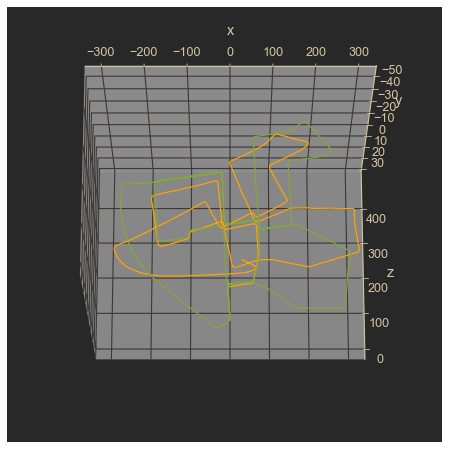

In [244]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(trajectory_nolidar_sgbm[:, :, 3][:, 0], 
        trajectory_nolidar_sgbm[:, :, 3][:, 1], 
        trajectory_nolidar_sgbm[:, :, 3][:, 2], label='estimated', color='orange')

ax.plot(handler.gt[:, :, 3][:, 0], 
        handler.gt[:, :, 3][:, 1], 
        handler.gt[:, :, 3][:, 2], label='ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=-20, azim=270)

In [245]:
calculate_error(handler.gt, trajectory_nolidar_sgbm, 'all')

{'mae': 37.49956249084715,
 'rmse': 47.029413729412965,
 'mse': 2211.765755732297}

We can see that using the StereoSGBM matching for disparity calculation has improved the results significantly, even using no LIDAR correction. Let's see if adding the LIDAR back in and using StereoSGBM can beat these results.

#### LIDAR depth correction, StereoSGBM disparity matching.

In [255]:
handler.lidar = True
start = datetime.datetime.now()
trajectory_lidar_sgbm = visual_odometry(handler, 
                                        filter_match_distance=0.5, 
                                        stereo_matcher='sgbm',
                                        mask=mask,
                                        subset=None)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)

Generating disparities with StereoSGBM
Detecting features with SIFT and matching with BF
Filtering feature matches at threshold of 0.5*distance
Improving stereo depth estimation with lidar data
Time to compute frame 1: 0:00:00.693000
Time to compute frame 2: 0:00:00.689002
Time to compute frame 3: 0:00:00.692998
Time to compute frame 4: 0:00:00.958005
Time to compute frame 5: 0:00:00.724996
Time to compute frame 6: 0:00:00.699998
Time to compute frame 7: 0:00:00.692000
Time to compute frame 8: 0:00:00.699996
Time to compute frame 9: 0:00:00.785044
Time to compute frame 10: 0:00:00.736997
Time to compute frame 11: 0:00:00.647999
Time to compute frame 12: 0:00:00.669006
Time to compute frame 13: 0:00:00.650997
Time to compute frame 14: 0:00:00.642998
Time to compute frame 15: 0:00:00.639003
Time to compute frame 16: 0:00:00.630999
Time to compute frame 17: 0:00:00.620001
Time to compute frame 18: 0:00:00.696997
Time to compute frame 19: 0:00:00.690003
Time to compute frame 20: 0:00:00.75

Time to compute frame 195: 0:00:00.618002
Time to compute frame 196: 0:00:00.634998
Time to compute frame 197: 0:00:00.628997
Time to compute frame 198: 0:00:00.616998
Time to compute frame 199: 0:00:00.618995
Time to compute frame 200: 0:00:00.633000
Time to compute frame 201: 0:00:00.591002
Time to compute frame 202: 0:00:00.626998
Time to compute frame 203: 0:00:00.632002
Time to compute frame 204: 0:00:00.662001
Time to compute frame 205: 0:00:00.690998
Time to compute frame 206: 0:00:00.696000
Time to compute frame 207: 0:00:00.694999
Time to compute frame 208: 0:00:00.651999
Time to compute frame 209: 0:00:00.701998
Time to compute frame 210: 0:00:00.630001
Time to compute frame 211: 0:00:00.604000
Time to compute frame 212: 0:00:00.611999
Time to compute frame 213: 0:00:00.572028
Time to compute frame 214: 0:00:00.567999
Time to compute frame 215: 0:00:00.653004
Time to compute frame 216: 0:00:00.580999
Time to compute frame 217: 0:00:00.651997
Time to compute frame 218: 0:00:00

Time to compute frame 391: 0:00:00.532530
Time to compute frame 392: 0:00:00.537995
Time to compute frame 393: 0:00:00.533008
Time to compute frame 394: 0:00:00.520996
Time to compute frame 395: 0:00:00.502992
Time to compute frame 396: 0:00:00.516002
Time to compute frame 397: 0:00:00.493030
Time to compute frame 398: 0:00:00.516034
Time to compute frame 399: 0:00:00.495995
Time to compute frame 400: 0:00:00.505003
Time to compute frame 401: 0:00:00.512001
Time to compute frame 402: 0:00:00.504000
Time to compute frame 403: 0:00:00.498999
Time to compute frame 404: 0:00:00.526999
Time to compute frame 405: 0:00:00.514000
Time to compute frame 406: 0:00:00.511998
Time to compute frame 407: 0:00:00.500000
Time to compute frame 408: 0:00:00.510001
Time to compute frame 409: 0:00:00.508030
Time to compute frame 410: 0:00:00.522997
Time to compute frame 411: 0:00:00.515006
Time to compute frame 412: 0:00:00.512995
Time to compute frame 413: 0:00:00.518008
Time to compute frame 414: 0:00:00

Time to compute frame 587: 0:00:00.588997
Time to compute frame 588: 0:00:00.585999
Time to compute frame 589: 0:00:00.604625
Time to compute frame 590: 0:00:00.584245
Time to compute frame 591: 0:00:00.599356
Time to compute frame 592: 0:00:00.586045
Time to compute frame 593: 0:00:00.607386
Time to compute frame 594: 0:00:00.588000
Time to compute frame 595: 0:00:00.588999
Time to compute frame 596: 0:00:00.589000
Time to compute frame 597: 0:00:00.595999
Time to compute frame 598: 0:00:00.600998
Time to compute frame 599: 0:00:00.572997
Time to compute frame 600: 0:00:00.566001
Time to compute frame 601: 0:00:00.570999
Time to compute frame 602: 0:00:00.572000
Time to compute frame 603: 0:00:00.567000
Time to compute frame 604: 0:00:00.566002
Time to compute frame 605: 0:00:00.563999
Time to compute frame 606: 0:00:00.546000
Time to compute frame 607: 0:00:00.545003
Time to compute frame 608: 0:00:00.537000
Time to compute frame 609: 0:00:00.534000
Time to compute frame 610: 0:00:00

Time to compute frame 783: 0:00:00.675999
Time to compute frame 784: 0:00:00.684000
Time to compute frame 785: 0:00:00.653046
Time to compute frame 786: 0:00:00.656996
Time to compute frame 787: 0:00:00.628000
Time to compute frame 788: 0:00:00.610002
Time to compute frame 789: 0:00:00.621000
Time to compute frame 790: 0:00:00.632001
Time to compute frame 791: 0:00:00.619032
Time to compute frame 792: 0:00:00.899009
Time to compute frame 793: 0:00:01.098997
Time to compute frame 794: 0:00:00.662999
Time to compute frame 795: 0:00:00.698000
Time to compute frame 796: 0:00:00.684000
Time to compute frame 797: 0:00:00.676998
Time to compute frame 798: 0:00:00.716999
Time to compute frame 799: 0:00:00.730998
Time to compute frame 800: 0:00:00.671002
Time to compute frame 801: 0:00:00.666000
Time to compute frame 802: 0:00:00.676998
Time to compute frame 803: 0:00:00.660001
Time to compute frame 804: 0:00:00.654002
Time to compute frame 805: 0:00:00.665002
Time to compute frame 806: 0:00:00

Time to compute frame 979: 0:00:00.625000
Time to compute frame 980: 0:00:00.635999
Time to compute frame 981: 0:00:00.624998
Time to compute frame 982: 0:00:00.639003
Time to compute frame 983: 0:00:00.648000
Time to compute frame 984: 0:00:00.807033
Time to compute frame 985: 0:00:00.595966
Time to compute frame 986: 0:00:00.634002
Time to compute frame 987: 0:00:00.603000
Time to compute frame 988: 0:00:00.670996
Time to compute frame 989: 0:00:00.621998
Time to compute frame 990: 0:00:00.583000
Time to compute frame 991: 0:00:00.583012
Time to compute frame 992: 0:00:00.604000
Time to compute frame 993: 0:00:00.572620
Time to compute frame 994: 0:00:00.598017
Time to compute frame 995: 0:00:00.611999
Time to compute frame 996: 0:00:00.612001
Time to compute frame 997: 0:00:00.619004
Time to compute frame 998: 0:00:00.642995
Time to compute frame 999: 0:00:00.678002
Time to compute frame 1000: 0:00:00.660001
Time to compute frame 1001: 0:00:00.636001
Time to compute frame 1002: 0:00

Time to compute frame 1171: 0:00:00.726000
Time to compute frame 1172: 0:00:00.659998
Time to compute frame 1173: 0:00:00.666002
Time to compute frame 1174: 0:00:00.673997
Time to compute frame 1175: 0:00:00.624005
Time to compute frame 1176: 0:00:00.629998
Time to compute frame 1177: 0:00:00.638002
Time to compute frame 1178: 0:00:00.646811
Time to compute frame 1179: 0:00:00.651998
Time to compute frame 1180: 0:00:00.685000
Time to compute frame 1181: 0:00:00.673005
Time to compute frame 1182: 0:00:00.696000
Time to compute frame 1183: 0:00:00.705999
Time to compute frame 1184: 0:00:00.700004
Time to compute frame 1185: 0:00:00.704996
Time to compute frame 1186: 0:00:00.739000
Time to compute frame 1187: 0:00:00.729998
Time to compute frame 1188: 0:00:00.739003
Time to compute frame 1189: 0:00:00.770996
Time to compute frame 1190: 0:00:00.763999
Time to compute frame 1191: 0:00:00.739998
Time to compute frame 1192: 0:00:00.683000
Time to compute frame 1193: 0:00:00.695000
Time to com

Time to compute frame 1362: 0:00:00.545932
Time to compute frame 1363: 0:00:00.575179
Time to compute frame 1364: 0:00:00.549327
Time to compute frame 1365: 0:00:00.543060
Time to compute frame 1366: 0:00:00.552392
Time to compute frame 1367: 0:00:00.538102
Time to compute frame 1368: 0:00:00.529000
Time to compute frame 1369: 0:00:00.531000
Time to compute frame 1370: 0:00:00.542088
Time to compute frame 1371: 0:00:00.530000
Time to compute frame 1372: 0:00:00.539000
Time to compute frame 1373: 0:00:00.511999
Time to compute frame 1374: 0:00:00.566345
Time to compute frame 1375: 0:00:00.563001
Time to compute frame 1376: 0:00:00.546490
Time to compute frame 1377: 0:00:00.546005
Time to compute frame 1378: 0:00:00.506030
Time to compute frame 1379: 0:00:00.523996
Time to compute frame 1380: 0:00:00.519001
Time to compute frame 1381: 0:00:00.559001
Time to compute frame 1382: 0:00:00.525996
Time to compute frame 1383: 0:00:00.531003
Time to compute frame 1384: 0:00:00.524000
Time to com

Time to compute frame 1553: 0:00:00.581001
Time to compute frame 1554: 0:00:00.581998
Time to compute frame 1555: 0:00:00.561000
Time to compute frame 1556: 0:00:00.557999
Time to compute frame 1557: 0:00:00.572004
Time to compute frame 1558: 0:00:00.566997
Time to compute frame 1559: 0:00:00.563001
Time to compute frame 1560: 0:00:00.568993
Time to compute frame 1561: 0:00:00.547002
Time to compute frame 1562: 0:00:00.562002
Time to compute frame 1563: 0:00:00.588001
Time to compute frame 1564: 0:00:00.583999
Time to compute frame 1565: 0:00:00.633034
Time to compute frame 1566: 0:00:00.614220
Time to compute frame 1567: 0:00:00.614045
Time to compute frame 1568: 0:00:00.660994
Time to compute frame 1569: 0:00:00.656043
Time to compute frame 1570: 0:00:00.659999
Time to compute frame 1571: 0:00:00.658065
Time to compute frame 1572: 0:00:00.649000
Time to compute frame 1573: 0:00:00.644767
Time to compute frame 1574: 0:00:00.668252
Time to compute frame 1575: 0:00:00.664003
Time to com

Time to compute frame 1744: 0:00:00.619996
Time to compute frame 1745: 0:00:00.635997
Time to compute frame 1746: 0:00:00.694003
Time to compute frame 1747: 0:00:00.632002
Time to compute frame 1748: 0:00:00.685004
Time to compute frame 1749: 0:00:00.710003
Time to compute frame 1750: 0:00:00.713999
Time to compute frame 1751: 0:00:00.715000
Time to compute frame 1752: 0:00:00.741998
Time to compute frame 1753: 0:00:00.761002
Time to compute frame 1754: 0:00:00.746003
Time to compute frame 1755: 0:00:00.723997
Time to compute frame 1756: 0:00:00.694998
Time to compute frame 1757: 0:00:00.714001
Time to compute frame 1758: 0:00:00.689039
Time to compute frame 1759: 0:00:00.701615
Time to compute frame 1760: 0:00:00.732000
Time to compute frame 1761: 0:00:00.695997
Time to compute frame 1762: 0:00:00.742002
Time to compute frame 1763: 0:00:00.673997
Time to compute frame 1764: 0:00:00.651998
Time to compute frame 1765: 0:00:00.683001
Time to compute frame 1766: 0:00:00.684002
Time to com

Time to compute frame 1935: 0:00:00.618004
Time to compute frame 1936: 0:00:00.649996
Time to compute frame 1937: 0:00:00.608999
Time to compute frame 1938: 0:00:00.612016
Time to compute frame 1939: 0:00:00.628003
Time to compute frame 1940: 0:00:00.590997
Time to compute frame 1941: 0:00:00.618999
Time to compute frame 1942: 0:00:00.610999
Time to compute frame 1943: 0:00:00.629520
Time to compute frame 1944: 0:00:00.622002
Time to compute frame 1945: 0:00:00.629004
Time to compute frame 1946: 0:00:00.688997
Time to compute frame 1947: 0:00:00.642997
Time to compute frame 1948: 0:00:00.630003
Time to compute frame 1949: 0:00:00.628997
Time to compute frame 1950: 0:00:00.651999
Time to compute frame 1951: 0:00:00.628041
Time to compute frame 1952: 0:00:00.641999
Time to compute frame 1953: 0:00:00.671998
Time to compute frame 1954: 0:00:00.626004
Time to compute frame 1955: 0:00:00.647513
Time to compute frame 1956: 0:00:00.620999
Time to compute frame 1957: 0:00:00.641997
Time to com

Time to compute frame 2126: 0:00:00.682007
Time to compute frame 2127: 0:00:00.643000
Time to compute frame 2128: 0:00:00.667520
Time to compute frame 2129: 0:00:00.683004
Time to compute frame 2130: 0:00:00.670003
Time to compute frame 2131: 0:00:00.625030
Time to compute frame 2132: 0:00:00.635996
Time to compute frame 2133: 0:00:00.625681
Time to compute frame 2134: 0:00:00.643998
Time to compute frame 2135: 0:00:00.666003
Time to compute frame 2136: 0:00:00.652021
Time to compute frame 2137: 0:00:00.609999
Time to compute frame 2138: 0:00:00.817000
Time to compute frame 2139: 0:00:00.590000
Time to compute frame 2140: 0:00:00.599001
Time to compute frame 2141: 0:00:00.612989
Time to compute frame 2142: 0:00:00.622998
Time to compute frame 2143: 0:00:00.580613
Time to compute frame 2144: 0:00:00.589999
Time to compute frame 2145: 0:00:00.640003
Time to compute frame 2146: 0:00:00.600999
Time to compute frame 2147: 0:00:00.602998
Time to compute frame 2148: 0:00:00.612001
Time to com

Time to compute frame 2317: 0:00:00.819003
Time to compute frame 2318: 0:00:00.797998
Time to compute frame 2319: 0:00:00.839000
Time to compute frame 2320: 0:00:00.799999
Time to compute frame 2321: 0:00:00.790999
Time to compute frame 2322: 0:00:00.788999
Time to compute frame 2323: 0:00:00.806997
Time to compute frame 2324: 0:00:00.845000
Time to compute frame 2325: 0:00:00.799998
Time to compute frame 2326: 0:00:00.804999
Time to compute frame 2327: 0:00:00.777998
Time to compute frame 2328: 0:00:00.769999
Time to compute frame 2329: 0:00:00.785000
Time to compute frame 2330: 0:00:00.746996
Time to compute frame 2331: 0:00:00.764000
Time to compute frame 2332: 0:00:00.816999
Time to compute frame 2333: 0:00:00.779828
Time to compute frame 2334: 0:00:00.766000
Time to compute frame 2335: 0:00:00.753999
Time to compute frame 2336: 0:00:00.745999
Time to compute frame 2337: 0:00:00.687000
Time to compute frame 2338: 0:00:00.686001
Time to compute frame 2339: 0:00:00.684001
Time to com

Time to compute frame 2508: 0:00:00.527035
Time to compute frame 2509: 0:00:00.516029
Time to compute frame 2510: 0:00:00.523999
Time to compute frame 2511: 0:00:00.528002
Time to compute frame 2512: 0:00:00.503999
Time to compute frame 2513: 0:00:00.550999
Time to compute frame 2514: 0:00:00.526031
Time to compute frame 2515: 0:00:00.514983
Time to compute frame 2516: 0:00:00.536161
Time to compute frame 2517: 0:00:00.518960
Time to compute frame 2518: 0:00:00.527998
Time to compute frame 2519: 0:00:00.522998
Time to compute frame 2520: 0:00:00.528604
Time to compute frame 2521: 0:00:00.515998
Time to compute frame 2522: 0:00:00.534563
Time to compute frame 2523: 0:00:00.541001
Time to compute frame 2524: 0:00:00.541048
Time to compute frame 2525: 0:00:00.553003
Time to compute frame 2526: 0:00:00.532997
Time to compute frame 2527: 0:00:00.541467
Time to compute frame 2528: 0:00:00.523016
Time to compute frame 2529: 0:00:00.521998
Time to compute frame 2530: 0:00:00.538001
Time to com

Time to compute frame 2699: 0:00:00.616999
Time to compute frame 2700: 0:00:00.602004
Time to compute frame 2701: 0:00:00.583994
Time to compute frame 2702: 0:00:00.569000
Time to compute frame 2703: 0:00:00.566997
Time to compute frame 2704: 0:00:00.576000
Time to compute frame 2705: 0:00:00.562004
Time to compute frame 2706: 0:00:00.548000
Time to compute frame 2707: 0:00:00.541998
Time to compute frame 2708: 0:00:00.558001
Time to compute frame 2709: 0:00:00.553999
Time to compute frame 2710: 0:00:00.542000
Time to compute frame 2711: 0:00:00.535000
Time to compute frame 2712: 0:00:00.573001
Time to compute frame 2713: 0:00:00.577998
Time to compute frame 2714: 0:00:00.549998
Time to compute frame 2715: 0:00:00.570000
Time to compute frame 2716: 0:00:00.558997
Time to compute frame 2717: 0:00:00.593006
Time to compute frame 2718: 0:00:00.587996
Time to compute frame 2719: 0:00:00.565999
Time to compute frame 2720: 0:00:00.570999
Time to compute frame 2721: 0:00:00.588000
Time to com

Time to compute frame 2890: 0:00:00.541001
Time to compute frame 2891: 0:00:00.588003
Time to compute frame 2892: 0:00:00.547000
Time to compute frame 2893: 0:00:00.540000
Time to compute frame 2894: 0:00:00.547000
Time to compute frame 2895: 0:00:00.533036
Time to compute frame 2896: 0:00:00.539998
Time to compute frame 2897: 0:00:00.509001
Time to compute frame 2898: 0:00:00.556003
Time to compute frame 2899: 0:00:00.539001
Time to compute frame 2900: 0:00:00.543998
Time to compute frame 2901: 0:00:00.527030
Time to compute frame 2902: 0:00:00.536999
Time to compute frame 2903: 0:00:00.518997
Time to compute frame 2904: 0:00:00.543001
Time to compute frame 2905: 0:00:00.516005
Time to compute frame 2906: 0:00:00.507040
Time to compute frame 2907: 0:00:00.545031
Time to compute frame 2908: 0:00:00.504970
Time to compute frame 2909: 0:00:00.527998
Time to compute frame 2910: 0:00:00.541001
Time to compute frame 2911: 0:00:00.530030
Time to compute frame 2912: 0:00:00.512002
Time to com

Time to compute frame 3081: 0:00:00.580998
Time to compute frame 3082: 0:00:00.588999
Time to compute frame 3083: 0:00:00.596004
Time to compute frame 3084: 0:00:00.584994
Time to compute frame 3085: 0:00:00.592997
Time to compute frame 3086: 0:00:00.551999
Time to compute frame 3087: 0:00:00.567630
Time to compute frame 3088: 0:00:00.572974
Time to compute frame 3089: 0:00:00.584108
Time to compute frame 3090: 0:00:00.585091
Time to compute frame 3091: 0:00:00.588379
Time to compute frame 3092: 0:00:00.588514
Time to compute frame 3093: 0:00:00.561599
Time to compute frame 3094: 0:00:00.606998
Time to compute frame 3095: 0:00:00.605003
Time to compute frame 3096: 0:00:00.580063
Time to compute frame 3097: 0:00:00.563000
Time to compute frame 3098: 0:00:00.594001
Time to compute frame 3099: 0:00:00.628997
Time to compute frame 3100: 0:00:00.601997
Time to compute frame 3101: 0:00:00.614998
Time to compute frame 3102: 0:00:00.597999
Time to compute frame 3103: 0:00:00.592000
Time to com

Time to compute frame 3272: 0:00:00.489001
Time to compute frame 3273: 0:00:00.500004
Time to compute frame 3274: 0:00:00.507997
Time to compute frame 3275: 0:00:00.495005
Time to compute frame 3276: 0:00:00.540995
Time to compute frame 3277: 0:00:00.489033
Time to compute frame 3278: 0:00:00.505998
Time to compute frame 3279: 0:00:00.505999
Time to compute frame 3280: 0:00:00.526000
Time to compute frame 3281: 0:00:00.533001
Time to compute frame 3282: 0:00:00.516999
Time to compute frame 3283: 0:00:00.533004
Time to compute frame 3284: 0:00:00.559999
Time to compute frame 3285: 0:00:00.550999
Time to compute frame 3286: 0:00:00.565998
Time to compute frame 3287: 0:00:00.586999
Time to compute frame 3288: 0:00:00.612999
Time to compute frame 3289: 0:00:00.627998
Time to compute frame 3290: 0:00:00.621001
Time to compute frame 3291: 0:00:00.624000
Time to compute frame 3292: 0:00:00.640000
Time to compute frame 3293: 0:00:00.686003
Time to compute frame 3294: 0:00:00.652999
Time to com

Time to compute frame 3463: 0:00:00.508998
Time to compute frame 3464: 0:00:00.522049
Time to compute frame 3465: 0:00:00.528002
Time to compute frame 3466: 0:00:00.528003
Time to compute frame 3467: 0:00:00.535030
Time to compute frame 3468: 0:00:00.546996
Time to compute frame 3469: 0:00:00.536001
Time to compute frame 3470: 0:00:00.547000
Time to compute frame 3471: 0:00:00.533997
Time to compute frame 3472: 0:00:00.544999
Time to compute frame 3473: 0:00:00.573002
Time to compute frame 3474: 0:00:00.587000
Time to compute frame 3475: 0:00:00.592002
Time to compute frame 3476: 0:00:00.599997
Time to compute frame 3477: 0:00:00.606999
Time to compute frame 3478: 0:00:00.586999
Time to compute frame 3479: 0:00:00.624999
Time to compute frame 3480: 0:00:00.636003
Time to compute frame 3481: 0:00:00.630999
Time to compute frame 3482: 0:00:00.580999
Time to compute frame 3483: 0:00:00.564999
Time to compute frame 3484: 0:00:00.575000
Time to compute frame 3485: 0:00:00.595998
Time to com

Time to compute frame 3654: 0:00:00.570999
Time to compute frame 3655: 0:00:00.572001
Time to compute frame 3656: 0:00:00.568001
Time to compute frame 3657: 0:00:00.554997
Time to compute frame 3658: 0:00:00.575001
Time to compute frame 3659: 0:00:00.580002
Time to compute frame 3660: 0:00:00.587998
Time to compute frame 3661: 0:00:00.584999
Time to compute frame 3662: 0:00:00.577002
Time to compute frame 3663: 0:00:00.572967
Time to compute frame 3664: 0:00:00.567999
Time to compute frame 3665: 0:00:00.592999
Time to compute frame 3666: 0:00:00.575003
Time to compute frame 3667: 0:00:00.591997
Time to compute frame 3668: 0:00:00.581997
Time to compute frame 3669: 0:00:00.612075
Time to compute frame 3670: 0:00:00.632999
Time to compute frame 3671: 0:00:00.644999
Time to compute frame 3672: 0:00:00.785000
Time to compute frame 3673: 0:00:00.708996
Time to compute frame 3674: 0:00:00.692002
Time to compute frame 3675: 0:00:00.562997
Time to compute frame 3676: 0:00:00.547999
Time to com

Time to compute frame 3845: 0:00:00.593000
Time to compute frame 3846: 0:00:00.563001
Time to compute frame 3847: 0:00:00.555998
Time to compute frame 3848: 0:00:00.546001
Time to compute frame 3849: 0:00:00.547998
Time to compute frame 3850: 0:00:00.545996
Time to compute frame 3851: 0:00:00.545998
Time to compute frame 3852: 0:00:00.533001
Time to compute frame 3853: 0:00:00.539033
Time to compute frame 3854: 0:00:00.536966
Time to compute frame 3855: 0:00:00.545003
Time to compute frame 3856: 0:00:00.578003
Time to compute frame 3857: 0:00:00.536998
Time to compute frame 3858: 0:00:00.549002
Time to compute frame 3859: 0:00:00.553001
Time to compute frame 3860: 0:00:00.566999
Time to compute frame 3861: 0:00:00.565001
Time to compute frame 3862: 0:00:00.544000
Time to compute frame 3863: 0:00:00.548999
Time to compute frame 3864: 0:00:00.549001
Time to compute frame 3865: 0:00:00.547029
Time to compute frame 3866: 0:00:00.547999
Time to compute frame 3867: 0:00:00.542998
Time to com

Time to compute frame 4036: 0:00:00.607000
Time to compute frame 4037: 0:00:00.607022
Time to compute frame 4038: 0:00:00.616000
Time to compute frame 4039: 0:00:00.599153
Time to compute frame 4040: 0:00:00.615001
Time to compute frame 4041: 0:00:00.595997
Time to compute frame 4042: 0:00:00.609999
Time to compute frame 4043: 0:00:00.615999
Time to compute frame 4044: 0:00:00.606004
Time to compute frame 4045: 0:00:00.632001
Time to compute frame 4046: 0:00:00.634005
Time to compute frame 4047: 0:00:00.618998
Time to compute frame 4048: 0:00:00.627001
Time to compute frame 4049: 0:00:00.648000
Time to compute frame 4050: 0:00:00.632999
Time to compute frame 4051: 0:00:00.629804
Time to compute frame 4052: 0:00:00.598425
Time to compute frame 4053: 0:00:00.646997
Time to compute frame 4054: 0:00:00.616082
Time to compute frame 4055: 0:00:00.619553
Time to compute frame 4056: 0:00:00.602563
Time to compute frame 4057: 0:00:00.587045
Time to compute frame 4058: 0:00:00.597002
Time to com

Time to compute frame 4227: 0:00:00.720998
Time to compute frame 4228: 0:00:00.637000
Time to compute frame 4229: 0:00:00.599996
Time to compute frame 4230: 0:00:00.623996
Time to compute frame 4231: 0:00:00.580002
Time to compute frame 4232: 0:00:00.627997
Time to compute frame 4233: 0:00:00.593000
Time to compute frame 4234: 0:00:00.610004
Time to compute frame 4235: 0:00:00.614999
Time to compute frame 4236: 0:00:00.602998
Time to compute frame 4237: 0:00:00.570001
Time to compute frame 4238: 0:00:00.608999
Time to compute frame 4239: 0:00:00.654003
Time to compute frame 4240: 0:00:00.712996
Time to compute frame 4241: 0:00:00.572999
Time to compute frame 4242: 0:00:00.557995
Time to compute frame 4243: 0:00:00.588999
Time to compute frame 4244: 0:00:00.575998
Time to compute frame 4245: 0:00:00.610001
Time to compute frame 4246: 0:00:00.624000
Time to compute frame 4247: 0:00:00.553001
Time to compute frame 4248: 0:00:00.552999
Time to compute frame 4249: 0:00:00.568047
Time to com

Time to compute frame 4418: 0:00:00.581000
Time to compute frame 4419: 0:00:00.528998
Time to compute frame 4420: 0:00:00.572001
Time to compute frame 4421: 0:00:00.550998
Time to compute frame 4422: 0:00:00.553001
Time to compute frame 4423: 0:00:00.550001
Time to compute frame 4424: 0:00:00.595997
Time to compute frame 4425: 0:00:00.545997
Time to compute frame 4426: 0:00:00.537001
Time to compute frame 4427: 0:00:00.563998
Time to compute frame 4428: 0:00:00.601002
Time to compute frame 4429: 0:00:00.553002
Time to compute frame 4430: 0:00:00.567001
Time to compute frame 4431: 0:00:00.570996
Time to compute frame 4432: 0:00:00.554031
Time to compute frame 4433: 0:00:00.573996
Time to compute frame 4434: 0:00:00.573001
Time to compute frame 4435: 0:00:00.552004
Time to compute frame 4436: 0:00:00.569995
Time to compute frame 4437: 0:00:00.549998
Time to compute frame 4438: 0:00:00.547019
Time to compute frame 4439: 0:00:00.572999
Time to compute frame 4440: 0:00:00.569997
Time to com

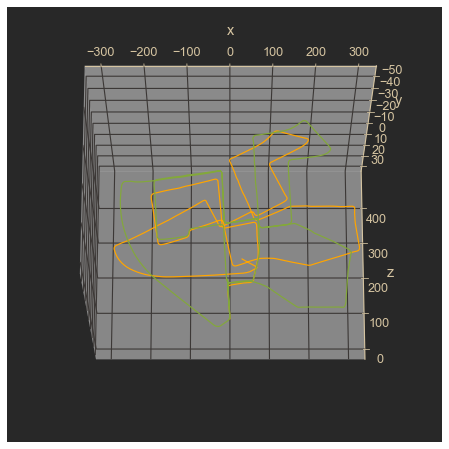

In [256]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(trajectory_lidar_sgbm[:, :, 3][:, 0], 
        trajectory_lidar_sgbm[:, :, 3][:, 1], 
        trajectory_lidar_sgbm[:, :, 3][:, 2], label='estimated', color='orange')

ax.plot(handler.gt[:, :, 3][:, 0], 
        handler.gt[:, :, 3][:, 1], 
        handler.gt[:, :, 3][:, 2], label='ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=-20, azim=270)

In [257]:
calculate_error(handler.gt, trajectory_lidar_sgbm, 'all')

{'mae': 37.45459745357176,
 'rmse': 46.94837938422659,
 'mse': 2204.1503268052725}

In [ ]:
# We can see a miniscule improvement over using the StereoSGBM matcher with no LIDAR depth
# correction. Further, incorporating the function to project each point cloud to the image
# plane to provide depth corrections to the stereo depth estimation slowed down our frame rate.
# One reason that adding the LIDAR may not be improving our results very much is that we're
# using RANSAC to estimate the motion, and since this algorithm is robust to outliers, it is
# probably doing most of the heavy lifting of dealing with errors in the stereo depth estimation
# process all by itself, and creating poses which ignore their impact. The LIDAR data would
# probably best serve us in generating a 3D localization map, which we'll save for a later
# tutorial.

These results aren't terrible, considering that only stereo depth and visual odometry were being used without any help from mapping or a vehicle model, but they need to be improved. Similarly, the computation time was not acceptable, and we'll need more efficient methods. Using a FLANN based matcher instead of brute force may help. If that is still not enough, we probably need to move away from using SIFT, perhaps ORB (although as we will see ORB provides terrible results).

In [276]:
# Let's see if using the FLANN matcher improves our frame rate at all
start = datetime.datetime.now()
trajectory_flann = visual_odometry(handler, 
                                   filter_match_distance=0.5, 
                                   matching='FLANN',
                                   subset=10)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)

Generating disparities with StereoBM
Detecting features with SIFT and matching with FLANN
Filtering feature matches at threshold of 0.5*distance
Improving stereo depth estimation with lidar data
Time to compute frame 1: 0:00:00.681740
Time to compute frame 2: 0:00:00.685047
Time to compute frame 3: 0:00:00.686999
Time to compute frame 4: 0:00:00.690002
Time to compute frame 5: 0:00:00.699001
Time to compute frame 6: 0:00:00.730998
Time to compute frame 7: 0:00:00.678005
Time to compute frame 8: 0:00:00.692998
Time to compute frame 9: 0:00:00.699002
Time to compute frame 10: 0:00:00.681004
Time to perform odometry: 0:00:06.932785


In [ ]:
# Changing to FLANN does not demonstrate any appreciable speed increase, in fact it seems slower

In [507]:
# Let's see how ORB performs
start = datetime.datetime.now()
trajectory_orb = visual_odometry(handler, 
                                   filter_match_distance=0.3, 
                                   detector='orb',
                                   subset=None)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)

Generating disparities with StereoBM
Detecting features with ORB and matching with BF
Filtering feature matches at threshold of 0.3*distance
Time to compute frame 1: 0:00:00.104997
Time to compute frame 2: 0:00:00.104994
Time to compute frame 3: 0:00:00.095028
Time to compute frame 4: 0:00:00.103997
Time to compute frame 5: 0:00:00.108005
Time to compute frame 6: 0:00:00.123003
Time to compute frame 7: 0:00:00.117001
Time to compute frame 8: 0:00:00.094011
Time to compute frame 9: 0:00:00.107000
Time to compute frame 10: 0:00:00.097997
Time to compute frame 11: 0:00:00.105001
Time to compute frame 12: 0:00:00.099004
Time to compute frame 13: 0:00:00.105999
Time to compute frame 14: 0:00:00.102998
Time to compute frame 15: 0:00:00.104004
Time to compute frame 16: 0:00:00.099996
Time to compute frame 17: 0:00:00.093999
Time to compute frame 18: 0:00:00.093001
Time to compute frame 19: 0:00:00.093032
Time to compute frame 20: 0:00:00.100000
Time to compute frame 21: 0:00:00.108031
Time to

Time to compute frame 198: 0:00:00.096005
Time to compute frame 199: 0:00:00.089000
Time to compute frame 200: 0:00:00.088966
Time to compute frame 201: 0:00:00.092001
Time to compute frame 202: 0:00:00.099033
Time to compute frame 203: 0:00:00.109972
Time to compute frame 204: 0:00:00.098999
Time to compute frame 205: 0:00:00.100001
Time to compute frame 206: 0:00:00.100026
Time to compute frame 207: 0:00:00.100003
Time to compute frame 208: 0:00:00.103995
Time to compute frame 209: 0:00:00.099999
Time to compute frame 210: 0:00:00.100001
Time to compute frame 211: 0:00:00.095998
Time to compute frame 212: 0:00:00.092001
Time to compute frame 213: 0:00:00.099000
Time to compute frame 214: 0:00:00.090997
Time to compute frame 215: 0:00:00.090003
Time to compute frame 216: 0:00:00.093003
Time to compute frame 217: 0:00:00.088995
Time to compute frame 218: 0:00:00.089006
Time to compute frame 219: 0:00:00.086995
Time to compute frame 220: 0:00:00.098002
Time to compute frame 221: 0:00:00

Time to compute frame 396: 0:00:00.098999
Time to compute frame 397: 0:00:00.106997
Time to compute frame 398: 0:00:00.090999
Time to compute frame 399: 0:00:00.084992
Time to compute frame 400: 0:00:00.083033
Time to compute frame 401: 0:00:00.088963
Time to compute frame 402: 0:00:00.090998
Time to compute frame 403: 0:00:00.082000
Time to compute frame 404: 0:00:00.083005
Time to compute frame 405: 0:00:00.085002
Time to compute frame 406: 0:00:00.101004
Time to compute frame 407: 0:00:00.096997
Time to compute frame 408: 0:00:00.086005
Time to compute frame 409: 0:00:00.087000
Time to compute frame 410: 0:00:00.091000
Time to compute frame 411: 0:00:00.082999
Time to compute frame 412: 0:00:00.093002
Time to compute frame 413: 0:00:00.085005
Time to compute frame 414: 0:00:00.094995
Time to compute frame 415: 0:00:00.090030
Time to compute frame 416: 0:00:00.083967
Time to compute frame 417: 0:00:00.099001
Time to compute frame 418: 0:00:00.095000
Time to compute frame 419: 0:00:00

Time to compute frame 593: 0:00:00.095004
Time to compute frame 594: 0:00:00.091000
Time to compute frame 595: 0:00:00.093005
Time to compute frame 596: 0:00:00.093030
Time to compute frame 597: 0:00:00.095966
Time to compute frame 598: 0:00:00.091034
Time to compute frame 599: 0:00:00.094002
Time to compute frame 600: 0:00:00.096962
Time to compute frame 601: 0:00:00.089004
Time to compute frame 602: 0:00:00.088032
Time to compute frame 603: 0:00:00.088000
Time to compute frame 604: 0:00:00.090999
Time to compute frame 605: 0:00:00.090996
Time to compute frame 606: 0:00:00.091006
Time to compute frame 607: 0:00:00.090999
Time to compute frame 608: 0:00:00.091001
Time to compute frame 609: 0:00:00.086513
Time to compute frame 610: 0:00:00.087002
Time to compute frame 611: 0:00:00.093004
Time to compute frame 612: 0:00:00.082035
Time to compute frame 613: 0:00:00.081970
Time to compute frame 614: 0:00:00.119995
Time to compute frame 615: 0:00:00.082997
Time to compute frame 616: 0:00:00

Time to compute frame 789: 0:00:00.096001
Time to compute frame 790: 0:00:00.093996
Time to compute frame 791: 0:00:00.091033
Time to compute frame 792: 0:00:00.096966
Time to compute frame 793: 0:00:00.111000
Time to compute frame 794: 0:00:00.095006
Time to compute frame 795: 0:00:00.093001
Time to compute frame 796: 0:00:00.115002
Time to compute frame 797: 0:00:00.095966
Time to compute frame 798: 0:00:00.098999
Time to compute frame 799: 0:00:00.091001
Time to compute frame 800: 0:00:00.093000
Time to compute frame 801: 0:00:00.092999
Time to compute frame 802: 0:00:00.093001
Time to compute frame 803: 0:00:00.091997
Time to compute frame 804: 0:00:00.097001
Time to compute frame 805: 0:00:00.091975
Time to compute frame 806: 0:00:00.098994
Time to compute frame 807: 0:00:00.112999
Time to compute frame 808: 0:00:00.122999
Time to compute frame 809: 0:00:00.090000
Time to compute frame 810: 0:00:00.089995
Time to compute frame 811: 0:00:00.096002
Time to compute frame 812: 0:00:00

Time to compute frame 985: 0:00:00.110003
Time to compute frame 986: 0:00:00.091003
Time to compute frame 987: 0:00:00.093998
Time to compute frame 988: 0:00:00.093998
Time to compute frame 989: 0:00:00.110000
Time to compute frame 990: 0:00:00.110003
Time to compute frame 991: 0:00:00.114001
Time to compute frame 992: 0:00:00.099003
Time to compute frame 993: 0:00:00.090028
Time to compute frame 994: 0:00:00.111968
Time to compute frame 995: 0:00:00.121002
Time to compute frame 996: 0:00:00.108003
Time to compute frame 997: 0:00:00.116997
Time to compute frame 998: 0:00:00.114998
Time to compute frame 999: 0:00:00.103004
Time to compute frame 1000: 0:00:00.100996
Time to compute frame 1001: 0:00:00.091006
Time to compute frame 1002: 0:00:00.098000
Time to compute frame 1003: 0:00:00.100998
Time to compute frame 1004: 0:00:00.094998
Time to compute frame 1005: 0:00:00.094004
Time to compute frame 1006: 0:00:00.089000
Time to compute frame 1007: 0:00:00.098997
Time to compute frame 1008

Time to compute frame 1177: 0:00:00.112001
Time to compute frame 1178: 0:00:00.091034
Time to compute frame 1179: 0:00:00.091999
Time to compute frame 1180: 0:00:00.096993
Time to compute frame 1181: 0:00:00.093001
Time to compute frame 1182: 0:00:00.110064
Time to compute frame 1183: 0:00:00.092987
Time to compute frame 1184: 0:00:00.097005
Time to compute frame 1185: 0:00:00.095021
Time to compute frame 1186: 0:00:00.101020
Time to compute frame 1187: 0:00:00.113014
Time to compute frame 1188: 0:00:00.105997
Time to compute frame 1189: 0:00:00.104000
Time to compute frame 1190: 0:00:00.102999
Time to compute frame 1191: 0:00:00.105031
Time to compute frame 1192: 0:00:00.101001
Time to compute frame 1193: 0:00:00.090998
Time to compute frame 1194: 0:00:00.095000
Time to compute frame 1195: 0:00:00.095034
Time to compute frame 1196: 0:00:00.096207
Time to compute frame 1197: 0:00:00.090966
Time to compute frame 1198: 0:00:00.093002
Time to compute frame 1199: 0:00:00.104011
Time to com

Time to compute frame 1368: 0:00:00.087999
Time to compute frame 1369: 0:00:00.091002
Time to compute frame 1370: 0:00:00.093000
Time to compute frame 1371: 0:00:00.102004
Time to compute frame 1372: 0:00:00.101998
Time to compute frame 1373: 0:00:00.087999
Time to compute frame 1374: 0:00:00.096999
Time to compute frame 1375: 0:00:00.089999
Time to compute frame 1376: 0:00:00.084999
Time to compute frame 1377: 0:00:00.101003
Time to compute frame 1378: 0:00:00.091037
Time to compute frame 1379: 0:00:00.083997
Time to compute frame 1380: 0:00:00.087001
Time to compute frame 1381: 0:00:00.087001
Time to compute frame 1382: 0:00:00.104002
Time to compute frame 1383: 0:00:00.088995
Time to compute frame 1384: 0:00:00.089006
Time to compute frame 1385: 0:00:00.094000
Time to compute frame 1386: 0:00:00.088998
Time to compute frame 1387: 0:00:00.093001
Time to compute frame 1388: 0:00:00.106997
Time to compute frame 1389: 0:00:00.089998
Time to compute frame 1390: 0:00:00.098003
Time to com

Time to compute frame 1749: 0:00:00.107998
Time to compute frame 1750: 0:00:00.119001
Time to compute frame 1751: 0:00:00.113000
Time to compute frame 1752: 0:00:00.105002
Time to compute frame 1753: 0:00:00.128999
Time to compute frame 1754: 0:00:00.108999
Time to compute frame 1755: 0:00:00.101002
Time to compute frame 1756: 0:00:00.112997
Time to compute frame 1757: 0:00:00.117000
Time to compute frame 1758: 0:00:00.101005
Time to compute frame 1759: 0:00:00.105996
Time to compute frame 1760: 0:00:00.098997
Time to compute frame 1761: 0:00:00.100002
Time to compute frame 1762: 0:00:00.120000
Time to compute frame 1763: 0:00:00.112000
Time to compute frame 1764: 0:00:00.099999
Time to compute frame 1765: 0:00:00.095002
Time to compute frame 1766: 0:00:00.087000
Time to compute frame 1767: 0:00:00.102000
Time to compute frame 1768: 0:00:00.095999
Time to compute frame 1769: 0:00:00.090041
Time to compute frame 1770: 0:00:00.096963
Time to compute frame 1771: 0:00:00.104002
Time to com

Time to compute frame 1941: 0:00:00.091997
Time to compute frame 1942: 0:00:00.089002
Time to compute frame 1943: 0:00:00.101002
Time to compute frame 1944: 0:00:00.091001
Time to compute frame 1945: 0:00:00.096033
Time to compute frame 1946: 0:00:00.097967
Time to compute frame 1947: 0:00:00.089999
Time to compute frame 1948: 0:00:00.099003
Time to compute frame 1949: 0:00:00.103999
Time to compute frame 1950: 0:00:00.101005
Time to compute frame 1951: 0:00:00.095996
Time to compute frame 1952: 0:00:00.097001
Time to compute frame 1953: 0:00:00.115000
Time to compute frame 1954: 0:00:00.097005
Time to compute frame 1955: 0:00:00.096003
Time to compute frame 1956: 0:00:00.091996
Time to compute frame 1957: 0:00:00.096999
Time to compute frame 1958: 0:00:00.096998
Time to compute frame 1959: 0:00:00.100004
Time to compute frame 1960: 0:00:00.093994
Time to compute frame 1961: 0:00:00.097003
Time to compute frame 1962: 0:00:00.099998
Time to compute frame 1963: 0:00:00.103037
Time to com

Time to compute frame 2323: 0:00:00.098006
Time to compute frame 2324: 0:00:00.102963
Time to compute frame 2325: 0:00:00.110997
Time to compute frame 2326: 0:00:00.103001
Time to compute frame 2327: 0:00:00.108034
Time to compute frame 2328: 0:00:00.099996
Time to compute frame 2329: 0:00:00.102002
Time to compute frame 2330: 0:00:00.104962
Time to compute frame 2331: 0:00:00.095039
Time to compute frame 2332: 0:00:00.100001
Time to compute frame 2333: 0:00:00.095995
Time to compute frame 2334: 0:00:00.101005
Time to compute frame 2335: 0:00:00.098995
Time to compute frame 2336: 0:00:00.098004
Time to compute frame 2337: 0:00:00.094997
Time to compute frame 2338: 0:00:00.104036
Time to compute frame 2339: 0:00:00.092966
Time to compute frame 2340: 0:00:00.100032
Time to compute frame 2341: 0:00:00.100001
Time to compute frame 2342: 0:00:00.095006
Time to compute frame 2343: 0:00:00.096032
Time to compute frame 2344: 0:00:00.094000
Time to compute frame 2345: 0:00:00.097003
Time to com

Time to compute frame 2514: 0:00:00.108994
Time to compute frame 2515: 0:00:00.091000
Time to compute frame 2516: 0:00:00.085999
Time to compute frame 2517: 0:00:00.086001
Time to compute frame 2518: 0:00:00.101001
Time to compute frame 2519: 0:00:00.092996
Time to compute frame 2520: 0:00:00.091001
Time to compute frame 2521: 0:00:00.085000
Time to compute frame 2522: 0:00:00.094001
Time to compute frame 2523: 0:00:00.097001
Time to compute frame 2524: 0:00:00.083997
Time to compute frame 2525: 0:00:00.086036
Time to compute frame 2526: 0:00:00.089031
Time to compute frame 2527: 0:00:00.083962
Time to compute frame 2528: 0:00:00.089036
Time to compute frame 2529: 0:00:00.094970
Time to compute frame 2530: 0:00:00.089003
Time to compute frame 2531: 0:00:00.082031
Time to compute frame 2532: 0:00:00.084969
Time to compute frame 2533: 0:00:00.088997
Time to compute frame 2534: 0:00:00.087996
Time to compute frame 2535: 0:00:00.089000
Time to compute frame 2536: 0:00:00.085031
Time to com

Time to compute frame 2896: 0:00:00.101002
Time to compute frame 2897: 0:00:00.086999
Time to compute frame 2898: 0:00:00.085971
Time to compute frame 2899: 0:00:00.084000
Time to compute frame 2900: 0:00:00.091032
Time to compute frame 2901: 0:00:00.092966
Time to compute frame 2902: 0:00:00.082038
Time to compute frame 2903: 0:00:00.084963
Time to compute frame 2904: 0:00:00.088000
Time to compute frame 2905: 0:00:00.083003
Time to compute frame 2906: 0:00:00.081006
Time to compute frame 2907: 0:00:00.087992
Time to compute frame 2908: 0:00:00.087000
Time to compute frame 2909: 0:00:00.083000
Time to compute frame 2910: 0:00:00.084005
Time to compute frame 2911: 0:00:00.095997
Time to compute frame 2912: 0:00:00.103010
Time to compute frame 2913: 0:00:00.088000
Time to compute frame 2914: 0:00:00.101999
Time to compute frame 2915: 0:00:00.086029
Time to compute frame 2916: 0:00:00.086968
Time to compute frame 2917: 0:00:00.080030
Time to compute frame 2918: 0:00:00.080003
Time to com

Time to compute frame 3087: 0:00:00.095001
Time to compute frame 3088: 0:00:00.086003
Time to compute frame 3089: 0:00:00.104997
Time to compute frame 3090: 0:00:00.104997
Time to compute frame 3091: 0:00:00.087003
Time to compute frame 3092: 0:00:00.097994
Time to compute frame 3093: 0:00:00.085003
Time to compute frame 3094: 0:00:00.087998
Time to compute frame 3095: 0:00:00.087004
Time to compute frame 3096: 0:00:00.089997
Time to compute frame 3097: 0:00:00.093005
Time to compute frame 3098: 0:00:00.098995
Time to compute frame 3099: 0:00:00.094002
Time to compute frame 3100: 0:00:00.094000
Time to compute frame 3101: 0:00:00.092997
Time to compute frame 3102: 0:00:00.088999
Time to compute frame 3103: 0:00:00.107003
Time to compute frame 3104: 0:00:00.085999
Time to compute frame 3105: 0:00:00.109971
Time to compute frame 3106: 0:00:00.094012
Time to compute frame 3107: 0:00:00.108987
Time to compute frame 3108: 0:00:00.097998
Time to compute frame 3109: 0:00:00.094005
Time to com

Time to compute frame 3468: 0:00:00.100038
Time to compute frame 3469: 0:00:00.096001
Time to compute frame 3470: 0:00:00.091000
Time to compute frame 3471: 0:00:00.087002
Time to compute frame 3472: 0:00:00.093998
Time to compute frame 3473: 0:00:00.088000
Time to compute frame 3474: 0:00:00.094001
Time to compute frame 3475: 0:00:00.098000
Time to compute frame 3476: 0:00:00.093002
Time to compute frame 3477: 0:00:00.094000
Time to compute frame 3478: 0:00:00.088002
Time to compute frame 3479: 0:00:00.099035
Time to compute frame 3480: 0:00:00.094964
Time to compute frame 3481: 0:00:00.091006
Time to compute frame 3482: 0:00:00.087998
Time to compute frame 3483: 0:00:00.100000
Time to compute frame 3484: 0:00:00.087000
Time to compute frame 3485: 0:00:00.098000
Time to compute frame 3486: 0:00:00.103968
Time to compute frame 3487: 0:00:00.117998
Time to compute frame 3488: 0:00:00.115998
Time to compute frame 3489: 0:00:00.092999
Time to compute frame 3490: 0:00:00.095001
Time to com

Time to compute frame 3661: 0:00:00.099005
Time to compute frame 3662: 0:00:00.098000
Time to compute frame 3663: 0:00:00.089998
Time to compute frame 3664: 0:00:00.092001
Time to compute frame 3665: 0:00:00.093033
Time to compute frame 3666: 0:00:00.087029
Time to compute frame 3667: 0:00:00.092969
Time to compute frame 3668: 0:00:00.091003
Time to compute frame 3669: 0:00:00.093000
Time to compute frame 3670: 0:00:00.085998
Time to compute frame 3671: 0:00:00.086996
Time to compute frame 3672: 0:00:00.097002
Time to compute frame 3673: 0:00:00.106004
Time to compute frame 3674: 0:00:00.097032
Time to compute frame 3675: 0:00:00.093995
Time to compute frame 3676: 0:00:00.092968
Time to compute frame 3677: 0:00:00.089965
Time to compute frame 3678: 0:00:00.089002
Time to compute frame 3679: 0:00:00.092033
Time to compute frame 3680: 0:00:00.091994
Time to compute frame 3681: 0:00:00.106000
Time to compute frame 3682: 0:00:00.111002
Time to compute frame 3683: 0:00:00.130999
Time to com

Time to compute frame 3852: 0:00:00.094999
Time to compute frame 3853: 0:00:00.092031
Time to compute frame 3854: 0:00:00.085967
Time to compute frame 3855: 0:00:00.088000
Time to compute frame 3856: 0:00:00.088038
Time to compute frame 3857: 0:00:00.099966
Time to compute frame 3858: 0:00:00.086996
Time to compute frame 3859: 0:00:00.088029
Time to compute frame 3860: 0:00:00.094003
Time to compute frame 3861: 0:00:00.087031
Time to compute frame 3862: 0:00:00.097966
Time to compute frame 3863: 0:00:00.087003
Time to compute frame 3864: 0:00:00.088995
Time to compute frame 3865: 0:00:00.087998
Time to compute frame 3866: 0:00:00.089026
Time to compute frame 3867: 0:00:00.087009
Time to compute frame 3868: 0:00:00.098970
Time to compute frame 3869: 0:00:00.085998
Time to compute frame 3870: 0:00:00.087000
Time to compute frame 3871: 0:00:00.098000
Time to compute frame 3872: 0:00:00.084999
Time to compute frame 3873: 0:00:00.093998
Time to compute frame 3874: 0:00:00.093004
Time to com

Time to compute frame 4043: 0:00:00.095001
Time to compute frame 4044: 0:00:00.092999
Time to compute frame 4045: 0:00:00.092000
Time to compute frame 4046: 0:00:00.097031
Time to compute frame 4047: 0:00:00.094997
Time to compute frame 4048: 0:00:00.091005
Time to compute frame 4049: 0:00:00.093997
Time to compute frame 4050: 0:00:00.093035
Time to compute frame 4051: 0:00:00.107003
Time to compute frame 4052: 0:00:00.091028
Time to compute frame 4053: 0:00:00.096037
Time to compute frame 4054: 0:00:00.089997
Time to compute frame 4055: 0:00:00.095960
Time to compute frame 4056: 0:00:00.088034
Time to compute frame 4057: 0:00:00.092968
Time to compute frame 4058: 0:00:00.094029
Time to compute frame 4059: 0:00:00.096032
Time to compute frame 4060: 0:00:00.090967
Time to compute frame 4061: 0:00:00.090998
Time to compute frame 4062: 0:00:00.092002
Time to compute frame 4063: 0:00:00.094997
Time to compute frame 4064: 0:00:00.092004
Time to compute frame 4065: 0:00:00.086996
Time to com

Time to compute frame 4234: 0:00:00.091003
Time to compute frame 4235: 0:00:00.089997
Time to compute frame 4236: 0:00:00.098006
Time to compute frame 4237: 0:00:00.089996
Time to compute frame 4238: 0:00:00.094996
Time to compute frame 4239: 0:00:00.092000
Time to compute frame 4240: 0:00:00.090004
Time to compute frame 4241: 0:00:00.090030
Time to compute frame 4242: 0:00:00.091967
Time to compute frame 4243: 0:00:00.100999
Time to compute frame 4244: 0:00:00.092000
Time to compute frame 4245: 0:00:00.089996
Time to compute frame 4246: 0:00:00.095001
Time to compute frame 4247: 0:00:00.093004
Time to compute frame 4248: 0:00:00.092999
Time to compute frame 4249: 0:00:00.089007
Time to compute frame 4250: 0:00:00.090994
Time to compute frame 4251: 0:00:00.094998
Time to compute frame 4252: 0:00:00.109041
Time to compute frame 4253: 0:00:00.096998
Time to compute frame 4254: 0:00:00.095034
Time to compute frame 4255: 0:00:00.088967
Time to compute frame 4256: 0:00:00.091997
Time to com

Time to compute frame 4426: 0:00:00.129998
Time to compute frame 4427: 0:00:00.118002
Time to compute frame 4428: 0:00:00.096998
Time to compute frame 4429: 0:00:00.107000
Time to compute frame 4430: 0:00:00.091000
Time to compute frame 4431: 0:00:00.098003
Time to compute frame 4432: 0:00:00.098997
Time to compute frame 4433: 0:00:00.107996
Time to compute frame 4434: 0:00:00.113006
Time to compute frame 4435: 0:00:00.091002
Time to compute frame 4436: 0:00:00.107996
Time to compute frame 4437: 0:00:00.098002
Time to compute frame 4438: 0:00:00.088002
Time to compute frame 4439: 0:00:00.086002
Time to compute frame 4440: 0:00:00.091998
Time to compute frame 4441: 0:00:00.088033
Time to compute frame 4442: 0:00:00.088970
Time to compute frame 4443: 0:00:00.096003
Time to compute frame 4444: 0:00:00.102995
Time to compute frame 4445: 0:00:00.097001
Time to compute frame 4446: 0:00:00.106000
Time to compute frame 4447: 0:00:00.093002
Time to compute frame 4448: 0:00:00.114999
Time to com

Text(0.5, 0, 'z')

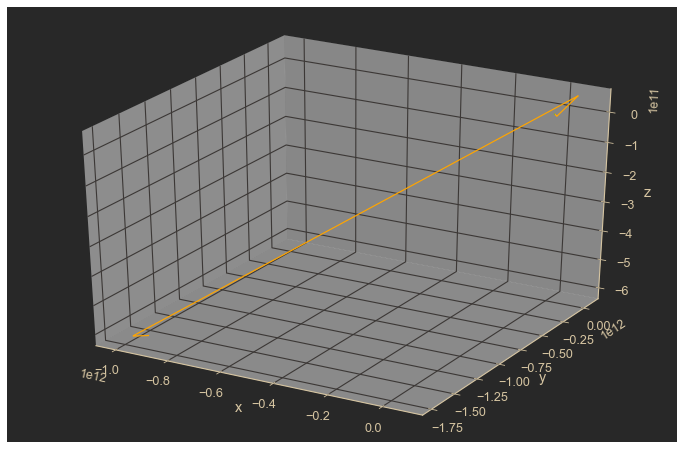

In [508]:
# We can see that ORB has put us right in the 10FPS ballpark, which is where we need to be
# to keep real time with the camera frame rate. Let's see the results.
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(trajectory_orb[:, :, 3][:, 0], 
        trajectory_orb[:, :, 3][:, 1], 
        trajectory_orb[:, :, 3][:, 2], label='estimated', color='orange')

ax.plot(handler.gt[:, :, 3][:, 0], 
        handler.gt[:, :, 3][:, 1], 
        handler.gt[:, :, 3][:, 2], label='ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=-20, azim=270)

In [ ]:
# The results from ORB are terrible. There is probably something I am missing about how to tune
# it properly, and this is something I will return to at a later date.

#### LIDAR depth correction, StereoSGBM disparity matching, stronger match filtering
So far we've been using a distance ratio of 0.5 to filter our matches, but this could be more stringent. Our best results so far have come from using LIDAR depth correction with the StereoSGBM disparity matching, so we will continue this is arrangement, and lower our match filtering ratio to 0.3, and compare the results.

In [199]:
start = datetime.datetime.now()
trajectory2 = visual_odometry(handler, 
                              filter_match_distance=0.3, 
                              stereo_matcher='sgbm',
                              mask=mask,
                              subset=None)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)

Generating disparities with StereoSGBM
Detecting features with SIFT and matching with BF
Filtering feature matches at threshold of 0.3*distance
Improving stereo depth estimation with lidar data
Time to compute frame 1: 0:00:00.730994
Time to compute frame 2: 0:00:00.721003
Time to compute frame 3: 0:00:00.701993
Time to compute frame 4: 0:00:00.712001
Time to compute frame 5: 0:00:00.732000
Time to compute frame 6: 0:00:00.715000
Time to compute frame 7: 0:00:00.714000
Time to compute frame 8: 0:00:00.734998
Time to compute frame 9: 0:00:00.729002
Time to compute frame 10: 0:00:00.682998
Time to compute frame 11: 0:00:00.697032
Time to compute frame 12: 0:00:00.653998
Time to compute frame 13: 0:00:00.657003
Time to compute frame 14: 0:00:00.669996
Time to compute frame 15: 0:00:00.635001
Time to compute frame 16: 0:00:00.682996
Time to compute frame 17: 0:00:00.670997
Time to compute frame 18: 0:00:00.657998
Time to compute frame 19: 0:00:00.656521
Time to compute frame 20: 0:00:00.67

Time to compute frame 195: 0:00:00.621001
Time to compute frame 196: 0:00:00.573998
Time to compute frame 197: 0:00:00.614999
Time to compute frame 198: 0:00:00.599997
Time to compute frame 199: 0:00:00.571336
Time to compute frame 200: 0:00:00.567999
Time to compute frame 201: 0:00:00.602997
Time to compute frame 202: 0:00:00.613998
Time to compute frame 203: 0:00:00.621000
Time to compute frame 204: 0:00:00.641186
Time to compute frame 205: 0:00:00.614000
Time to compute frame 206: 0:00:00.634999
Time to compute frame 207: 0:00:00.620000
Time to compute frame 208: 0:00:00.623999
Time to compute frame 209: 0:00:00.573997
Time to compute frame 210: 0:00:00.567999
Time to compute frame 211: 0:00:00.585998
Time to compute frame 212: 0:00:00.567998
Time to compute frame 213: 0:00:00.543037
Time to compute frame 214: 0:00:00.574964
Time to compute frame 215: 0:00:00.574000
Time to compute frame 216: 0:00:00.736999
Time to compute frame 217: 0:00:00.564000
Time to compute frame 218: 0:00:00

Time to compute frame 391: 0:00:00.543997
Time to compute frame 392: 0:00:00.565996
Time to compute frame 393: 0:00:00.520002
Time to compute frame 394: 0:00:00.550003
Time to compute frame 395: 0:00:00.537998
Time to compute frame 396: 0:00:00.536998
Time to compute frame 397: 0:00:00.512003
Time to compute frame 398: 0:00:00.520995
Time to compute frame 399: 0:00:00.532001
Time to compute frame 400: 0:00:00.517998
Time to compute frame 401: 0:00:00.516995
Time to compute frame 402: 0:00:00.518999
Time to compute frame 403: 0:00:00.523000
Time to compute frame 404: 0:00:00.531000
Time to compute frame 405: 0:00:00.532000
Time to compute frame 406: 0:00:00.536000
Time to compute frame 407: 0:00:00.548998
Time to compute frame 408: 0:00:00.518996
Time to compute frame 409: 0:00:00.551000
Time to compute frame 410: 0:00:00.521005
Time to compute frame 411: 0:00:00.527000
Time to compute frame 412: 0:00:00.512999
Time to compute frame 413: 0:00:00.526998
Time to compute frame 414: 0:00:00

Time to compute frame 587: 0:00:00.610999
Time to compute frame 588: 0:00:00.576000
Time to compute frame 589: 0:00:00.609000
Time to compute frame 590: 0:00:00.606002
Time to compute frame 591: 0:00:00.595029
Time to compute frame 592: 0:00:00.622004
Time to compute frame 593: 0:00:00.577996
Time to compute frame 594: 0:00:00.834034
Time to compute frame 595: 0:00:00.604993
Time to compute frame 596: 0:00:00.593998
Time to compute frame 597: 0:00:00.589998
Time to compute frame 598: 0:00:00.594998
Time to compute frame 599: 0:00:00.588002
Time to compute frame 600: 0:00:00.572997
Time to compute frame 601: 0:00:00.571997
Time to compute frame 602: 0:00:00.594002
Time to compute frame 603: 0:00:00.583001
Time to compute frame 604: 0:00:00.567995
Time to compute frame 605: 0:00:00.567000
Time to compute frame 606: 0:00:00.547996
Time to compute frame 607: 0:00:00.550001
Time to compute frame 608: 0:00:00.589999
Time to compute frame 609: 0:00:00.541999
Time to compute frame 610: 0:00:00

Time to compute frame 783: 0:00:00.956000
Time to compute frame 784: 0:00:00.702003
Time to compute frame 785: 0:00:00.698997
Time to compute frame 786: 0:00:00.673997
Time to compute frame 787: 0:00:00.651516
Time to compute frame 788: 0:00:00.618998
Time to compute frame 789: 0:00:00.616994
Time to compute frame 790: 0:00:00.597000
Time to compute frame 791: 0:00:00.612997
Time to compute frame 792: 0:00:00.635003
Time to compute frame 793: 0:00:00.618997
Time to compute frame 794: 0:00:00.625001
Time to compute frame 795: 0:00:00.617999
Time to compute frame 796: 0:00:00.618001
Time to compute frame 797: 0:00:00.640018
Time to compute frame 798: 0:00:00.650001
Time to compute frame 799: 0:00:00.628000
Time to compute frame 800: 0:00:00.622996
Time to compute frame 801: 0:00:00.637001
Time to compute frame 802: 0:00:00.643998
Time to compute frame 803: 0:00:00.616000
Time to compute frame 804: 0:00:00.643999
Time to compute frame 805: 0:00:00.625998
Time to compute frame 806: 0:00:00

Time to compute frame 979: 0:00:00.609000
Time to compute frame 980: 0:00:00.623002
Time to compute frame 981: 0:00:00.612997
Time to compute frame 982: 0:00:00.618850
Time to compute frame 983: 0:00:00.610999
Time to compute frame 984: 0:00:00.597999
Time to compute frame 985: 0:00:00.602999
Time to compute frame 986: 0:00:00.603009
Time to compute frame 987: 0:00:00.594999
Time to compute frame 988: 0:00:00.599997
Time to compute frame 989: 0:00:00.568994
Time to compute frame 990: 0:00:00.561996
Time to compute frame 991: 0:00:00.564997
Time to compute frame 992: 0:00:00.573999
Time to compute frame 993: 0:00:00.641996
Time to compute frame 994: 0:00:00.638000
Time to compute frame 995: 0:00:00.633004
Time to compute frame 996: 0:00:00.587998
Time to compute frame 997: 0:00:00.610514
Time to compute frame 998: 0:00:00.626999
Time to compute frame 999: 0:00:00.615996
Time to compute frame 1000: 0:00:00.641005
Time to compute frame 1001: 0:00:00.628001
Time to compute frame 1002: 0:00

Time to compute frame 1171: 0:00:00.650003
Time to compute frame 1172: 0:00:00.623984
Time to compute frame 1173: 0:00:00.617000
Time to compute frame 1174: 0:00:00.619996
Time to compute frame 1175: 0:00:00.629999
Time to compute frame 1176: 0:00:00.622000
Time to compute frame 1177: 0:00:00.651001
Time to compute frame 1178: 0:00:00.639999
Time to compute frame 1179: 0:00:00.649000
Time to compute frame 1180: 0:00:00.648999
Time to compute frame 1181: 0:00:00.683000
Time to compute frame 1182: 0:00:00.668000
Time to compute frame 1183: 0:00:00.660946
Time to compute frame 1184: 0:00:00.692997
Time to compute frame 1185: 0:00:00.690000
Time to compute frame 1186: 0:00:00.681998
Time to compute frame 1187: 0:00:00.705999
Time to compute frame 1188: 0:00:00.737997
Time to compute frame 1189: 0:00:00.728997
Time to compute frame 1190: 0:00:00.761000
Time to compute frame 1191: 0:00:00.696998
Time to compute frame 1192: 0:00:00.693517
Time to compute frame 1193: 0:00:00.646997
Time to com

Time to compute frame 1362: 0:00:00.567002
Time to compute frame 1363: 0:00:00.537998
Time to compute frame 1364: 0:00:00.569997
Time to compute frame 1365: 0:00:00.633001
Time to compute frame 1366: 0:00:00.649001
Time to compute frame 1367: 0:00:00.607003
Time to compute frame 1368: 0:00:00.579998
Time to compute frame 1369: 0:00:00.600003
Time to compute frame 1370: 0:00:00.555519
Time to compute frame 1371: 0:00:00.552000
Time to compute frame 1372: 0:00:00.520999
Time to compute frame 1373: 0:00:00.533003
Time to compute frame 1374: 0:00:00.556997
Time to compute frame 1375: 0:00:00.558007
Time to compute frame 1376: 0:00:00.538996
Time to compute frame 1377: 0:00:00.562999
Time to compute frame 1378: 0:00:00.543001
Time to compute frame 1379: 0:00:00.546992
Time to compute frame 1380: 0:00:00.527998
Time to compute frame 1381: 0:00:00.548002
Time to compute frame 1382: 0:00:00.585994
Time to compute frame 1383: 0:00:00.525758
Time to compute frame 1384: 0:00:00.540999
Time to com

Time to compute frame 1553: 0:00:00.535999
Time to compute frame 1554: 0:00:00.626999
Time to compute frame 1555: 0:00:00.576003
Time to compute frame 1556: 0:00:00.543996
Time to compute frame 1557: 0:00:00.543001
Time to compute frame 1558: 0:00:00.555000
Time to compute frame 1559: 0:00:00.558996
Time to compute frame 1560: 0:00:00.538997
Time to compute frame 1561: 0:00:00.535002
Time to compute frame 1562: 0:00:00.570513
Time to compute frame 1563: 0:00:00.566997
Time to compute frame 1564: 0:00:00.584003
Time to compute frame 1565: 0:00:00.589000
Time to compute frame 1566: 0:00:00.602003
Time to compute frame 1567: 0:00:00.625998
Time to compute frame 1568: 0:00:00.624001
Time to compute frame 1569: 0:00:00.628999
Time to compute frame 1570: 0:00:00.653998
Time to compute frame 1571: 0:00:00.729991
Time to compute frame 1572: 0:00:00.649002
Time to compute frame 1573: 0:00:00.608997
Time to compute frame 1574: 0:00:00.639005
Time to compute frame 1575: 0:00:00.658996
Time to com

Time to compute frame 1744: 0:00:00.751000
Time to compute frame 1745: 0:00:00.832000
Time to compute frame 1746: 0:00:00.796998
Time to compute frame 1747: 0:00:00.724044
Time to compute frame 1748: 0:00:00.757999
Time to compute frame 1749: 0:00:00.851996
Time to compute frame 1750: 0:00:00.734998
Time to compute frame 1751: 0:00:00.665066
Time to compute frame 1752: 0:00:00.661998
Time to compute frame 1753: 0:00:00.705139
Time to compute frame 1754: 0:00:00.680456
Time to compute frame 1755: 0:00:00.693144
Time to compute frame 1756: 0:00:00.644997
Time to compute frame 1757: 0:00:00.631074
Time to compute frame 1758: 0:00:00.628253
Time to compute frame 1759: 0:00:00.637259
Time to compute frame 1760: 0:00:00.626748
Time to compute frame 1761: 0:00:00.614998
Time to compute frame 1762: 0:00:00.661011
Time to compute frame 1763: 0:00:00.625166
Time to compute frame 1764: 0:00:00.610056
Time to compute frame 1765: 0:00:00.622115
Time to compute frame 1766: 0:00:00.603016
Time to com

Time to compute frame 1935: 0:00:00.610996
Time to compute frame 1936: 0:00:00.578001
Time to compute frame 1937: 0:00:00.618997
Time to compute frame 1938: 0:00:00.603003
Time to compute frame 1939: 0:00:00.587998
Time to compute frame 1940: 0:00:00.608998
Time to compute frame 1941: 0:00:00.598005
Time to compute frame 1942: 0:00:00.595996
Time to compute frame 1943: 0:00:00.587998
Time to compute frame 1944: 0:00:00.626998
Time to compute frame 1945: 0:00:00.614998
Time to compute frame 1946: 0:00:00.609997
Time to compute frame 1947: 0:00:00.628002
Time to compute frame 1948: 0:00:00.622999
Time to compute frame 1949: 0:00:00.633996
Time to compute frame 1950: 0:00:00.619999
Time to compute frame 1951: 0:00:00.621995
Time to compute frame 1952: 0:00:00.640001
Time to compute frame 1953: 0:00:00.617995
Time to compute frame 1954: 0:00:00.612528
Time to compute frame 1955: 0:00:00.636999
Time to compute frame 1956: 0:00:00.614998
Time to compute frame 1957: 0:00:00.629999
Time to com

Time to compute frame 2126: 0:00:00.683002
Time to compute frame 2127: 0:00:00.660002
Time to compute frame 2128: 0:00:00.628995
Time to compute frame 2129: 0:00:00.627999
Time to compute frame 2130: 0:00:00.601999
Time to compute frame 2131: 0:00:00.610045
Time to compute frame 2132: 0:00:00.591000
Time to compute frame 2133: 0:00:00.597998
Time to compute frame 2134: 0:00:00.617001
Time to compute frame 2135: 0:00:00.580998
Time to compute frame 2136: 0:00:00.594996
Time to compute frame 2137: 0:00:00.580996
Time to compute frame 2138: 0:00:00.585998
Time to compute frame 2139: 0:00:00.586001
Time to compute frame 2140: 0:00:00.562001
Time to compute frame 2141: 0:00:00.594001
Time to compute frame 2142: 0:00:00.584001
Time to compute frame 2143: 0:00:00.636992
Time to compute frame 2144: 0:00:00.581999
Time to compute frame 2145: 0:00:00.564996
Time to compute frame 2146: 0:00:00.598999
Time to compute frame 2147: 0:00:00.556001
Time to compute frame 2148: 0:00:00.604000
Time to com

Time to compute frame 2317: 0:00:00.808002
Time to compute frame 2318: 0:00:00.819001
Time to compute frame 2319: 0:00:00.807991
Time to compute frame 2320: 0:00:00.843996
Time to compute frame 2321: 0:00:00.840001
Time to compute frame 2322: 0:00:00.788997
Time to compute frame 2323: 0:00:01.038033
Time to compute frame 2324: 0:00:00.823997
Time to compute frame 2325: 0:00:00.824997
Time to compute frame 2326: 0:00:00.826000
Time to compute frame 2327: 0:00:00.822003
Time to compute frame 2328: 0:00:00.810999
Time to compute frame 2329: 0:00:00.777003
Time to compute frame 2330: 0:00:00.794996
Time to compute frame 2331: 0:00:00.761001
Time to compute frame 2332: 0:00:00.775002
Time to compute frame 2333: 0:00:00.800998
Time to compute frame 2334: 0:00:00.760002
Time to compute frame 2335: 0:00:00.777982
Time to compute frame 2336: 0:00:00.736001
Time to compute frame 2337: 0:00:00.698001
Time to compute frame 2338: 0:00:00.703001
Time to compute frame 2339: 0:00:00.662996
Time to com

Time to compute frame 2508: 0:00:00.569996
Time to compute frame 2509: 0:00:00.530000
Time to compute frame 2510: 0:00:00.532001
Time to compute frame 2511: 0:00:00.546995
Time to compute frame 2512: 0:00:00.537996
Time to compute frame 2513: 0:00:00.546655
Time to compute frame 2514: 0:00:00.533998
Time to compute frame 2515: 0:00:00.537996
Time to compute frame 2516: 0:00:00.534001
Time to compute frame 2517: 0:00:00.545000
Time to compute frame 2518: 0:00:00.537000
Time to compute frame 2519: 0:00:00.526001
Time to compute frame 2520: 0:00:00.545002
Time to compute frame 2521: 0:00:00.562002
Time to compute frame 2522: 0:00:00.557999
Time to compute frame 2523: 0:00:00.546999
Time to compute frame 2524: 0:00:00.552002
Time to compute frame 2525: 0:00:00.554996
Time to compute frame 2526: 0:00:00.552006
Time to compute frame 2527: 0:00:00.560995
Time to compute frame 2528: 0:00:00.534999
Time to compute frame 2529: 0:00:00.538003
Time to compute frame 2530: 0:00:00.523000
Time to com

Time to compute frame 2699: 0:00:00.613556
Time to compute frame 2700: 0:00:00.634050
Time to compute frame 2701: 0:00:00.574087
Time to compute frame 2702: 0:00:00.579999
Time to compute frame 2703: 0:00:00.564995
Time to compute frame 2704: 0:00:00.560999
Time to compute frame 2705: 0:00:00.565004
Time to compute frame 2706: 0:00:00.579045
Time to compute frame 2707: 0:00:00.587000
Time to compute frame 2708: 0:00:00.569003
Time to compute frame 2709: 0:00:00.581999
Time to compute frame 2710: 0:00:00.570000
Time to compute frame 2711: 0:00:00.575998
Time to compute frame 2712: 0:00:00.594000
Time to compute frame 2713: 0:00:00.581996
Time to compute frame 2714: 0:00:00.593001
Time to compute frame 2715: 0:00:00.563998
Time to compute frame 2716: 0:00:00.574005
Time to compute frame 2717: 0:00:00.578996
Time to compute frame 2718: 0:00:00.592041
Time to compute frame 2719: 0:00:00.576000
Time to compute frame 2720: 0:00:00.567999
Time to compute frame 2721: 0:00:00.577997
Time to com

Time to compute frame 2890: 0:00:00.556999
Time to compute frame 2891: 0:00:00.562996
Time to compute frame 2892: 0:00:00.562999
Time to compute frame 2893: 0:00:00.558048
Time to compute frame 2894: 0:00:00.542994
Time to compute frame 2895: 0:00:00.556004
Time to compute frame 2896: 0:00:00.550003
Time to compute frame 2897: 0:00:00.595014
Time to compute frame 2898: 0:00:00.552997
Time to compute frame 2899: 0:00:00.545001
Time to compute frame 2900: 0:00:00.534999
Time to compute frame 2901: 0:00:00.550999
Time to compute frame 2902: 0:00:00.573001
Time to compute frame 2903: 0:00:00.535994
Time to compute frame 2904: 0:00:00.533002
Time to compute frame 2905: 0:00:00.517001
Time to compute frame 2906: 0:00:00.537993
Time to compute frame 2907: 0:00:00.549001
Time to compute frame 2908: 0:00:00.527001
Time to compute frame 2909: 0:00:00.524998
Time to compute frame 2910: 0:00:00.549001
Time to compute frame 2911: 0:00:00.586998
Time to compute frame 2912: 0:00:00.564000
Time to com

Time to compute frame 3081: 0:00:00.630000
Time to compute frame 3082: 0:00:00.611996
Time to compute frame 3083: 0:00:00.570997
Time to compute frame 3084: 0:00:00.564031
Time to compute frame 3085: 0:00:00.563968
Time to compute frame 3086: 0:00:00.597998
Time to compute frame 3087: 0:00:00.582001
Time to compute frame 3088: 0:00:00.563001
Time to compute frame 3089: 0:00:00.594034
Time to compute frame 3090: 0:00:00.599002
Time to compute frame 3091: 0:00:00.573995
Time to compute frame 3092: 0:00:00.575997
Time to compute frame 3093: 0:00:00.588000
Time to compute frame 3094: 0:00:00.599999
Time to compute frame 3095: 0:00:00.595000
Time to compute frame 3096: 0:00:00.571998
Time to compute frame 3097: 0:00:00.600003
Time to compute frame 3098: 0:00:00.592000
Time to compute frame 3099: 0:00:00.601000
Time to compute frame 3100: 0:00:00.660002
Time to compute frame 3101: 0:00:00.659999
Time to compute frame 3102: 0:00:00.640998
Time to compute frame 3103: 0:00:00.617002
Time to com

Time to compute frame 3272: 0:00:00.501001
Time to compute frame 3273: 0:00:00.524001
Time to compute frame 3274: 0:00:00.518996
Time to compute frame 3275: 0:00:00.506000
Time to compute frame 3276: 0:00:00.509997
Time to compute frame 3277: 0:00:00.496003
Time to compute frame 3278: 0:00:00.515000
Time to compute frame 3279: 0:00:00.498996
Time to compute frame 3280: 0:00:00.530005
Time to compute frame 3281: 0:00:00.533996
Time to compute frame 3282: 0:00:00.541002
Time to compute frame 3283: 0:00:00.515030
Time to compute frame 3284: 0:00:00.553994
Time to compute frame 3285: 0:00:00.570513
Time to compute frame 3286: 0:00:00.606001
Time to compute frame 3287: 0:00:00.633000
Time to compute frame 3288: 0:00:00.621002
Time to compute frame 3289: 0:00:00.647998
Time to compute frame 3290: 0:00:00.642996
Time to compute frame 3291: 0:00:00.663998
Time to compute frame 3292: 0:00:00.695000
Time to compute frame 3293: 0:00:00.646998
Time to compute frame 3294: 0:00:00.708999
Time to com

Time to compute frame 3463: 0:00:00.539999
Time to compute frame 3464: 0:00:00.551996
Time to compute frame 3465: 0:00:00.550000
Time to compute frame 3466: 0:00:00.576999
Time to compute frame 3467: 0:00:00.569998
Time to compute frame 3468: 0:00:00.558000
Time to compute frame 3469: 0:00:00.595003
Time to compute frame 3470: 0:00:00.545996
Time to compute frame 3471: 0:00:00.542999
Time to compute frame 3472: 0:00:00.567998
Time to compute frame 3473: 0:00:00.564999
Time to compute frame 3474: 0:00:00.596999
Time to compute frame 3475: 0:00:00.595004
Time to compute frame 3476: 0:00:00.577996
Time to compute frame 3477: 0:00:00.630001
Time to compute frame 3478: 0:00:00.613001
Time to compute frame 3479: 0:00:00.633996
Time to compute frame 3480: 0:00:00.702521
Time to compute frame 3481: 0:00:00.654996
Time to compute frame 3482: 0:00:00.588996
Time to compute frame 3483: 0:00:00.563995
Time to compute frame 3484: 0:00:00.574003
Time to compute frame 3485: 0:00:00.613007
Time to com

Time to compute frame 3654: 0:00:00.611997
Time to compute frame 3655: 0:00:00.562999
Time to compute frame 3656: 0:00:00.577033
Time to compute frame 3657: 0:00:00.641999
Time to compute frame 3658: 0:00:00.721001
Time to compute frame 3659: 0:00:00.755002
Time to compute frame 3660: 0:00:00.667074
Time to compute frame 3661: 0:00:00.660066
Time to compute frame 3662: 0:00:00.775000
Time to compute frame 3663: 0:00:00.664016
Time to compute frame 3664: 0:00:00.638999
Time to compute frame 3665: 0:00:00.626000
Time to compute frame 3666: 0:00:00.754997
Time to compute frame 3667: 0:00:00.781001
Time to compute frame 3668: 0:00:00.673986
Time to compute frame 3669: 0:00:00.697000
Time to compute frame 3670: 0:00:00.839001
Time to compute frame 3671: 0:00:00.783998
Time to compute frame 3672: 0:00:00.697001
Time to compute frame 3673: 0:00:00.746032
Time to compute frame 3674: 0:00:00.830998
Time to compute frame 3675: 0:00:00.629002
Time to compute frame 3676: 0:00:00.570998
Time to com

Time to compute frame 3845: 0:00:00.601669
Time to compute frame 3846: 0:00:00.579999
Time to compute frame 3847: 0:00:00.585000
Time to compute frame 3848: 0:00:00.556999
Time to compute frame 3849: 0:00:00.555001
Time to compute frame 3850: 0:00:00.614002
Time to compute frame 3851: 0:00:00.572999
Time to compute frame 3852: 0:00:00.536003
Time to compute frame 3853: 0:00:00.599997
Time to compute frame 3854: 0:00:00.591001
Time to compute frame 3855: 0:00:00.568003
Time to compute frame 3856: 0:00:00.596998
Time to compute frame 3857: 0:00:00.570004
Time to compute frame 3858: 0:00:00.613996
Time to compute frame 3859: 0:00:00.586003
Time to compute frame 3860: 0:00:00.582997
Time to compute frame 3861: 0:00:00.586182
Time to compute frame 3862: 0:00:00.556995
Time to compute frame 3863: 0:00:00.560001
Time to compute frame 3864: 0:00:00.585045
Time to compute frame 3865: 0:00:00.564997
Time to compute frame 3866: 0:00:00.562002
Time to compute frame 3867: 0:00:00.549020
Time to com

Time to compute frame 4036: 0:00:00.627997
Time to compute frame 4037: 0:00:00.609002
Time to compute frame 4038: 0:00:00.624998
Time to compute frame 4039: 0:00:00.622002
Time to compute frame 4040: 0:00:00.653998
Time to compute frame 4041: 0:00:00.629999
Time to compute frame 4042: 0:00:00.617000
Time to compute frame 4043: 0:00:00.622994
Time to compute frame 4044: 0:00:00.631000
Time to compute frame 4045: 0:00:00.633996
Time to compute frame 4046: 0:00:00.663001
Time to compute frame 4047: 0:00:00.663996
Time to compute frame 4048: 0:00:00.643998
Time to compute frame 4049: 0:00:00.654998
Time to compute frame 4050: 0:00:00.648006
Time to compute frame 4051: 0:00:00.657997
Time to compute frame 4052: 0:00:00.615002
Time to compute frame 4053: 0:00:00.588995
Time to compute frame 4054: 0:00:00.617999
Time to compute frame 4055: 0:00:00.603998
Time to compute frame 4056: 0:00:00.607001
Time to compute frame 4057: 0:00:00.612995
Time to compute frame 4058: 0:00:00.603000
Time to com

Time to compute frame 4227: 0:00:00.605999
Time to compute frame 4228: 0:00:00.587002
Time to compute frame 4229: 0:00:00.592000
Time to compute frame 4230: 0:00:00.576998
Time to compute frame 4231: 0:00:00.646997
Time to compute frame 4232: 0:00:00.616998
Time to compute frame 4233: 0:00:00.675999
Time to compute frame 4234: 0:00:00.745019
Time to compute frame 4235: 0:00:00.702000
Time to compute frame 4236: 0:00:00.724002
Time to compute frame 4237: 0:00:00.656999
Time to compute frame 4238: 0:00:00.688001
Time to compute frame 4239: 0:00:00.669002
Time to compute frame 4240: 0:00:00.669994
Time to compute frame 4241: 0:00:00.581999
Time to compute frame 4242: 0:00:00.575999
Time to compute frame 4243: 0:00:00.592999
Time to compute frame 4244: 0:00:00.561999
Time to compute frame 4245: 0:00:00.565001
Time to compute frame 4246: 0:00:00.591000
Time to compute frame 4247: 0:00:00.575997
Time to compute frame 4248: 0:00:00.577998
Time to compute frame 4249: 0:00:00.579000
Time to com

Time to compute frame 4418: 0:00:00.538999
Time to compute frame 4419: 0:00:00.549035
Time to compute frame 4420: 0:00:00.554999
Time to compute frame 4421: 0:00:00.558995
Time to compute frame 4422: 0:00:00.542998
Time to compute frame 4423: 0:00:00.539028
Time to compute frame 4424: 0:00:00.528967
Time to compute frame 4425: 0:00:00.559692
Time to compute frame 4426: 0:00:00.531885
Time to compute frame 4427: 0:00:00.553998
Time to compute frame 4428: 0:00:00.552633
Time to compute frame 4429: 0:00:00.540054
Time to compute frame 4430: 0:00:00.561079
Time to compute frame 4431: 0:00:00.535481
Time to compute frame 4432: 0:00:00.584003
Time to compute frame 4433: 0:00:00.583002
Time to compute frame 4434: 0:00:00.588999
Time to compute frame 4435: 0:00:00.575998
Time to compute frame 4436: 0:00:00.535995
Time to compute frame 4437: 0:00:00.547000
Time to compute frame 4438: 0:00:00.545996
Time to compute frame 4439: 0:00:00.553000
Time to compute frame 4440: 0:00:00.564001
Time to com

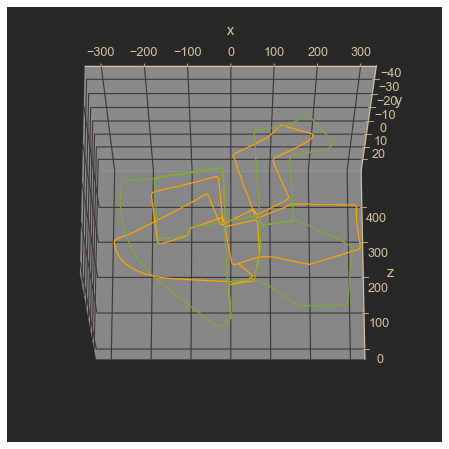

In [202]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(trajectory2[:, :, 3][:, 0], 
        trajectory2[:, :, 3][:, 1], 
        trajectory2[:, :, 3][:, 2], label='estimated', color='orange')

ax.plot(handler.gt[:, :, 3][:, 0], 
        handler.gt[:, :, 3][:, 1], 
        handler.gt[:, :, 3][:, 2], label='ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=-20, azim=270)

In [234]:
calculate_error(handler.gt, trajectory2, 'all')

{'mae': 32.21427840821878,
 'rmse': 39.61011073615048,
 'mse': 1568.9608725301036}

In [ ]:
# This has had a noticeable impact on our error. It appears that stringent filtering of feature
# matches between images is a powerful way to improve performance.

# Appendix A:
Showing that arithmetic strategy faster than dot product:

In [192]:
# Decompose projection matrix to get intrinsic k matrix
k0, r0, t0, _, _, _, _ = cv2.decomposeProjectionMatrix(handler.P0)

In [193]:
# First run the math using the arithmetric derived from what the matrix multiplication does
start = datetime.datetime.now()
cx = k0[0, 2]
cy = k0[1, 2]
fx = k0[0, 0]
fy = k0[1, 1]
delete = []
object_points = np.zeros((0, 3))
image1_points = np.float32([kp0[m.queryIdx].pt for m in matches])
for i, (u, v) in enumerate(image1_points):
    z = depth[int(v), int(u)]
    if z > 3000:
        delete.append(i)
        continue
    x = z*(u-cx)/fx
    y = z*(v-cy)/fy
    object_points = np.vstack([object_points, np.array([x, y, z])])
    #object_points = np.vstack([object_points, np.linalg.inv(k0).dot(z*np.array([u, v, 1]))])
end = datetime.datetime.now()
print('Time to compute:', end-start)
print(object_points)

Time to compute: 0:00:00.037968
[[  3.50461848  -2.25380255  48.2681    ]
 [ -5.9355166   -4.52124313  29.70344615]
 [-13.00586866  -1.1806672   31.52202449]
 ...
 [ -1.86770698   0.60537074  25.32097049]
 [ -0.20512125   1.47857621  16.08936667]
 [  1.56142055   1.54149227  15.33081092]]


In [194]:
# Now run the math using matrix multiplication with the inverted k matrix
start = datetime.datetime.now()
delete = []
object_points = np.zeros((0, 3))
image1_points = np.float32([kp0[m.queryIdx].pt for m in matches])
for i, (u, v) in enumerate(image1_points):
    z = depth[int(v), int(u)]
    if z > 3000:
    #    print(z)
        delete.append(i)
        continue
    #else:
    #    print(u,v)
    x = z*(u-cx)/fx
    y = z*(v-cy)/fy
    #object_points = np.vstack([object_points, np.array([x, y, z])])
    object_points = np.vstack([object_points, np.linalg.inv(k0).dot(z*np.array([u, v, 1]))])
end = datetime.datetime.now()
print('Time to compute:', end-start)
print(object_points)

Time to compute: 0:00:00.069964
[[  3.50461848  -2.25380255  48.2681    ]
 [ -5.9355166   -4.52124313  29.70344615]
 [-13.00586866  -1.1806672   31.52202449]
 ...
 [ -1.86770698   0.60537074  25.32097049]
 [ -0.20512125   1.47857621  16.08936667]
 [  1.56142055   1.54149227  15.33081092]]


In [ ]:
# We can see that the arithmetic method is significantly faster